# Kaggle Playground S4e1 - Predict Bank Customer Churn
## Links
- Competition: <https://www.kaggle.com/competitions/playground-series-s4e1/overview>
- Dataset used as base of the competition's dataset: <https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction>

## About dataset

The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry. It contains information on bank customers who either left the bank or continue to be a customer. The dataset includes the following attributes:

- Customer ID: A unique identifier for each customer
- Surname: The customer's surname or last name
- Credit Score: A numerical value representing the customer's credit score
- Geography: The country where the customer resides (France, Spain or Germany)
- Gender: The customer's gender (Male or Female)
- Age: The customer's age.
- Tenure: The number of years the customer has been with the bank
- Balance: The customer's account balance
- NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)
- HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)
- IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)
- EstimatedSalary: The estimated salary of the customer
- Exited: Whether the customer has churned (1 = yes, 0 = no) 

## Load dataset

In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, IsolationForest
import optuna
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

In [2]:
df = pd.read_csv(os.path.join('datasets', 'train.csv'))
df_id = df['id']
df.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [9]:
df.head()

CreditScore Geography Gender   Age  Tenure    Balance  NumOfProducts  \
0          668    France   Male  33.0       3       0.00              2   
1          627    France   Male  33.0       1       0.00              2   
2          678    France   Male  40.0      10       0.00              2   
3          581    France   Male  34.0       2  148882.54              1   
4          716     Spain   Male  33.0       5       0.00              2   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0        1.0             0.0        181449.97       0  
1        1.0             1.0         49503.50       0  
2        1.0             0.0        184866.69       0  
3        1.0             1.0         84560.88       0  
4        1.0             1.0         15068.83       0

### Exploratory Data Analysis

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  float64
 8   IsActiveMember   165034 non-null  float64
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 13.9+ MB


No missing values

In [7]:
y = df['Exited']

In [8]:
type(y.value_counts())

pandas.core.series.Series

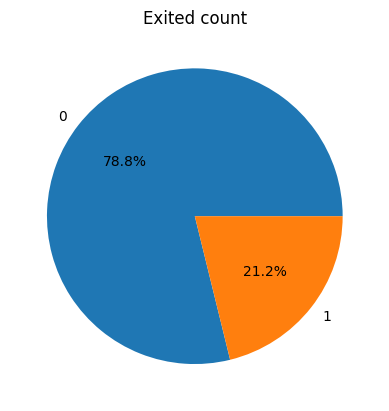

In [9]:
def plot_y(y: pd.Series):
    fig, ax = plt.subplots()
    ax.set_title('Exited count')
    y_value_counts = y.value_counts()
    y_index = y_value_counts.index
    y_values = y_value_counts.values
    ax.pie(y_values, labels=y_index, autopct='%1.1f%%')

plot_y(y)

In [131]:
1/0.212

4.716981132075472

In [105]:
num_variables = df.select_dtypes(['int64', 'float64']).drop(['HasCrCard', 'IsActiveMember'], axis=1)
num_variables

CreditScore   Age  Tenure    Balance  NumOfProducts  EstimatedSalary  \
0               668  33.0       3       0.00              2        181449.97   
1               627  33.0       1       0.00              2         49503.50   
2               678  40.0      10       0.00              2        184866.69   
3               581  34.0       2  148882.54              1         84560.88   
4               716  33.0       5       0.00              2         15068.83   
...             ...   ...     ...        ...            ...              ...   
165029          667  33.0       2       0.00              1        131834.75   
165030          792  35.0       3       0.00              1        131834.45   
165031          565  31.0       5       0.00              1        127429.56   
165032          554  30.0       7  161533.00              1         71173.03   
165033          850  31.0       1       0.00              1         61581.79   

        Exited  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
165029       0  
165030       0  
165031       0  
165032       0  
165033       1  

[165034 rows x 7 columns]

In [11]:
num_variables.groupby('Exited').mean()

CreditScore        Age    Tenure       Balance  NumOfProducts  \
Exited                                                                  
0        657.590710  36.560480  5.048796  51255.807752       1.615273   
1        652.220469  43.958478  4.914378  71209.978085       1.327854   

        EstimatedSalary  
Exited                   
0         112084.293725  
1         114402.496656

<Axes: >

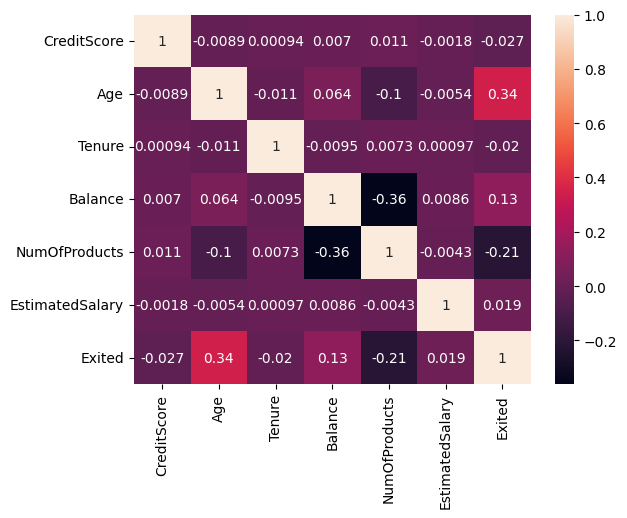

In [12]:
corrmat = num_variables.corr()
sns.heatmap(corrmat, annot=True)

<Axes: xlabel='Balance', ylabel='Age'>

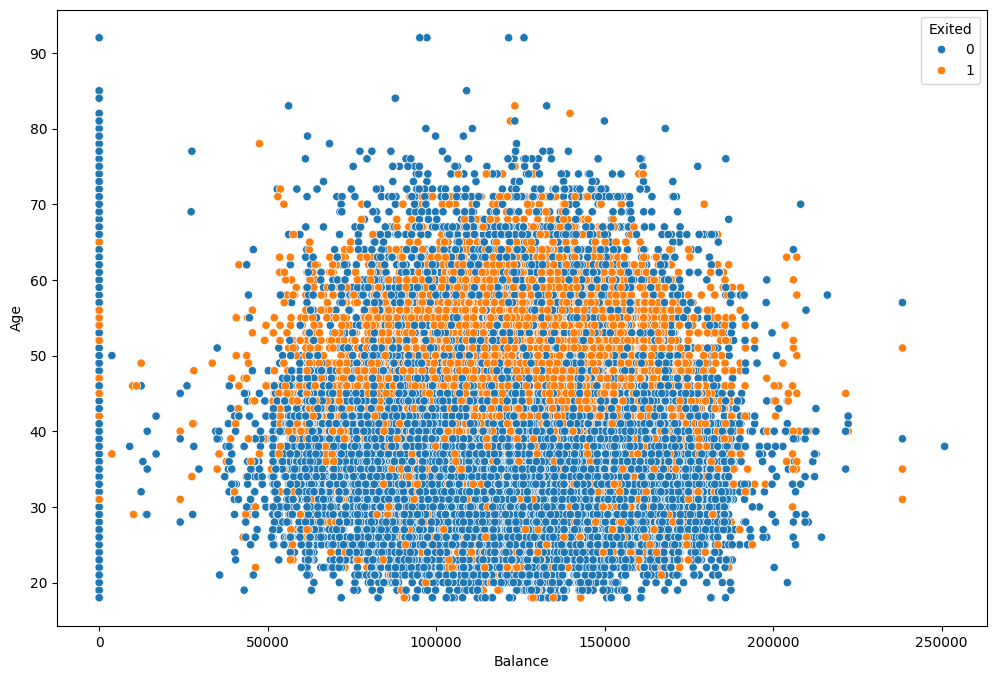

In [13]:
plt.figure(figsize=(12,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue='Exited')

<Axes: xlabel='Age', ylabel='Count'>

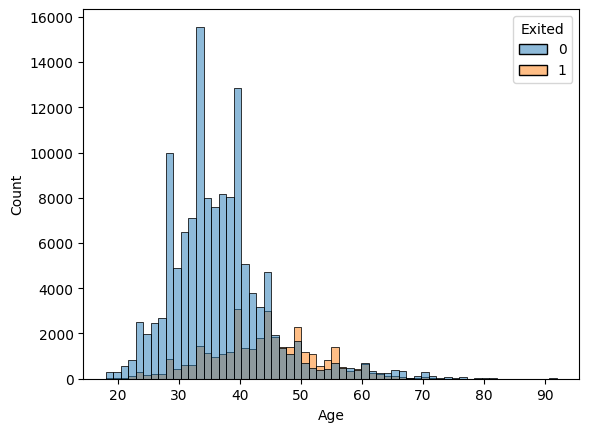

In [14]:
sns.histplot(num_variables, x='Age', hue='Exited', bins=60)

In [ ]:
sns.boxplot()

In [50]:
cat_variables = df[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']].astype({'Exited': 'O'})
cat_variables

Geography  Gender  HasCrCard  IsActiveMember Exited
0         France    Male        1.0             0.0      0
1         France    Male        1.0             1.0      0
2         France    Male        1.0             0.0      0
3         France    Male        1.0             1.0      0
4          Spain    Male        1.0             1.0      0
...          ...     ...        ...             ...    ...
165029     Spain  Female        1.0             1.0      0
165030    France    Male        0.0             0.0      0
165031    France    Male        1.0             1.0      0
165032     Spain  Female        0.0             1.0      0
165033    France    Male        1.0             0.0      1

[165034 rows x 5 columns]

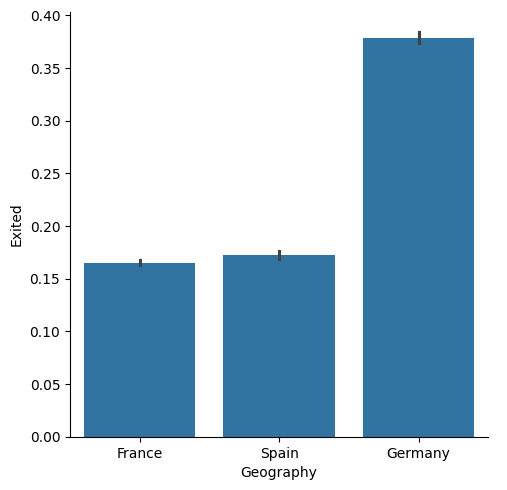

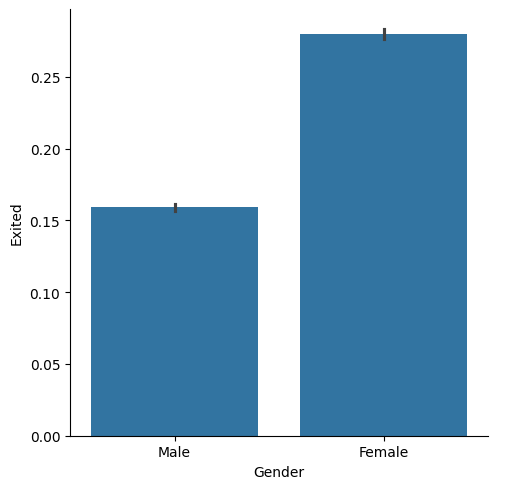

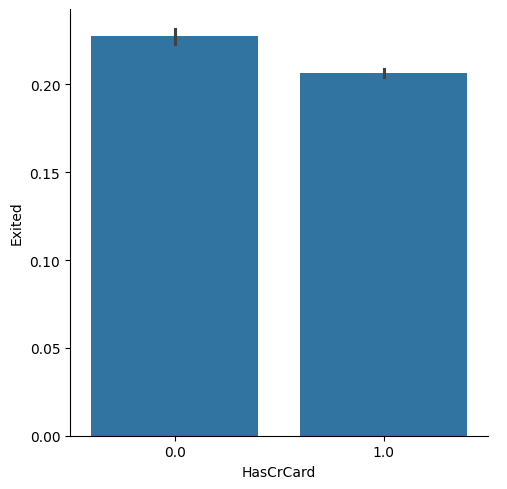

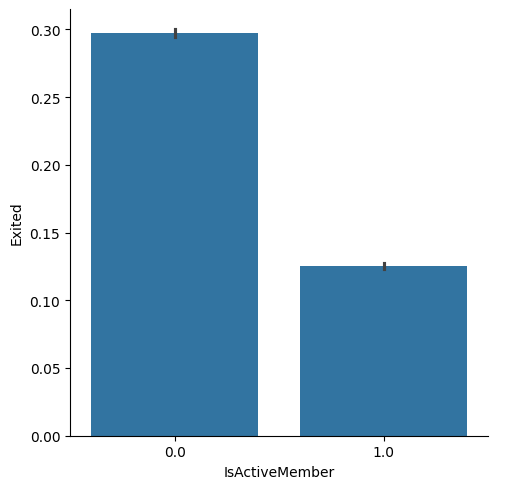

In [51]:
sns.catplot(cat_variables, kind='bar', x='Geography', y='Exited')
sns.catplot(cat_variables, kind='bar', x='Gender', y='Exited')
sns.catplot(cat_variables, kind='bar', x='HasCrCard', y='Exited')
sns.catplot(cat_variables, kind='bar', x='IsActiveMember', y='Exited')

### Models

#### Preprocessing

In [3]:
cat_variables_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
num_variables_cols = df.select_dtypes(['int64', 'float64']).drop(['HasCrCard', 'IsActiveMember','Exited'], axis=1).columns.to_list()

In [4]:
preprocessor = ColumnTransformer([('num', StandardScaler(), num_variables_cols),
                                   ('cat', OneHotEncoder(), cat_variables_cols)], remainder='drop')

In [5]:
df_trans = preprocessor.set_params(cat__drop='first').fit_transform(df)
y_trans = df['Exited']
#sm = SMOTE(random_state=42)
#df_trans, y_trans = sm.fit_resample(df_trans, df['Exited'])

In [6]:
df_trans.shape

(165034, 11)

In [6]:
preprocessor.get_feature_names_out()

array(['num__CreditScore', 'num__Age', 'num__Tenure', 'num__Balance',
       'num__NumOfProducts', 'num__EstimatedSalary',
       'cat__Geography_Germany', 'cat__Geography_Spain',
       'cat__Gender_Male', 'cat__HasCrCard_1.0',
       'cat__IsActiveMember_1.0'], dtype=object)

In [7]:
feature_names = num_variables_cols + preprocessor.transformers_[1][1].get_feature_names_out().tolist()

In [8]:
feature_names

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male',
 'HasCrCard_1.0',
 'IsActiveMember_1.0']

In [24]:
df_trans.shape

(165034, 11)

#### Logistic Regression

In [73]:
lr_clf = LogisticRegression(random_state=123)

In [118]:
y_pred = cross_val_predict(lr_clf, X=df_trans, y=y_trans, cv=5, method='predict_proba')[:,1]
y_pred

array([0.08476614, 0.02387483, 0.13527336, ..., 0.04908126, 0.07018937,
       0.12922289])

In [119]:
y_pred_class = cross_val_predict(lr_clf, X=df_trans, y=df['Exited'], cv=5)
y_pred_class

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
df['Exited']

0         0
1         0
2         0
3         0
4         0
         ..
165029    0
165030    0
165031    0
165032    0
165033    1
Name: Exited, Length: 165034, dtype: int64

In [75]:
roc_auc_score(df['Exited'], y_pred)

0.8177321829957838

In [89]:
lr_clf.fit(X=df_trans, y=df['Exited'])

LogisticRegression(random_state=123)

In [135]:
sorted(list(zip(np.abs(lr_clf.coef_[0,:]), feature_names)), reverse=True)

[(0.747624506787646, 'IsActiveMember_1.0'),
 (0.6066381235918807, 'Geography_Germany'),
 (0.5214045931678126, 'Age'),
 (0.44414549863735225, 'Gender_Male'),
 (0.14953211505725977, 'HasCrCard_1.0'),
 (0.1201670889136894, 'NumOfProducts'),
 (0.08245105964517942, 'Balance'),
 (0.040859824089211946, 'Geography_Spain'),
 (0.035608185184065076, 'CreditScore'),
 (0.027290216092823196, 'Tenure'),
 (0.022222024218028102, 'EstimatedSalary')]

In [88]:
lr_clf.intercept_

array([0.35877309])

<Axes: xlabel='Balance', ylabel='Age'>

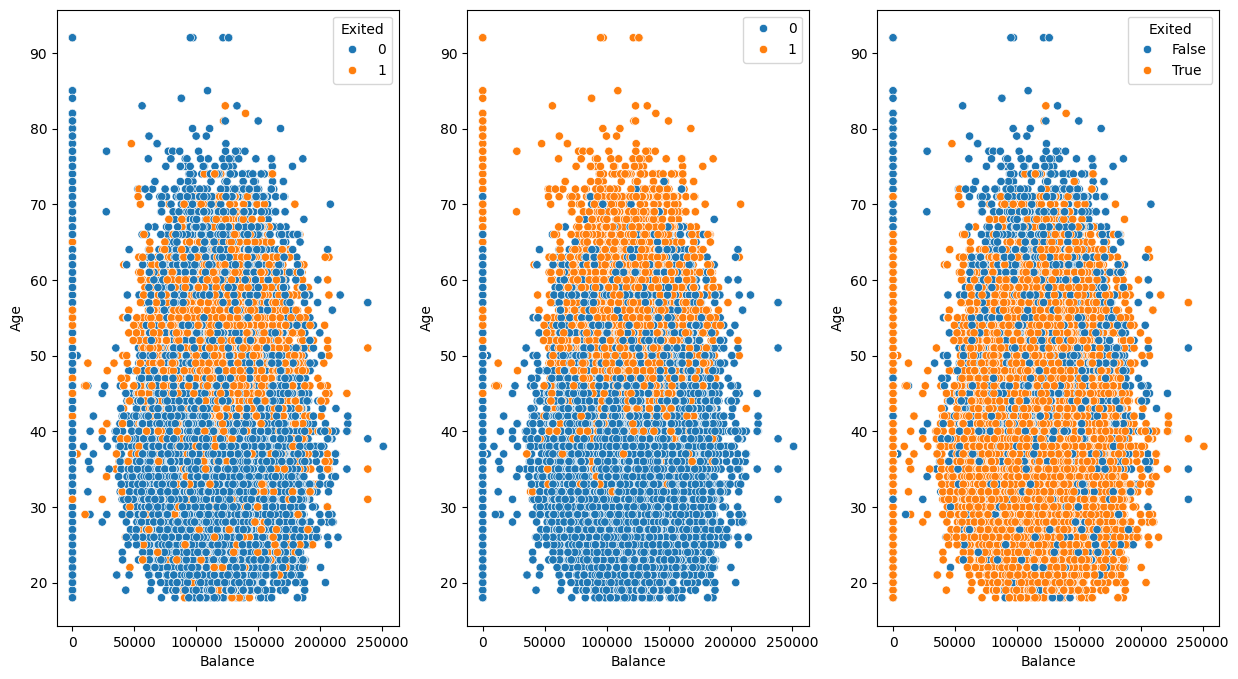

In [113]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue=df['Exited'], ax=ax[0])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class, ax=ax[1])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class==df['Exited'], ax=ax[2])

In [7]:
def compute_sample_weights(y_true, y_pred):
    samples_log_loss = []
    for true, pred in zip(y_true, y_pred):
        logloss = -1*(true * np.log(pred) + (1 - true) * np.log(1 - pred))
        logloss = 1 if logloss  < 3 else 5
        samples_log_loss.append(logloss)

    return samples_log_loss

sample_weights = compute_sample_weights(y_trans, y_pred)
sorted(sample_weights, reverse=True)

NameError: name 'y_pred' is not defined

#### Decision Tree

In [13]:
dt_clf = DecisionTreeClassifier(random_state=123, class_weight='balanced', max_depth=5, min_samples_leaf=5)

In [14]:
y_pred = cross_val_predict(dt_clf, X=df_trans, y=df['Exited'], cv=5, method='predict_proba')[:,1]
y_pred

array([0.10235465, 0.04286545, 0.10235465, ..., 0.23494085, 0.37984466,
       0.67668224])

In [24]:
y_pred_class = cross_val_predict(dt_clf, X=df_trans, y=df['Exited'], cv=5)
y_pred_class

array([0, 0, 0, ..., 0, 0, 1])

In [15]:
roc_auc_score(df['Exited'], y_pred)

0.8723730709048721

<Axes: xlabel='Balance', ylabel='Age'>

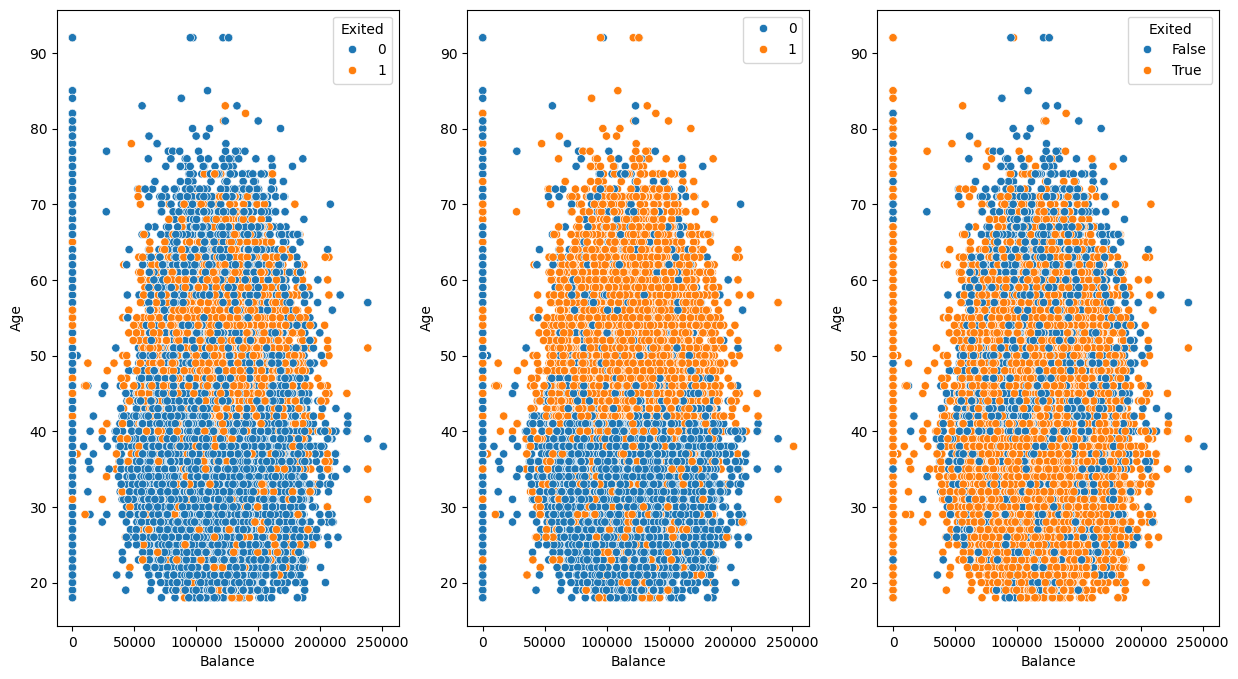

In [26]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue=df['Exited'], ax=ax[0])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class, ax=ax[1])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class==df['Exited'], ax=ax[2])

#### Random Forest Classifier

In [16]:
rf_clf = RandomForestClassifier(random_state=123, class_weight='balanced', max_depth=5)

In [17]:
y_pred = cross_val_predict(rf_clf, X=df_trans, y=df['Exited'], cv=5, method='predict_proba')[:,1]
y_pred

array([0.18304853, 0.10760637, 0.21053392, ..., 0.31750309, 0.36241714,
       0.46388632])

In [29]:
y_pred_class = cross_val_predict(rf_clf, X=df_trans, y=df['Exited'], cv=5)
y_pred_class

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
cross_val_score(rf_clf, X=df_trans, y=df['Exited'], cv=5, scoring='roc_auc').mean()

0.8756286403931204

In [19]:
roc_auc_score(df['Exited'], y_pred)

0.8755756167655836

<Axes: xlabel='Balance', ylabel='Age'>

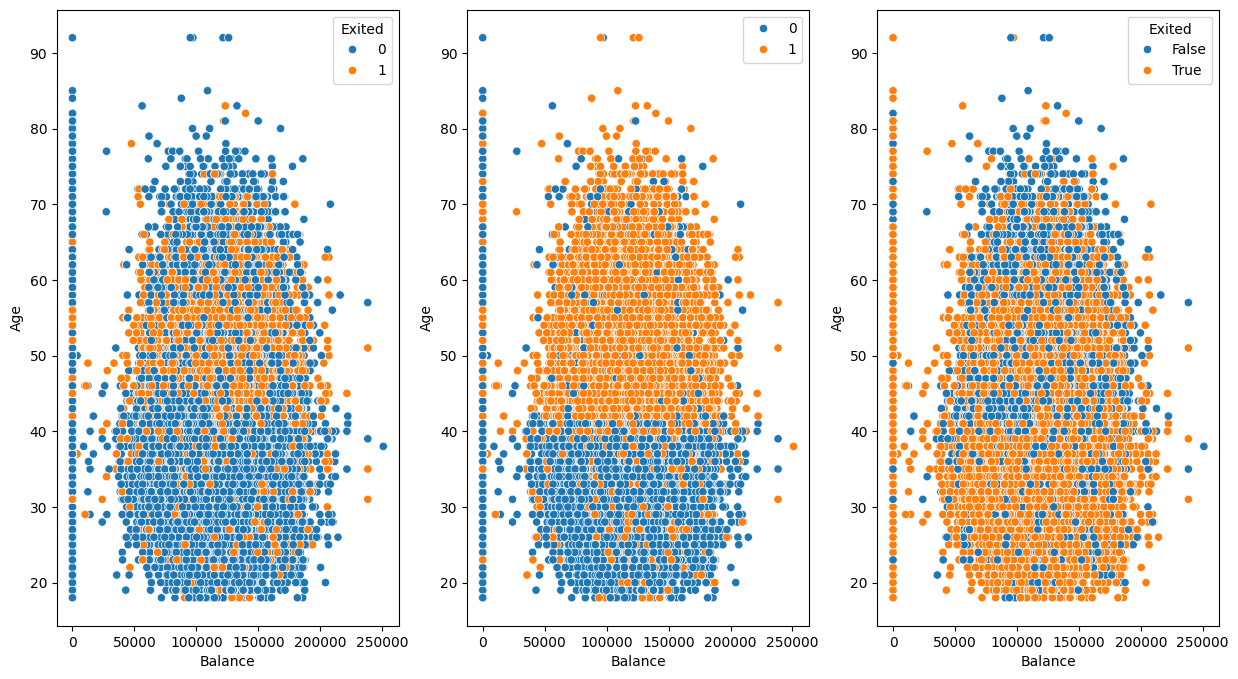

In [32]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
sns.scatterplot(num_variables, x='Balance', y='Age', hue=df['Exited'], ax=ax[0])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class, ax=ax[1])
sns.scatterplot(num_variables, x='Balance', y='Age', hue=y_pred_class==df['Exited'], ax=ax[2])

#### Hyperparameters optimization

In [115]:
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 12)
    min_samples_split = trial.suggest_float('min_samples_split', 0.01, 0.3)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.3)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Create the RandomForestClassifier with the suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        class_weight='balanced'
    )

    # Use cross-validation to evaluate the performance
    score = cross_val_score(clf, df_trans, df['Exited'], scoring='roc_auc', cv=5).mean()

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-01-07 19:15:55,158] A new study created in memory with name: no-name-52de58d8-6165-4e20-847a-a53bd4e01366
[W 2024-01-07 19:16:02,216] Trial 0 failed with parameters: {'n_estimators': 314, 'max_depth': 7, 'min_samples_split': 0.030517656980964487, 'min_samples_leaf': 0.2192934999835897, 'max_features': None} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/estacio/Documents/kaggle-playground-s4e1/myenv/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_18574/150346867.py", line 21, in objective
    score = cross_val_score(clf, df_trans, df['Exited'], scoring='roc_auc', cv=5).mean()
  File "/home/estacio/Documents/kaggle-playground-s4e1/myenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 562, in cross_val_score
    cv_results = cross_validate(
  File "/home/estacio/Documents/kaggle-playground-s4e1/myenv/lib/python3.

KeyboardInterrupt: 

In [39]:
study.best_params

{'n_estimators': 461,
 'max_depth': 9,
 'min_samples_split': 0.21148560638243705,
 'min_samples_leaf': 0.2722275069615257,
 'max_features': 'log2'}

In [ ]:
study.best_trial

FrozenTrial(number=492, state=TrialState.COMPLETE, values=[0.8643607990539763], datetime_start=datetime.datetime(2024, 1, 5, 21, 49, 4, 418948), datetime_complete=datetime.datetime(2024, 1, 5, 21, 49, 47, 539919), params={'n_estimators': 155, 'max_depth': 31, 'min_samples_split': 0.010295743725836934, 'min_samples_leaf': 0.010012320708820526, 'max_features': 'log2'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=500, log=False, low=100, step=1), 'max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'min_samples_split': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'min_samples_leaf': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None))}, trial_id=492, value=None)

In [25]:
rf_clf_optuna = RandomForestClassifier(random_state=42, n_estimators=461, max_depth=9, min_samples_leaf=0.2722275069615257, min_samples_split=0.21148560638243705, max_features='log2')

#### XGBoost

In [20]:
#xgb_clf = xgb.XGBClassifier(scale_pos_weight=sum(df['Exited']==0)/sum(df['Exited']==1))
xgb_clf = xgb.XGBClassifier()

score = cross_val_score(xgb_clf, df_trans, y_trans, cv=5, scoring='roc_auc').mean()

In [21]:
score

0.8866311352594721

In [60]:
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [20]:
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    scale_pos_weight = sum(df['Exited']==0)/sum(df['Exited']==1)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 5)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 5)

    # Create the RandomForestClassifier with the suggested hyperparameters
    clf = xgb.XGBClassifier(eval_metric=roc_auc_score,
                            scale_pos_weight=scale_pos_weight,
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            gamma=gamma,
                            reg_lambda=reg_lambda,
                            reg_alpha=reg_alpha)
    
    # Use cross-validation to evaluate the performance
    kf = KFold(n_splits=5)
    scores = []
    for i, (train_index, test_index) in enumerate(kf.split(df_trans)):
        print(f'Fold {i}')
        y_pred = clf.fit(df_trans[train_index], y_trans[train_index]).predict_proba(df_trans[test_index])[:,1]
        scores.append(roc_auc_score(y_trans[test_index], y_pred))
    
    score = np.mean(scores)
    
    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

[I 2024-01-13 11:25:57,489] A new study created in memory with name: no-name-505974bf-f954-46c3-a51d-5b3f352488e4


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:03,471] Trial 0 finished with value: 0.8848933872403467 and parameters: {'n_estimators': 139, 'max_depth': 12, 'learning_rate': 0.00906759237476414, 'subsample': 0.8152408636048358, 'colsample_bytree': 0.5144836142862736, 'gamma': 0.7760386601486263, 'reg_lambda': 1.4094829772100759, 'reg_alpha': 3.4523752163971704}. Best is trial 0 with value: 0.8848933872403467.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:06,538] Trial 1 finished with value: 0.8722459852096295 and parameters: {'n_estimators': 186, 'max_depth': 10, 'learning_rate': 0.0025446119905587162, 'subsample': 0.3183699770436396, 'colsample_bytree': 0.3451676407645173, 'gamma': 0.5056472944664553, 'reg_lambda': 3.6070956361043365, 'reg_alpha': 4.748220305075829}. Best is trial 0 with value: 0.8848933872403467.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:09,090] Trial 2 finished with value: 0.8882136649001842 and parameters: {'n_estimators': 162, 'max_depth': 5, 'learning_rate': 0.02225907577250745, 'subsample': 0.8456508739124976, 'colsample_bytree': 0.9675576618668712, 'gamma': 0.9871497102232374, 'reg_lambda': 0.8573734397369015, 'reg_alpha': 0.5329750639960917}. Best is trial 2 with value: 0.8882136649001842.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:13,061] Trial 3 finished with value: 0.8891593918969274 and parameters: {'n_estimators': 226, 'max_depth': 7, 'learning_rate': 0.0827454242959187, 'subsample': 0.6095288720121516, 'colsample_bytree': 0.5228168085753494, 'gamma': 0.641566452926209, 'reg_lambda': 2.859297155725483, 'reg_alpha': 2.3875216048239034}. Best is trial 3 with value: 0.8891593918969274.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:17,486] Trial 4 finished with value: 0.8836881946297455 and parameters: {'n_estimators': 252, 'max_depth': 8, 'learning_rate': 0.0907218489614421, 'subsample': 0.6440952397462089, 'colsample_bytree': 0.8443957148665943, 'gamma': 0.048045663713570885, 'reg_lambda': 0.40865188991591916, 'reg_alpha': 0.20883709503449643}. Best is trial 3 with value: 0.8891593918969274.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:19,667] Trial 5 finished with value: 0.8898623108217297 and parameters: {'n_estimators': 241, 'max_depth': 4, 'learning_rate': 0.07965888202080636, 'subsample': 0.7797278019240254, 'colsample_bytree': 0.46772411549369886, 'gamma': 0.33746434447121865, 'reg_lambda': 4.192996368776914, 'reg_alpha': 4.933065084803468}. Best is trial 5 with value: 0.8898623108217297.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:22,118] Trial 6 finished with value: 0.8699787044200604 and parameters: {'n_estimators': 269, 'max_depth': 5, 'learning_rate': 0.0013436245922934804, 'subsample': 0.29628884646986053, 'colsample_bytree': 0.22381041637394578, 'gamma': 0.23014443996594347, 'reg_lambda': 1.2142958006055382, 'reg_alpha': 0.3669547900701553}. Best is trial 5 with value: 0.8898623108217297.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:25,200] Trial 7 finished with value: 0.8893837494877636 and parameters: {'n_estimators': 244, 'max_depth': 6, 'learning_rate': 0.019080847370585293, 'subsample': 0.4735458734734873, 'colsample_bytree': 0.6509210342933082, 'gamma': 0.5965952530737536, 'reg_lambda': 3.8118975232080525, 'reg_alpha': 0.2849640268099496}. Best is trial 5 with value: 0.8898623108217297.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:28,482] Trial 8 finished with value: 0.8894010033319786 and parameters: {'n_estimators': 280, 'max_depth': 6, 'learning_rate': 0.05874130231209562, 'subsample': 0.42785655488103236, 'colsample_bytree': 0.8158230514797685, 'gamma': 0.2979571181384153, 'reg_lambda': 1.9900448886138022, 'reg_alpha': 3.290695136839391}. Best is trial 5 with value: 0.8898623108217297.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:34,798] Trial 9 finished with value: 0.8863910365710772 and parameters: {'n_estimators': 199, 'max_depth': 9, 'learning_rate': 0.06048246055913217, 'subsample': 0.32855745632331057, 'colsample_bytree': 0.9848996602110884, 'gamma': 0.1611787426945338, 'reg_lambda': 3.8955950461526854, 'reg_alpha': 4.149697482383843}. Best is trial 5 with value: 0.8898623108217297.


Fold 0
Fold 1
Fold 2
Fold 3


[I 2024-01-13 11:26:35,780] Trial 10 finished with value: 0.8529929105711892 and parameters: {'n_estimators': 63, 'max_depth': 3, 'learning_rate': 0.07452763601224423, 'subsample': 0.11795794422215206, 'colsample_bytree': 0.10989553089445203, 'gamma': 0.3751590076456581, 'reg_lambda': 4.961919451687207, 'reg_alpha': 2.289559231040764}. Best is trial 5 with value: 0.8898623108217297.


Fold 4
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:38,146] Trial 11 finished with value: 0.8886699410004901 and parameters: {'n_estimators': 283, 'max_depth': 3, 'learning_rate': 0.04517622767849698, 'subsample': 0.9916434219900787, 'colsample_bytree': 0.7224635455398815, 'gamma': 0.3318391194949191, 'reg_lambda': 2.2493386102415274, 'reg_alpha': 3.3778573783736863}. Best is trial 5 with value: 0.8898623108217297.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:45,208] Trial 12 finished with value: 0.8891937443137845 and parameters: {'n_estimators': 298, 'max_depth': 5, 'learning_rate': 0.05249272602122392, 'subsample': 0.49338150564732824, 'colsample_bytree': 0.41811022288737426, 'gamma': 0.3713338279746632, 'reg_lambda': 2.0840952657882332, 'reg_alpha': 4.835590513224902}. Best is trial 5 with value: 0.8898623108217297.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:47,640] Trial 13 finished with value: 0.8899146294572755 and parameters: {'n_estimators': 220, 'max_depth': 4, 'learning_rate': 0.09944741495069527, 'subsample': 0.7465533316000482, 'colsample_bytree': 0.7141368049430349, 'gamma': 0.01909775709585726, 'reg_lambda': 4.73015186330378, 'reg_alpha': 1.5526043522028634}. Best is trial 13 with value: 0.8899146294572755.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:50,230] Trial 14 finished with value: 0.8892282100817066 and parameters: {'n_estimators': 217, 'max_depth': 3, 'learning_rate': 0.09646576176007411, 'subsample': 0.7415925394906352, 'colsample_bytree': 0.642902177799706, 'gamma': 0.05908713397036347, 'reg_lambda': 4.673216480420626, 'reg_alpha': 1.4028464860119922}. Best is trial 13 with value: 0.8899146294572755.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:51,928] Trial 15 finished with value: 0.887433491690464 and parameters: {'n_estimators': 124, 'max_depth': 4, 'learning_rate': 0.07443680466668563, 'subsample': 0.9407958630772524, 'colsample_bytree': 0.39441401329769477, 'gamma': 0.13111826314874056, 'reg_lambda': 4.321239860888203, 'reg_alpha': 1.4166710262121631}. Best is trial 13 with value: 0.8899146294572755.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:54,070] Trial 16 finished with value: 0.8899380315710881 and parameters: {'n_estimators': 224, 'max_depth': 4, 'learning_rate': 0.0970136903358918, 'subsample': 0.7079735475539354, 'colsample_bytree': 0.6143134397500618, 'gamma': 0.4753878875018236, 'reg_lambda': 3.0734545760047234, 'reg_alpha': 1.5088848558101595}. Best is trial 16 with value: 0.8899380315710881.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:56,939] Trial 17 finished with value: 0.8895394786907614 and parameters: {'n_estimators': 156, 'max_depth': 6, 'learning_rate': 0.0995505624398519, 'subsample': 0.6550701556276235, 'colsample_bytree': 0.680212340000496, 'gamma': 0.8269829135262683, 'reg_lambda': 3.099813213381638, 'reg_alpha': 1.4728206975445715}. Best is trial 16 with value: 0.8899380315710881.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:26:59,350] Trial 18 finished with value: 0.8890186677251986 and parameters: {'n_estimators': 101, 'max_depth': 8, 'learning_rate': 0.039247357579623686, 'subsample': 0.8957538472399641, 'colsample_bytree': 0.802153579987916, 'gamma': 0.477983183786698, 'reg_lambda': 3.2559470298130693, 'reg_alpha': 1.9393731482065621}. Best is trial 16 with value: 0.8899380315710881.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:02,398] Trial 19 finished with value: 0.8899742522677686 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.08868656206050161, 'subsample': 0.7117240628370716, 'colsample_bytree': 0.5556675232880663, 'gamma': 0.7460004363506858, 'reg_lambda': 2.731867809192363, 'reg_alpha': 1.0110808038190988}. Best is trial 19 with value: 0.8899742522677686.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:12,053] Trial 20 finished with value: 0.883695310923688 and parameters: {'n_estimators': 195, 'max_depth': 11, 'learning_rate': 0.0877194576418628, 'subsample': 0.5841589319847934, 'colsample_bytree': 0.6037658657263603, 'gamma': 0.7227332082882054, 'reg_lambda': 2.819055822394696, 'reg_alpha': 0.9511146516674029}. Best is trial 19 with value: 0.8899742522677686.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:14,171] Trial 21 finished with value: 0.8898258800890636 and parameters: {'n_estimators': 215, 'max_depth': 4, 'learning_rate': 0.06792582713636125, 'subsample': 0.7148764666915759, 'colsample_bytree': 0.7555437013005105, 'gamma': 0.9492220109757692, 'reg_lambda': 2.534475106767805, 'reg_alpha': 1.091355311719497}. Best is trial 19 with value: 0.8899742522677686.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:16,071] Trial 22 finished with value: 0.8898653290456007 and parameters: {'n_estimators': 185, 'max_depth': 4, 'learning_rate': 0.0917213480746921, 'subsample': 0.6881923004095005, 'colsample_bytree': 0.5711011286064964, 'gamma': 0.8893695949652275, 'reg_lambda': 1.6797764213267514, 'reg_alpha': 1.7654706596728784}. Best is trial 19 with value: 0.8899742522677686.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:18,978] Trial 23 finished with value: 0.8873527676496673 and parameters: {'n_estimators': 214, 'max_depth': 7, 'learning_rate': 0.0999085776796676, 'subsample': 0.5493298121280291, 'colsample_bytree': 0.3102545212190412, 'gamma': 0.4874259044793919, 'reg_lambda': 3.194064967278064, 'reg_alpha': 0.8427044938857509}. Best is trial 19 with value: 0.8899742522677686.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:21,190] Trial 24 finished with value: 0.8900524459342851 and parameters: {'n_estimators': 168, 'max_depth': 5, 'learning_rate': 0.08470109926206469, 'subsample': 0.8571289627224326, 'colsample_bytree': 0.5764241331251808, 'gamma': 0.6729598039810016, 'reg_lambda': 3.5347807719650146, 'reg_alpha': 1.9607062672540874}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:23,255] Trial 25 finished with value: 0.8899242125289563 and parameters: {'n_estimators': 167, 'max_depth': 5, 'learning_rate': 0.08703646293988486, 'subsample': 0.8446762865315179, 'colsample_bytree': 0.48098355338869003, 'gamma': 0.6581263403564248, 'reg_lambda': 3.6488756375502303, 'reg_alpha': 2.803827927632728}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:24,629] Trial 26 finished with value: 0.8879652790881198 and parameters: {'n_estimators': 142, 'max_depth': 3, 'learning_rate': 0.06911836595699666, 'subsample': 0.9082639831132621, 'colsample_bytree': 0.5758329122492287, 'gamma': 0.5664790594355968, 'reg_lambda': 2.551964091313164, 'reg_alpha': 2.8698581475795617}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:26,418] Trial 27 finished with value: 0.8897946286930271 and parameters: {'n_estimators': 114, 'max_depth': 6, 'learning_rate': 0.07963524235414426, 'subsample': 0.8010100571505883, 'colsample_bytree': 0.6159273571217294, 'gamma': 0.7302433606485339, 'reg_lambda': 3.492969958876943, 'reg_alpha': 1.9564357605894855}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:28,700] Trial 28 finished with value: 0.8861001472504159 and parameters: {'n_estimators': 84, 'max_depth': 5, 'learning_rate': 0.036796841027624386, 'subsample': 0.7012479946996171, 'colsample_bytree': 0.4673487359708195, 'gamma': 0.8085259396189861, 'reg_lambda': 4.123054768134761, 'reg_alpha': 2.153017940988711}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:32,281] Trial 29 finished with value: 0.8894404607128201 and parameters: {'n_estimators': 135, 'max_depth': 7, 'learning_rate': 0.06685438296777844, 'subsample': 0.8346905444390156, 'colsample_bytree': 0.5367479323574977, 'gamma': 0.7089907485617992, 'reg_lambda': 2.9362802523161555, 'reg_alpha': 2.6683599865812244}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:35,261] Trial 30 finished with value: 0.8856017970576948 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.09234720656899516, 'subsample': 0.9623807296923373, 'colsample_bytree': 0.309369484416985, 'gamma': 0.8448397134394497, 'reg_lambda': 1.6057228811528441, 'reg_alpha': 0.6395375331108224}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:37,165] Trial 31 finished with value: 0.8898518029721305 and parameters: {'n_estimators': 172, 'max_depth': 5, 'learning_rate': 0.08588237795545402, 'subsample': 0.8683328190420572, 'colsample_bytree': 0.4684110106606714, 'gamma': 0.6221952780191212, 'reg_lambda': 3.496357586791661, 'reg_alpha': 3.0583013318830683}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:39,091] Trial 32 finished with value: 0.8899345061212397 and parameters: {'n_estimators': 174, 'max_depth': 5, 'learning_rate': 0.0844739093838146, 'subsample': 0.7950596885316991, 'colsample_bytree': 0.5069966401914099, 'gamma': 0.6715155177531692, 'reg_lambda': 3.652446676508863, 'reg_alpha': 3.933619174700233}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:41,438] Trial 33 finished with value: 0.8898183481470318 and parameters: {'n_estimators': 186, 'max_depth': 6, 'learning_rate': 0.08011276500639417, 'subsample': 0.774735730249491, 'colsample_bytree': 0.531212170520041, 'gamma': 0.5393406721381129, 'reg_lambda': 3.3382258040070227, 'reg_alpha': 4.50624698127186}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:43,245] Trial 34 finished with value: 0.8865271029629236 and parameters: {'n_estimators': 203, 'max_depth': 3, 'learning_rate': 0.07354350725215497, 'subsample': 0.8053031162561487, 'colsample_bytree': 0.35866314057115717, 'gamma': 0.4359155742862452, 'reg_lambda': 2.7084551007518987, 'reg_alpha': 3.771345634664102}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:52,297] Trial 35 finished with value: 0.8807511962318826 and parameters: {'n_estimators': 176, 'max_depth': 12, 'learning_rate': 0.09230375932332546, 'subsample': 0.6233634148725989, 'colsample_bytree': 0.5754200573286364, 'gamma': 0.7691345950826207, 'reg_lambda': 2.36632653451044, 'reg_alpha': 0.005986131894413216}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:55,823] Trial 36 finished with value: 0.889600205735994 and parameters: {'n_estimators': 230, 'max_depth': 5, 'learning_rate': 0.08417037122780922, 'subsample': 0.676745610998044, 'colsample_bytree': 0.9022901255009259, 'gamma': 0.6804384750165929, 'reg_lambda': 3.927070334307186, 'reg_alpha': 1.0781123380783684}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:27:59,433] Trial 37 finished with value: 0.8894722885964768 and parameters: {'n_estimators': 254, 'max_depth': 4, 'learning_rate': 0.09391728975177795, 'subsample': 0.5853207852939355, 'colsample_bytree': 0.4046015857264453, 'gamma': 0.5487018680264432, 'reg_lambda': 3.0492376227861633, 'reg_alpha': 3.7761380611978472}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:03,499] Trial 38 finished with value: 0.8899683551202688 and parameters: {'n_estimators': 235, 'max_depth': 5, 'learning_rate': 0.07786622962246162, 'subsample': 0.7490668684417221, 'colsample_bytree': 0.5026947770990557, 'gamma': 0.9106680611999907, 'reg_lambda': 0.5383818170235779, 'reg_alpha': 2.433400800059203}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:07,248] Trial 39 finished with value: 0.8891836336467398 and parameters: {'n_estimators': 231, 'max_depth': 7, 'learning_rate': 0.06211471103407526, 'subsample': 0.7355434313692906, 'colsample_bytree': 0.6699892839659324, 'gamma': 0.8979369960315707, 'reg_lambda': 0.17412884591797573, 'reg_alpha': 2.5468924031514906}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:10,251] Trial 40 finished with value: 0.8846692532455036 and parameters: {'n_estimators': 260, 'max_depth': 6, 'learning_rate': 0.07889156403091308, 'subsample': 0.5207871818117364, 'colsample_bytree': 0.23035957631270376, 'gamma': 0.9725446656532946, 'reg_lambda': 1.3853100444436988, 'reg_alpha': 1.8548489549908944}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:13,763] Trial 41 finished with value: 0.889990662662181 and parameters: {'n_estimators': 203, 'max_depth': 5, 'learning_rate': 0.08760443176248277, 'subsample': 0.7766814950197114, 'colsample_bytree': 0.5049839721530672, 'gamma': 0.7826061166955485, 'reg_lambda': 3.633549371518735, 'reg_alpha': 2.200307669877661}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:17,141] Trial 42 finished with value: 0.8894914360264862 and parameters: {'n_estimators': 236, 'max_depth': 5, 'learning_rate': 0.08915846048642125, 'subsample': 0.8816947231732097, 'colsample_bytree': 0.43121485737411724, 'gamma': 0.8713752097093643, 'reg_lambda': 1.8960118076289607, 'reg_alpha': 2.209939350430862}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:23,425] Trial 43 finished with value: 0.8856720266320073 and parameters: {'n_estimators': 202, 'max_depth': 4, 'learning_rate': 0.013275045970598212, 'subsample': 0.6428543348053342, 'colsample_bytree': 0.614427002828895, 'gamma': 0.9291429815532529, 'reg_lambda': 0.7867546089083344, 'reg_alpha': 1.6692030031564316}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:29,497] Trial 44 finished with value: 0.8875595932603189 and parameters: {'n_estimators': 244, 'max_depth': 9, 'learning_rate': 0.0761238769226809, 'subsample': 0.777146176896531, 'colsample_bytree': 0.5095083185896346, 'gamma': 0.7810847591981797, 'reg_lambda': 0.6329649941174827, 'reg_alpha': 2.1092303077764654}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:31,234] Trial 45 finished with value: 0.8893175368358974 and parameters: {'n_estimators': 210, 'max_depth': 3, 'learning_rate': 0.09537962794150333, 'subsample': 0.8510884958586644, 'colsample_bytree': 0.5484876286071545, 'gamma': 0.9945351992124166, 'reg_lambda': 4.365995852560838, 'reg_alpha': 2.399760060834408}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:33,869] Trial 46 finished with value: 0.8891522629200492 and parameters: {'n_estimators': 194, 'max_depth': 6, 'learning_rate': 0.08248533268762051, 'subsample': 0.403806495385984, 'colsample_bytree': 0.7093959963738856, 'gamma': 0.7533554999000487, 'reg_lambda': 1.0202269382502722, 'reg_alpha': 1.2721059745555785}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:36,837] Trial 47 finished with value: 0.889172231132686 and parameters: {'n_estimators': 183, 'max_depth': 5, 'learning_rate': 0.0286810626008913, 'subsample': 0.7542738102910425, 'colsample_bytree': 0.6396416659717788, 'gamma': 0.5862408738135347, 'reg_lambda': 2.6902507190987124, 'reg_alpha': 0.5279627316292393}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:41,322] Trial 48 finished with value: 0.8889081734700348 and parameters: {'n_estimators': 264, 'max_depth': 4, 'learning_rate': 0.05457705259640787, 'subsample': 0.9244365071429559, 'colsample_bytree': 0.4440389936152858, 'gamma': 0.42605134394605704, 'reg_lambda': 0.03403302157187271, 'reg_alpha': 3.129433049357586}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:45,387] Trial 49 finished with value: 0.8899029876058331 and parameters: {'n_estimators': 273, 'max_depth': 4, 'learning_rate': 0.08952302280476297, 'subsample': 0.9823782967127119, 'colsample_bytree': 0.7628813871176006, 'gamma': 0.8022342769898815, 'reg_lambda': 2.272461751739734, 'reg_alpha': 1.2345372776932226}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:48,539] Trial 50 finished with value: 0.8890660688861278 and parameters: {'n_estimators': 244, 'max_depth': 3, 'learning_rate': 0.07137424727006435, 'subsample': 0.6695479672599798, 'colsample_bytree': 0.49999637652512485, 'gamma': 0.8538192264024028, 'reg_lambda': 4.0180687833965845, 'reg_alpha': 2.5029526440447336}. Best is trial 24 with value: 0.8900524459342851.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:53,084] Trial 51 finished with value: 0.8900765260703698 and parameters: {'n_estimators': 224, 'max_depth': 5, 'learning_rate': 0.08307417246598299, 'subsample': 0.8149920111693516, 'colsample_bytree': 0.5916312402680081, 'gamma': 0.626569100398226, 'reg_lambda': 3.688908351346634, 'reg_alpha': 1.5662609823942657}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:56,187] Trial 52 finished with value: 0.8900386792124054 and parameters: {'n_estimators': 227, 'max_depth': 5, 'learning_rate': 0.07794056849945939, 'subsample': 0.7391294758201434, 'colsample_bytree': 0.585339857909483, 'gamma': 0.6280527550011448, 'reg_lambda': 3.731301854779911, 'reg_alpha': 1.6194655061365921}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:28:59,339] Trial 53 finished with value: 0.8886857575350582 and parameters: {'n_estimators': 205, 'max_depth': 5, 'learning_rate': 0.06305646663187167, 'subsample': 0.10017745907025849, 'colsample_bytree': 0.5874531188284349, 'gamma': 0.6247173836877564, 'reg_lambda': 3.7575129903472924, 'reg_alpha': 1.9713538395986823}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:02,558] Trial 54 finished with value: 0.8899122701683659 and parameters: {'n_estimators': 192, 'max_depth': 6, 'learning_rate': 0.07773802285682768, 'subsample': 0.8277009522000416, 'colsample_bytree': 0.5577253143406637, 'gamma': 0.7101660693378835, 'reg_lambda': 4.44404165298688, 'reg_alpha': 1.67162610015905}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:05,824] Trial 55 finished with value: 0.8897155715150076 and parameters: {'n_estimators': 222, 'max_depth': 6, 'learning_rate': 0.07216227481548326, 'subsample': 0.7406181421625577, 'colsample_bytree': 0.6700036264135856, 'gamma': 0.6138999673961114, 'reg_lambda': 3.293617473573765, 'reg_alpha': 0.7929571104442994}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:09,071] Trial 56 finished with value: 0.8877135430799097 and parameters: {'n_estimators': 163, 'max_depth': 7, 'learning_rate': 0.08232331295701506, 'subsample': 0.1998622371712947, 'colsample_bytree': 0.38035647577484055, 'gamma': 0.6792516521883174, 'reg_lambda': 4.204713646774865, 'reg_alpha': 2.29726906122229}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:14,717] Trial 57 finished with value: 0.8891579109412397 and parameters: {'n_estimators': 235, 'max_depth': 5, 'learning_rate': 0.06623883801516928, 'subsample': 0.8682384198232538, 'colsample_bytree': 0.44614506499936657, 'gamma': 0.919884889723412, 'reg_lambda': 4.562643972356163, 'reg_alpha': 1.3610624419348598}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:22,437] Trial 58 finished with value: 0.8893600555854487 and parameters: {'n_estimators': 253, 'max_depth': 8, 'learning_rate': 0.056685702137179064, 'subsample': 0.77128502033425, 'colsample_bytree': 0.534830361865197, 'gamma': 0.7921708312385192, 'reg_lambda': 3.474642327207531, 'reg_alpha': 1.6630436558315185}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:24,761] Trial 59 finished with value: 0.8891457667640914 and parameters: {'n_estimators': 212, 'max_depth': 4, 'learning_rate': 0.04829852910469483, 'subsample': 0.8189968813312064, 'colsample_bytree': 0.4894914192586769, 'gamma': 0.5251593085260162, 'reg_lambda': 3.9945228526880525, 'reg_alpha': 2.0751819016631834}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:27,883] Trial 60 finished with value: 0.8899389801940227 and parameters: {'n_estimators': 219, 'max_depth': 5, 'learning_rate': 0.07630024079524515, 'subsample': 0.7172549207895552, 'colsample_bytree': 0.6941208331323809, 'gamma': 0.7481545389963955, 'reg_lambda': 3.779732824411007, 'reg_alpha': 1.1753108081247823}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:30,997] Trial 61 finished with value: 0.8900201804964644 and parameters: {'n_estimators': 223, 'max_depth': 5, 'learning_rate': 0.08144352464614177, 'subsample': 0.7192525439372545, 'colsample_bytree': 0.6314306287633613, 'gamma': 0.7466941187673789, 'reg_lambda': 3.7876301012099804, 'reg_alpha': 1.0825675408900304}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:34,442] Trial 62 finished with value: 0.8897032177303672 and parameters: {'n_estimators': 227, 'max_depth': 5, 'learning_rate': 0.08787493968476223, 'subsample': 0.6126925766413709, 'colsample_bytree': 0.6373184911278755, 'gamma': 0.6397122272541675, 'reg_lambda': 3.5892856785219087, 'reg_alpha': 1.543762200676689}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:38,391] Trial 63 finished with value: 0.8892807717258331 and parameters: {'n_estimators': 241, 'max_depth': 6, 'learning_rate': 0.08088882791197378, 'subsample': 0.717332891991017, 'colsample_bytree': 0.7487609618305238, 'gamma': 0.6945005538511432, 'reg_lambda': 3.395711099686109, 'reg_alpha': 0.9554820305311298}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:40,661] Trial 64 finished with value: 0.8899985930515536 and parameters: {'n_estimators': 197, 'max_depth': 4, 'learning_rate': 0.08623628911872043, 'subsample': 0.9439339126948049, 'colsample_bytree': 0.597314663831026, 'gamma': 0.8268934688243111, 'reg_lambda': 4.185974961784807, 'reg_alpha': 1.841254402029357}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:43,712] Trial 65 finished with value: 0.8898858346053006 and parameters: {'n_estimators': 209, 'max_depth': 4, 'learning_rate': 0.08561519601197216, 'subsample': 0.9275568752961485, 'colsample_bytree': 0.6070690984733162, 'gamma': 0.8363184640030968, 'reg_lambda': 4.161848412399964, 'reg_alpha': 1.831814323966045}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:47,186] Trial 66 finished with value: 0.8898562867263611 and parameters: {'n_estimators': 181, 'max_depth': 4, 'learning_rate': 0.0962698316203938, 'subsample': 0.9004238458920697, 'colsample_bytree': 0.6544154328973802, 'gamma': 0.5835324997262862, 'reg_lambda': 4.782057779545092, 'reg_alpha': 0.5182041462446669}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:50,591] Trial 67 finished with value: 0.8890514515865844 and parameters: {'n_estimators': 197, 'max_depth': 3, 'learning_rate': 0.0913321456936474, 'subsample': 0.9561863707696727, 'colsample_bytree': 0.5892160335019326, 'gamma': 0.7385450445669354, 'reg_lambda': 3.8284820311197008, 'reg_alpha': 1.4001362304286638}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:53,410] Trial 68 finished with value: 0.8900003220623889 and parameters: {'n_estimators': 157, 'max_depth': 5, 'learning_rate': 0.08347257101178136, 'subsample': 0.8022261769132009, 'colsample_bytree': 0.6294202277788153, 'gamma': 0.6489868790013459, 'reg_lambda': 3.147782717425346, 'reg_alpha': 0.7246617250894511}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:55,851] Trial 69 finished with value: 0.8898907922370498 and parameters: {'n_estimators': 146, 'max_depth': 6, 'learning_rate': 0.08427736860627807, 'subsample': 0.9999426959052621, 'colsample_bytree': 0.6333139076135478, 'gamma': 0.6571274102190454, 'reg_lambda': 3.1463172129006387, 'reg_alpha': 0.7172403086331207}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:57,713] Trial 70 finished with value: 0.8897733869750857 and parameters: {'n_estimators': 130, 'max_depth': 5, 'learning_rate': 0.06938040423574128, 'subsample': 0.8105076996464015, 'colsample_bytree': 0.6960352434039914, 'gamma': 0.8208641676519222, 'reg_lambda': 3.6755216018086263, 'reg_alpha': 1.7418231732335123}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:29:59,585] Trial 71 finished with value: 0.8897603104261478 and parameters: {'n_estimators': 162, 'max_depth': 4, 'learning_rate': 0.08874634785073718, 'subsample': 0.8448517532094886, 'colsample_bytree': 0.5648967837936489, 'gamma': 0.7701798669722837, 'reg_lambda': 2.937332900719683, 'reg_alpha': 0.9747115006074818}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:01,967] Trial 72 finished with value: 0.8899362402730201 and parameters: {'n_estimators': 190, 'max_depth': 5, 'learning_rate': 0.08189278383647731, 'subsample': 0.7860725264760942, 'colsample_bytree': 0.5404035377002555, 'gamma': 0.7267370434306206, 'reg_lambda': 3.5816156999673714, 'reg_alpha': 0.39951655580944845}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:04,069] Trial 73 finished with value: 0.8896990425969614 and parameters: {'n_estimators': 158, 'max_depth': 4, 'learning_rate': 0.08604554351777415, 'subsample': 0.8846455428578639, 'colsample_bytree': 0.736417139355248, 'gamma': 0.6989557758473637, 'reg_lambda': 3.914963866719969, 'reg_alpha': 1.114616264717505}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:10,638] Trial 74 finished with value: 0.8859780508487999 and parameters: {'n_estimators': 169, 'max_depth': 10, 'learning_rate': 0.09384952975224552, 'subsample': 0.8520739957552941, 'colsample_bytree': 0.61222760387183, 'gamma': 0.6521831513922824, 'reg_lambda': 3.3860325112042333, 'reg_alpha': 0.20048234363584916}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:13,982] Trial 75 finished with value: 0.8897719868161198 and parameters: {'n_estimators': 152, 'max_depth': 5, 'learning_rate': 0.0900711640026287, 'subsample': 0.6953567486620672, 'colsample_bytree': 0.787380730404573, 'gamma': 0.6094473632851397, 'reg_lambda': 2.7605631021406305, 'reg_alpha': 1.5352529376287791}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:17,232] Trial 76 finished with value: 0.8898380427827666 and parameters: {'n_estimators': 178, 'max_depth': 5, 'learning_rate': 0.0982460390643977, 'subsample': 0.7686853785445047, 'colsample_bytree': 0.6549751529851402, 'gamma': 0.7648964933511212, 'reg_lambda': 3.0372137881326946, 'reg_alpha': 1.9776580955846457}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:19,950] Trial 77 finished with value: 0.8898228967435642 and parameters: {'n_estimators': 201, 'max_depth': 4, 'learning_rate': 0.075752135036733, 'subsample': 0.6489354271873876, 'colsample_bytree': 0.5852063896548872, 'gamma': 0.5639182830207998, 'reg_lambda': 4.042779607234288, 'reg_alpha': 0.8484600983407162}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:23,187] Trial 78 finished with value: 0.8899016937391362 and parameters: {'n_estimators': 218, 'max_depth': 6, 'learning_rate': 0.08039439958860099, 'subsample': 0.9213047876798568, 'colsample_bytree': 0.5256625046323736, 'gamma': 0.5075931946539517, 'reg_lambda': 4.203455888872897, 'reg_alpha': 1.3221184358833287}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:25,124] Trial 79 finished with value: 0.888778431170649 and parameters: {'n_estimators': 189, 'max_depth': 3, 'learning_rate': 0.0836534679248061, 'subsample': 0.9572828262834059, 'colsample_bytree': 0.554692666050376, 'gamma': 0.7183657184055029, 'reg_lambda': 3.2249137165911788, 'reg_alpha': 2.6811360518238825}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:28,170] Trial 80 finished with value: 0.8900253376767442 and parameters: {'n_estimators': 207, 'max_depth': 5, 'learning_rate': 0.09328062541964324, 'subsample': 0.7979810478729085, 'colsample_bytree': 0.4653776253531595, 'gamma': 0.8555148642879713, 'reg_lambda': 3.775340293356686, 'reg_alpha': 1.011149132279468}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:31,366] Trial 81 finished with value: 0.8900450000805937 and parameters: {'n_estimators': 222, 'max_depth': 5, 'learning_rate': 0.09327572966630703, 'subsample': 0.8003020836726799, 'colsample_bytree': 0.46185521633944226, 'gamma': 0.8798780815945296, 'reg_lambda': 3.7744208995786166, 'reg_alpha': 0.6650083911168916}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:34,475] Trial 82 finished with value: 0.8900456569988806 and parameters: {'n_estimators': 209, 'max_depth': 5, 'learning_rate': 0.09383080690736571, 'subsample': 0.7992477547652793, 'colsample_bytree': 0.45889107306278903, 'gamma': 0.8733040824170009, 'reg_lambda': 3.7547765228860093, 'reg_alpha': 2.272634578156371}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:37,957] Trial 83 finished with value: 0.8898064661002778 and parameters: {'n_estimators': 226, 'max_depth': 6, 'learning_rate': 0.09468183627339971, 'subsample': 0.8127039493943997, 'colsample_bytree': 0.47390378736345334, 'gamma': 0.8596317270066273, 'reg_lambda': 4.308063125215989, 'reg_alpha': 0.6237950757253758}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:41,162] Trial 84 finished with value: 0.8893045399689508 and parameters: {'n_estimators': 208, 'max_depth': 5, 'learning_rate': 0.09841478827579794, 'subsample': 0.8601066598121839, 'colsample_bytree': 0.4138103636665563, 'gamma': 0.9644198207286638, 'reg_lambda': 3.827954473945057, 'reg_alpha': 0.3676157092954494}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:45,233] Trial 85 finished with value: 0.8892355186124797 and parameters: {'n_estimators': 214, 'max_depth': 5, 'learning_rate': 0.09252670186765577, 'subsample': 0.8263968216458525, 'colsample_bytree': 0.4533082025397511, 'gamma': 0.8785720217238218, 'reg_lambda': 3.5118554476935784, 'reg_alpha': 0.17554912019121316}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:49,400] Trial 86 finished with value: 0.8881631055648548 and parameters: {'n_estimators': 248, 'max_depth': 6, 'learning_rate': 0.09191223885879206, 'subsample': 0.7936940613310756, 'colsample_bytree': 0.33024213383531387, 'gamma': 0.9371260885451604, 'reg_lambda': 4.0852716142596925, 'reg_alpha': 0.8653864831492749}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:51,282] Trial 87 finished with value: 0.8803271111210247 and parameters: {'n_estimators': 224, 'max_depth': 7, 'learning_rate': 0.08627793641495633, 'subsample': 0.8970630572062653, 'colsample_bytree': 0.12301901281313549, 'gamma': 0.892388284759495, 'reg_lambda': 3.7303049384804394, 'reg_alpha': 1.8260524923657313}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:54,144] Trial 88 finished with value: 0.8894374066830458 and parameters: {'n_estimators': 236, 'max_depth': 6, 'learning_rate': 0.09996442949892695, 'subsample': 0.7475212030046205, 'colsample_bytree': 0.381568975342432, 'gamma': 0.8339601770931284, 'reg_lambda': 3.916456233324641, 'reg_alpha': 0.7011137495753766}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:56,492] Trial 89 finished with value: 0.8899351022188189 and parameters: {'n_estimators': 220, 'max_depth': 5, 'learning_rate': 0.09582570330904375, 'subsample': 0.7283541907603218, 'colsample_bytree': 0.5959164688532312, 'gamma': 0.8111880315910124, 'reg_lambda': 4.480957062677569, 'reg_alpha': 1.183859880993937}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:30:59,760] Trial 90 finished with value: 0.8900184453056681 and parameters: {'n_estimators': 231, 'max_depth': 5, 'learning_rate': 0.07314211522640579, 'subsample': 0.8694485168006473, 'colsample_bytree': 0.524745246230857, 'gamma': 0.2879047618948691, 'reg_lambda': 4.319017992286256, 'reg_alpha': 2.2744706187615806}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:02,073] Trial 91 finished with value: 0.8900682134919455 and parameters: {'n_estimators': 233, 'max_depth': 5, 'learning_rate': 0.07792003321883238, 'subsample': 0.8759491277934515, 'colsample_bytree': 0.48265014172226717, 'gamma': 0.22343145412193088, 'reg_lambda': 4.940900199432873, 'reg_alpha': 2.270878889880902}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:04,338] Trial 92 finished with value: 0.8899719928300271 and parameters: {'n_estimators': 235, 'max_depth': 5, 'learning_rate': 0.07297411085509037, 'subsample': 0.8681490054553493, 'colsample_bytree': 0.5176615931963208, 'gamma': 0.19051977117426055, 'reg_lambda': 4.8458763318428275, 'reg_alpha': 2.591548016601214}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:07,364] Trial 93 finished with value: 0.8900390576343057 and parameters: {'n_estimators': 249, 'max_depth': 5, 'learning_rate': 0.0780528749916911, 'subsample': 0.8388964786403076, 'colsample_bytree': 0.46888822419934917, 'gamma': 0.27015918223717517, 'reg_lambda': 4.6043384182472105, 'reg_alpha': 2.3237833104616312}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:10,699] Trial 94 finished with value: 0.8900420733493691 and parameters: {'n_estimators': 258, 'max_depth': 5, 'learning_rate': 0.07827667384284231, 'subsample': 0.8383185364443958, 'colsample_bytree': 0.46345899184979095, 'gamma': 0.26950824077655766, 'reg_lambda': 4.955364952455645, 'reg_alpha': 2.3022437565395064}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:14,598] Trial 95 finished with value: 0.8896194692582846 and parameters: {'n_estimators': 276, 'max_depth': 6, 'learning_rate': 0.07793528935474754, 'subsample': 0.8361700779004253, 'colsample_bytree': 0.4192126868875597, 'gamma': 0.2524073620694571, 'reg_lambda': 4.669420022406885, 'reg_alpha': 2.8084344912245767}. Best is trial 51 with value: 0.8900765260703698.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:18,277] Trial 96 finished with value: 0.8901607076199367 and parameters: {'n_estimators': 291, 'max_depth': 5, 'learning_rate': 0.0694691973604805, 'subsample': 0.7616218170707376, 'colsample_bytree': 0.45690372918828215, 'gamma': 0.23754681864107366, 'reg_lambda': 4.910869856703912, 'reg_alpha': 2.0469259188140656}. Best is trial 96 with value: 0.8901607076199367.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:21,415] Trial 97 finished with value: 0.8901458514680242 and parameters: {'n_estimators': 298, 'max_depth': 5, 'learning_rate': 0.06512046391995208, 'subsample': 0.7602258431007269, 'colsample_bytree': 0.46240536850052544, 'gamma': 0.19850563465623686, 'reg_lambda': 4.99035389649051, 'reg_alpha': 2.110030449672214}. Best is trial 96 with value: 0.8901607076199367.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:24,365] Trial 98 finished with value: 0.8895897720553017 and parameters: {'n_estimators': 295, 'max_depth': 6, 'learning_rate': 0.07115960773986, 'subsample': 0.8336699569228918, 'colsample_bytree': 0.435237387756505, 'gamma': 0.12513088558706958, 'reg_lambda': 4.953356115597519, 'reg_alpha': 2.0432572311487065}. Best is trial 96 with value: 0.8901607076199367.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:27,124] Trial 99 finished with value: 0.8894904605866583 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.0639522911164483, 'subsample': 0.7612222334197015, 'colsample_bytree': 0.36605489137711555, 'gamma': 0.19014320409701052, 'reg_lambda': 4.998358666915661, 'reg_alpha': 2.342279627068619}. Best is trial 96 with value: 0.8901607076199367.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:29,815] Trial 100 finished with value: 0.8900112113298311 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.06572028402200408, 'subsample': 0.908955230605737, 'colsample_bytree': 0.48797213243929066, 'gamma': 0.31471082616607576, 'reg_lambda': 4.618471507707415, 'reg_alpha': 2.1248950798845434}. Best is trial 96 with value: 0.8901607076199367.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:32,362] Trial 101 finished with value: 0.8900129459260867 and parameters: {'n_estimators': 260, 'max_depth': 5, 'learning_rate': 0.06067663612294166, 'subsample': 0.7923413295684039, 'colsample_bytree': 0.46183553082872636, 'gamma': 0.24487623082258833, 'reg_lambda': 4.854238513403396, 'reg_alpha': 2.393475797544691}. Best is trial 96 with value: 0.8901607076199367.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:35,073] Trial 102 finished with value: 0.8900620693516961 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.0696398348051672, 'subsample': 0.8832885620970132, 'colsample_bytree': 0.4782646378385804, 'gamma': 0.10221072020884453, 'reg_lambda': 4.778750565619987, 'reg_alpha': 2.1923456637095406}. Best is trial 96 with value: 0.8901607076199367.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:37,447] Trial 103 finished with value: 0.8894212147642457 and parameters: {'n_estimators': 287, 'max_depth': 4, 'learning_rate': 0.06932183661551057, 'subsample': 0.8747328762062426, 'colsample_bytree': 0.4039449667313222, 'gamma': 0.08912570323671645, 'reg_lambda': 4.75447134530969, 'reg_alpha': 2.230844189733809}. Best is trial 96 with value: 0.8901607076199367.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:40,656] Trial 104 finished with value: 0.8895681695938604 and parameters: {'n_estimators': 284, 'max_depth': 6, 'learning_rate': 0.076949804295975, 'subsample': 0.8909645426708742, 'colsample_bytree': 0.42895970874949035, 'gamma': 0.2145688573580022, 'reg_lambda': 4.85525453226373, 'reg_alpha': 2.6840610260127384}. Best is trial 96 with value: 0.8901607076199367.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:44,292] Trial 105 finished with value: 0.8900285559766861 and parameters: {'n_estimators': 267, 'max_depth': 5, 'learning_rate': 0.07451111240229233, 'subsample': 0.8139880995143542, 'colsample_bytree': 0.48573944521461404, 'gamma': 0.28257405726834595, 'reg_lambda': 4.5837848111680675, 'reg_alpha': 1.929569544322007}. Best is trial 96 with value: 0.8901607076199367.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:47,961] Trial 106 finished with value: 0.8901829544239208 and parameters: {'n_estimators': 291, 'max_depth': 5, 'learning_rate': 0.07963148780799495, 'subsample': 0.8456462718212798, 'colsample_bytree': 0.4953452530985625, 'gamma': 0.016138416800451832, 'reg_lambda': 4.964737464823026, 'reg_alpha': 2.465716416867619}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:51,214] Trial 107 finished with value: 0.8894386585182735 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.07082113863616032, 'subsample': 0.9789688972172041, 'colsample_bytree': 0.39168074069696374, 'gamma': 0.355695605658037, 'reg_lambda': 4.963294826491292, 'reg_alpha': 2.4547448825947}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:54,879] Trial 108 finished with value: 0.8896508432246885 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.0791756542900551, 'subsample': 0.8463699779838403, 'colsample_bytree': 0.452320200312818, 'gamma': 0.02901537130123203, 'reg_lambda': 4.514474392677176, 'reg_alpha': 2.6011674665562423}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:31:57,620] Trial 109 finished with value: 0.8899647463386886 and parameters: {'n_estimators': 260, 'max_depth': 6, 'learning_rate': 0.07497191561583554, 'subsample': 0.9134691608456299, 'colsample_bytree': 0.4939433286054174, 'gamma': 0.06342537958928231, 'reg_lambda': 4.6884508365615725, 'reg_alpha': 2.2002088033565896}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:00,114] Trial 110 finished with value: 0.8900538051800385 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.0680911346814912, 'subsample': 0.8253223304697676, 'colsample_bytree': 0.4790448465245672, 'gamma': 0.1330056201056504, 'reg_lambda': 4.799601668786046, 'reg_alpha': 2.958410449304587}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:02,616] Trial 111 finished with value: 0.8900667732531856 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.06464099411805131, 'subsample': 0.8264954792113757, 'colsample_bytree': 0.5116389558683994, 'gamma': 0.14157751204684638, 'reg_lambda': 4.891932221107537, 'reg_alpha': 2.977134296163692}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:05,219] Trial 112 finished with value: 0.8901265401064957 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.06445130354959619, 'subsample': 0.8583648924223279, 'colsample_bytree': 0.5115976460000735, 'gamma': 0.11150129994277616, 'reg_lambda': 4.848440563632839, 'reg_alpha': 3.1168184527417386}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:11,225] Trial 113 finished with value: 0.8901038522917363 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.05976231507260871, 'subsample': 0.8825593544300511, 'colsample_bytree': 0.5041232363538622, 'gamma': 0.12269927560630133, 'reg_lambda': 4.794597119632921, 'reg_alpha': 2.9355656442818834}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:14,013] Trial 114 finished with value: 0.8898087826016772 and parameters: {'n_estimators': 275, 'max_depth': 4, 'learning_rate': 0.05984841992508803, 'subsample': 0.87857552565833, 'colsample_bytree': 0.5094897336250613, 'gamma': 0.1394617050306004, 'reg_lambda': 4.790981952288486, 'reg_alpha': 3.002610158862926}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:17,182] Trial 115 finished with value: 0.8900972130303687 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.056878886186944706, 'subsample': 0.8530378679198374, 'colsample_bytree': 0.5420702283650881, 'gamma': 0.10694694949197835, 'reg_lambda': 4.412632083335313, 'reg_alpha': 3.254690095835795}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:20,564] Trial 116 finished with value: 0.8897255169840349 and parameters: {'n_estimators': 271, 'max_depth': 4, 'learning_rate': 0.056085948884985234, 'subsample': 0.9334623853441654, 'colsample_bytree': 0.5376048889198692, 'gamma': 0.09444127278449986, 'reg_lambda': 4.440951454099033, 'reg_alpha': 3.1546723197001776}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:24,025] Trial 117 finished with value: 0.8901336829506447 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.06510177677572168, 'subsample': 0.8961100452460081, 'colsample_bytree': 0.5610327550036893, 'gamma': 0.14751656327993365, 'reg_lambda': 4.8673006765113795, 'reg_alpha': 3.4494225944111676}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:27,186] Trial 118 finished with value: 0.889996635435149 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.050541963315081644, 'subsample': 0.8931594506406925, 'colsample_bytree': 0.5524736110265034, 'gamma': 0.15245527907770334, 'reg_lambda': 4.877416287375882, 'reg_alpha': 3.4039318828124427}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:29,842] Trial 119 finished with value: 0.890024874745609 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.05797273999153339, 'subsample': 0.4458238150011302, 'colsample_bytree': 0.5172455651358335, 'gamma': 0.11193246744397169, 'reg_lambda': 4.6944058691939325, 'reg_alpha': 3.620810735645762}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:40,270] Trial 120 finished with value: 0.8852604386322656 and parameters: {'n_estimators': 268, 'max_depth': 12, 'learning_rate': 0.06485065595050497, 'subsample': 0.9449131818557165, 'colsample_bytree': 0.5668019604953614, 'gamma': 0.17834120075230983, 'reg_lambda': 4.727408792862787, 'reg_alpha': 3.322717693964796}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:43,048] Trial 121 finished with value: 0.8900681974982515 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.06182599876246697, 'subsample': 0.8240212350665521, 'colsample_bytree': 0.4988011218002521, 'gamma': 0.07821366710608868, 'reg_lambda': 4.887389988762691, 'reg_alpha': 2.9634412540350876}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:45,793] Trial 122 finished with value: 0.8901112035128108 and parameters: {'n_estimators': 291, 'max_depth': 5, 'learning_rate': 0.06136987573052846, 'subsample': 0.8542006200201538, 'colsample_bytree': 0.4948196563681347, 'gamma': 0.05068045100876784, 'reg_lambda': 4.886998721280701, 'reg_alpha': 2.932156385261512}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:50,045] Trial 123 finished with value: 0.890089327576481 and parameters: {'n_estimators': 295, 'max_depth': 6, 'learning_rate': 0.062425392389736864, 'subsample': 0.8594760134651406, 'colsample_bytree': 0.49791074566951354, 'gamma': 0.0110502654910557, 'reg_lambda': 4.905770048204836, 'reg_alpha': 3.2212304992984193}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:54,384] Trial 124 finished with value: 0.8900982225161302 and parameters: {'n_estimators': 296, 'max_depth': 6, 'learning_rate': 0.06160736091361987, 'subsample': 0.8529148837276539, 'colsample_bytree': 0.49539785189256363, 'gamma': 0.07317567061462427, 'reg_lambda': 4.933781930998349, 'reg_alpha': 3.513702626901662}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:32:59,522] Trial 125 finished with value: 0.8901019400739095 and parameters: {'n_estimators': 295, 'max_depth': 6, 'learning_rate': 0.053239552710356935, 'subsample': 0.8560200207084434, 'colsample_bytree': 0.5424098840748814, 'gamma': 0.004762164534805692, 'reg_lambda': 4.991740840974876, 'reg_alpha': 3.531291105483092}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:02,915] Trial 126 finished with value: 0.8901597915848981 and parameters: {'n_estimators': 295, 'max_depth': 6, 'learning_rate': 0.05171354815180684, 'subsample': 0.8571190567523651, 'colsample_bytree': 0.5385544621812565, 'gamma': 0.011211520743548427, 'reg_lambda': 4.971233554760622, 'reg_alpha': 3.193372240924975}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:06,617] Trial 127 finished with value: 0.8898048921996035 and parameters: {'n_estimators': 298, 'max_depth': 7, 'learning_rate': 0.054192103677099306, 'subsample': 0.8562626194537969, 'colsample_bytree': 0.5346696973655083, 'gamma': 0.01708802733128051, 'reg_lambda': 4.998810079057694, 'reg_alpha': 3.576174932224988}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:10,401] Trial 128 finished with value: 0.8900410218542948 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.046124445225316224, 'subsample': 0.9079767893229709, 'colsample_bytree': 0.567529653424324, 'gamma': 0.038051889511916695, 'reg_lambda': 4.386290071515809, 'reg_alpha': 3.219829915489283}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:14,324] Trial 129 finished with value: 0.8901169670901969 and parameters: {'n_estimators': 291, 'max_depth': 6, 'learning_rate': 0.05132715826844807, 'subsample': 0.8579854674764147, 'colsample_bytree': 0.55145495974116, 'gamma': 0.0007817887775064779, 'reg_lambda': 4.527375503244929, 'reg_alpha': 3.517956162175341}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:17,961] Trial 130 finished with value: 0.8899182020693142 and parameters: {'n_estimators': 293, 'max_depth': 7, 'learning_rate': 0.052184336489610135, 'subsample': 0.8600503503898088, 'colsample_bytree': 0.5446566776522361, 'gamma': 0.0038649571268225408, 'reg_lambda': 4.521028197055258, 'reg_alpha': 3.9264678291846775}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:21,641] Trial 131 finished with value: 0.8900810855395125 and parameters: {'n_estimators': 281, 'max_depth': 6, 'learning_rate': 0.05795263817582124, 'subsample': 0.8560632181145128, 'colsample_bytree': 0.5191121002057935, 'gamma': 0.053848453772094164, 'reg_lambda': 4.6542575755599085, 'reg_alpha': 3.4878343395669313}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:26,369] Trial 132 finished with value: 0.8900366690671536 and parameters: {'n_estimators': 282, 'max_depth': 6, 'learning_rate': 0.057014055801607885, 'subsample': 0.9231179516765041, 'colsample_bytree': 0.5218301504481158, 'gamma': 0.05540501206369449, 'reg_lambda': 4.669367217349001, 'reg_alpha': 3.5155364726725673}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:30,717] Trial 133 finished with value: 0.8900341896872831 and parameters: {'n_estimators': 290, 'max_depth': 6, 'learning_rate': 0.05935313514888527, 'subsample': 0.8579584022603447, 'colsample_bytree': 0.5545894467111919, 'gamma': 0.005359113045531449, 'reg_lambda': 4.7749363254941635, 'reg_alpha': 3.462128546299723}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:35,264] Trial 134 finished with value: 0.8900360303231203 and parameters: {'n_estimators': 296, 'max_depth': 6, 'learning_rate': 0.053795350634861044, 'subsample': 0.8969487069998205, 'colsample_bytree': 0.4999412290945182, 'gamma': 0.07062418430499742, 'reg_lambda': 4.588844130541339, 'reg_alpha': 3.710212264671881}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:38,694] Trial 135 finished with value: 0.8898438176798977 and parameters: {'n_estimators': 280, 'max_depth': 7, 'learning_rate': 0.049219769031341024, 'subsample': 0.9695616984345249, 'colsample_bytree': 0.5320689438454265, 'gamma': 0.049182409197968804, 'reg_lambda': 4.997188718795721, 'reg_alpha': 3.2708661183676786}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:41,845] Trial 136 finished with value: 0.8888348198065916 and parameters: {'n_estimators': 289, 'max_depth': 6, 'learning_rate': 0.04145245359120156, 'subsample': 0.854130487981245, 'colsample_bytree': 0.442448178644256, 'gamma': 0.02703684388046563, 'reg_lambda': 4.846501219400892, 'reg_alpha': 3.129601280231613}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:45,217] Trial 137 finished with value: 0.8900393509365301 and parameters: {'n_estimators': 294, 'max_depth': 6, 'learning_rate': 0.062415014968182865, 'subsample': 0.9385475919103156, 'colsample_bytree': 0.5729980015640667, 'gamma': 0.04813170890974615, 'reg_lambda': 4.689729676726359, 'reg_alpha': 3.3913968158096237}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:48,652] Trial 138 finished with value: 0.8897046362181422 and parameters: {'n_estimators': 284, 'max_depth': 6, 'learning_rate': 0.05211265420539886, 'subsample': 0.3396456287228432, 'colsample_bytree': 0.5011886377028997, 'gamma': 0.11145420950298404, 'reg_lambda': 4.5408140163656405, 'reg_alpha': 3.9011211449202197}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:52,733] Trial 139 finished with value: 0.8891793962747958 and parameters: {'n_estimators': 269, 'max_depth': 8, 'learning_rate': 0.05554689465567984, 'subsample': 0.8881769120379159, 'colsample_bytree': 0.5500773880987685, 'gamma': 0.07827901149638125, 'reg_lambda': 4.8976519808234595, 'reg_alpha': 3.666113651180744}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:33:56,209] Trial 140 finished with value: 0.8896807500381533 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05888808609698119, 'subsample': 0.9041014751011097, 'colsample_bytree': 0.9009699959652062, 'gamma': 0.0006301239186236006, 'reg_lambda': 4.743705470029884, 'reg_alpha': 3.2190028038459806}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:00,390] Trial 141 finished with value: 0.889882203620445 and parameters: {'n_estimators': 289, 'max_depth': 6, 'learning_rate': 0.061544561358070696, 'subsample': 0.784129342309119, 'colsample_bytree': 0.5762372933240844, 'gamma': 0.0291269118017434, 'reg_lambda': 4.617553299223266, 'reg_alpha': 2.8400334996471965}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:05,020] Trial 142 finished with value: 0.8897334041369127 and parameters: {'n_estimators': 281, 'max_depth': 7, 'learning_rate': 0.05799992232210167, 'subsample': 0.8445154347993127, 'colsample_bytree': 0.5231865693153147, 'gamma': 0.1668044939570928, 'reg_lambda': 4.839989258203813, 'reg_alpha': 4.164242492606242}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:09,186] Trial 143 finished with value: 0.8900117558478368 and parameters: {'n_estimators': 296, 'max_depth': 6, 'learning_rate': 0.06678480709248616, 'subsample': 0.8697945635725148, 'colsample_bytree': 0.5397547035585167, 'gamma': 0.06231664610649345, 'reg_lambda': 4.419312659620755, 'reg_alpha': 3.5072516286834423}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:11,961] Trial 144 finished with value: 0.890025685388904 and parameters: {'n_estimators': 264, 'max_depth': 6, 'learning_rate': 0.06346042083274625, 'subsample': 0.8105291514990969, 'colsample_bytree': 0.6025991555083311, 'gamma': 0.03583006655966002, 'reg_lambda': 4.276525049593931, 'reg_alpha': 3.3458531283567186}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:14,990] Trial 145 finished with value: 0.8900446346113998 and parameters: {'n_estimators': 286, 'max_depth': 6, 'learning_rate': 0.04497060230620138, 'subsample': 0.8396166031323004, 'colsample_bytree': 0.4933706545050862, 'gamma': 0.11886512301540397, 'reg_lambda': 4.745747707424078, 'reg_alpha': 3.0954304226010834}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:20,576] Trial 146 finished with value: 0.8891186671158801 and parameters: {'n_estimators': 295, 'max_depth': 9, 'learning_rate': 0.04681214478510601, 'subsample': 0.8788205692134718, 'colsample_bytree': 0.5154695816041898, 'gamma': 0.08696140626900768, 'reg_lambda': 4.909344547276528, 'reg_alpha': 3.2603940548365387}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3


[I 2024-01-13 11:34:21,408] Trial 147 finished with value: 0.8838038519956777 and parameters: {'n_estimators': 51, 'max_depth': 6, 'learning_rate': 0.060692111093258845, 'subsample': 0.7646663024173226, 'colsample_bytree': 0.43831008804246774, 'gamma': 0.039967663981013896, 'reg_lambda': 4.64721011753765, 'reg_alpha': 3.8368585455293682}. Best is trial 106 with value: 0.8901829544239208.


Fold 4
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:24,100] Trial 148 finished with value: 0.8900586917332742 and parameters: {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.05090271298746565, 'subsample': 0.818017895165897, 'colsample_bytree': 0.5587379169487743, 'gamma': 0.09888013250741237, 'reg_lambda': 4.832880935580277, 'reg_alpha': 2.7545445271668942}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:28,045] Trial 149 finished with value: 0.8896690197539794 and parameters: {'n_estimators': 289, 'max_depth': 7, 'learning_rate': 0.05387610616428254, 'subsample': 0.8585542372216055, 'colsample_bytree': 0.6208758149846637, 'gamma': 0.02062569083907182, 'reg_lambda': 4.997096294007229, 'reg_alpha': 3.574304573239081}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:31,111] Trial 150 finished with value: 0.8901244905020264 and parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.0662827129633463, 'subsample': 0.9098803366042397, 'colsample_bytree': 0.5900765930837073, 'gamma': 0.06887002359320078, 'reg_lambda': 4.52362541144412, 'reg_alpha': 3.4599054209173357}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:37,325] Trial 151 finished with value: 0.8900386695543678 and parameters: {'n_estimators': 271, 'max_depth': 5, 'learning_rate': 0.0665112344991273, 'subsample': 0.9021619212374775, 'colsample_bytree': 0.484254927912108, 'gamma': 0.06226709107828743, 'reg_lambda': 4.4803922649802255, 'reg_alpha': 3.449634937011891}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:41,983] Trial 152 finished with value: 0.8900764352979657 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.06353583184321132, 'subsample': 0.8808772335951072, 'colsample_bytree': 0.5773841472960799, 'gamma': 0.0016127659055997674, 'reg_lambda': 4.760170479180295, 'reg_alpha': 3.1903650553350658}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:45,377] Trial 153 finished with value: 0.8900911766614558 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.056662536694342555, 'subsample': 0.9191033943117097, 'colsample_bytree': 0.5982815334285192, 'gamma': 0.07749095127270969, 'reg_lambda': 4.895595534142163, 'reg_alpha': 3.774839648486912}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:49,129] Trial 154 finished with value: 0.8900616090466796 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.055890937180122155, 'subsample': 0.9318365259710436, 'colsample_bytree': 0.5290366568415134, 'gamma': 0.07822217373301014, 'reg_lambda': 4.925104778912244, 'reg_alpha': 4.087450236050454}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:53,244] Trial 155 finished with value: 0.8899581922684776 and parameters: {'n_estimators': 293, 'max_depth': 6, 'learning_rate': 0.05865715328731004, 'subsample': 0.9157622715476107, 'colsample_bytree': 0.5967612806392847, 'gamma': 0.15489342574855605, 'reg_lambda': 4.997157299988157, 'reg_alpha': 3.360759448782046}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:34:56,953] Trial 156 finished with value: 0.8901529024109582 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.060960436043895894, 'subsample': 0.9544875027978477, 'colsample_bytree': 0.5068793282435636, 'gamma': 0.19997239437943468, 'reg_lambda': 4.625347206394003, 'reg_alpha': 3.73256569760244}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:02,460] Trial 157 finished with value: 0.8901059946450884 and parameters: {'n_estimators': 297, 'max_depth': 5, 'learning_rate': 0.060579380597137855, 'subsample': 0.9539398402227153, 'colsample_bytree': 0.5008688415688058, 'gamma': 0.2107065570135885, 'reg_lambda': 4.808692413255635, 'reg_alpha': 3.7547063193002}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:07,863] Trial 158 finished with value: 0.8901378670180776 and parameters: {'n_estimators': 299, 'max_depth': 5, 'learning_rate': 0.06534854097784072, 'subsample': 0.9830569565921309, 'colsample_bytree': 0.5478124169939524, 'gamma': 0.20430819794735122, 'reg_lambda': 4.544668333633107, 'reg_alpha': 3.670873385082484}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:11,355] Trial 159 finished with value: 0.8901490358201121 and parameters: {'n_estimators': 299, 'max_depth': 5, 'learning_rate': 0.0674074543638448, 'subsample': 0.955672193770377, 'colsample_bytree': 0.5456671059248467, 'gamma': 0.1846357073744804, 'reg_lambda': 4.495551350636896, 'reg_alpha': 3.6730154242847486}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:15,035] Trial 160 finished with value: 0.8901433884845623 and parameters: {'n_estimators': 297, 'max_depth': 5, 'learning_rate': 0.06761891074571921, 'subsample': 0.9602579154391108, 'colsample_bytree': 0.47165575938350496, 'gamma': 0.2022933914734101, 'reg_lambda': 4.540996296168826, 'reg_alpha': 4.075972441771897}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:19,321] Trial 161 finished with value: 0.8901002337552179 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06710882026962282, 'subsample': 0.9927535127387248, 'colsample_bytree': 0.4720701794172905, 'gamma': 0.20870939520961312, 'reg_lambda': 4.502638678450182, 'reg_alpha': 4.157589357903285}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:23,183] Trial 162 finished with value: 0.8895773049742349 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06832722108071176, 'subsample': 0.9871216857025357, 'colsample_bytree': 0.4235096911754107, 'gamma': 0.21224396526387312, 'reg_lambda': 4.259461489342938, 'reg_alpha': 4.3282599940145365}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:27,163] Trial 163 finished with value: 0.8901511070034929 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.06636900589767737, 'subsample': 0.9615915358675635, 'colsample_bytree': 0.47709957524934865, 'gamma': 0.19551221199089736, 'reg_lambda': 4.560298502995319, 'reg_alpha': 4.171023227344479}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:35,865] Trial 164 finished with value: 0.8895828732950918 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.06523192842862408, 'subsample': 0.9599248439511314, 'colsample_bytree': 0.45045408596342223, 'gamma': 0.19089966482152795, 'reg_lambda': 4.575965727149657, 'reg_alpha': 3.682920567509978}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:39,099] Trial 165 finished with value: 0.8900465093815821 and parameters: {'n_estimators': 291, 'max_depth': 5, 'learning_rate': 0.0701944760174652, 'subsample': 0.9509945180157852, 'colsample_bytree': 0.5124174079724895, 'gamma': 0.23224783809243948, 'reg_lambda': 4.3819774925787955, 'reg_alpha': 4.258245362353205}. Best is trial 106 with value: 0.8901829544239208.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:42,940] Trial 166 finished with value: 0.8901909491420961 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.06477677133193505, 'subsample': 0.9691189804877886, 'colsample_bytree': 0.4735477606497357, 'gamma': 0.17312901429961675, 'reg_lambda': 4.7407267149986145, 'reg_alpha': 4.039975381904229}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:46,342] Trial 167 finished with value: 0.8901612407811088 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.06536488451949701, 'subsample': 0.9725723544546786, 'colsample_bytree': 0.47595313780539217, 'gamma': 0.16710243572701525, 'reg_lambda': 4.713689666460319, 'reg_alpha': 4.0309420899543555}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:49,296] Trial 168 finished with value: 0.8899136710582459 and parameters: {'n_estimators': 289, 'max_depth': 4, 'learning_rate': 0.06556961283739914, 'subsample': 0.9764973186739642, 'colsample_bytree': 0.45565960798366845, 'gamma': 0.19654695002599565, 'reg_lambda': 4.563577231992233, 'reg_alpha': 3.9835628071705536}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:52,583] Trial 169 finished with value: 0.8900663716203974 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.06792201567404949, 'subsample': 0.9798563581582758, 'colsample_bytree': 0.47426362621588025, 'gamma': 0.1719108016630732, 'reg_lambda': 4.685539753336526, 'reg_alpha': 4.042308652552138}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:35:56,854] Trial 170 finished with value: 0.890154007020562 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07246595138879122, 'subsample': 0.9547198057719911, 'colsample_bytree': 0.48016477284007275, 'gamma': 0.17191613106312897, 'reg_lambda': 4.349989387645324, 'reg_alpha': 4.55080157853372}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:01,530] Trial 171 finished with value: 0.8896621534191176 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07206718967780625, 'subsample': 0.9645868167464979, 'colsample_bytree': 0.43640332361206724, 'gamma': 0.23294833176598342, 'reg_lambda': 4.344905597796227, 'reg_alpha': 4.553491548341217}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:06,150] Trial 172 finished with value: 0.8901115575421225 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.06399730782732106, 'subsample': 0.9465443743258051, 'colsample_bytree': 0.48041295267391754, 'gamma': 0.2013320955171159, 'reg_lambda': 4.488917759092221, 'reg_alpha': 4.813352350735897}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:09,511] Trial 173 finished with value: 0.890042450499115 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.06732468172905241, 'subsample': 0.9996427070026758, 'colsample_bytree': 0.4719744216257568, 'gamma': 0.16857398691548553, 'reg_lambda': 4.475776060922172, 'reg_alpha': 4.867133886050663}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:12,834] Trial 174 finished with value: 0.8895292778635693 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.06389649162776788, 'subsample': 0.9409163715690702, 'colsample_bytree': 0.40885627831674115, 'gamma': 0.2566175748159424, 'reg_lambda': 4.585057174837784, 'reg_alpha': 4.511999845959538}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:16,032] Trial 175 finished with value: 0.8901367057056231 and parameters: {'n_estimators': 277, 'max_depth': 5, 'learning_rate': 0.06934967969275259, 'subsample': 0.9687784680096284, 'colsample_bytree': 0.4775028640995628, 'gamma': 0.18658788125854547, 'reg_lambda': 4.659944223876408, 'reg_alpha': 4.727210068075308}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:17,245] Trial 176 finished with value: 0.8847731120986501 and parameters: {'n_estimators': 83, 'max_depth': 4, 'learning_rate': 0.0701846657783195, 'subsample': 0.9657549101950226, 'colsample_bytree': 0.44644726746463903, 'gamma': 0.1545236854828142, 'reg_lambda': 4.455220465198746, 'reg_alpha': 4.382141211886056}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:20,726] Trial 177 finished with value: 0.8900889223419861 and parameters: {'n_estimators': 276, 'max_depth': 5, 'learning_rate': 0.06873119215183002, 'subsample': 0.9785605819186413, 'colsample_bytree': 0.472290005235895, 'gamma': 0.192186400393527, 'reg_lambda': 4.269244080484712, 'reg_alpha': 4.666877012107686}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:24,649] Trial 178 finished with value: 0.8901569167163903 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.07332301841853221, 'subsample': 0.9451601131232314, 'colsample_bytree': 0.4556021946837548, 'gamma': 0.18152940544529933, 'reg_lambda': 4.6405112420403665, 'reg_alpha': 4.711434672753305}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:29,609] Trial 179 finished with value: 0.889367738015029 and parameters: {'n_estimators': 278, 'max_depth': 4, 'learning_rate': 0.0719107464488295, 'subsample': 0.9349596722293697, 'colsample_bytree': 0.42565959788935387, 'gamma': 0.23068154890310075, 'reg_lambda': 4.632035706640836, 'reg_alpha': 4.661158032990123}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:34,920] Trial 180 finished with value: 0.8901783189769349 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.07450163043291572, 'subsample': 0.9663231199075545, 'colsample_bytree': 0.45560627859481406, 'gamma': 0.14284067753641977, 'reg_lambda': 4.704484399817062, 'reg_alpha': 3.8656850765886803}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:38,808] Trial 181 finished with value: 0.890121434628272 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.07285798684332834, 'subsample': 0.9660296737380365, 'colsample_bytree': 0.46204681585453966, 'gamma': 0.17930127981348887, 'reg_lambda': 4.6856339967160805, 'reg_alpha': 4.953475304674183}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:42,570] Trial 182 finished with value: 0.8901280596774965 and parameters: {'n_estimators': 284, 'max_depth': 5, 'learning_rate': 0.07273522582935962, 'subsample': 0.964198645733034, 'colsample_bytree': 0.4547643264209101, 'gamma': 0.14490875645020052, 'reg_lambda': 4.686998701419787, 'reg_alpha': 4.987644891149447}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:45,892] Trial 183 finished with value: 0.8895872969598587 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.07409466787598129, 'subsample': 0.9962687974220158, 'colsample_bytree': 0.4386908634477267, 'gamma': 0.14358481439513582, 'reg_lambda': 4.728705034789536, 'reg_alpha': 4.702937567458823}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:49,483] Trial 184 finished with value: 0.880182494738977 and parameters: {'n_estimators': 284, 'max_depth': 5, 'learning_rate': 0.004147357853987066, 'subsample': 0.9545186639848818, 'colsample_bytree': 0.3972556702503081, 'gamma': 0.16798287399525935, 'reg_lambda': 4.7742960202712315, 'reg_alpha': 3.893546345244433}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:53,256] Trial 185 finished with value: 0.8901220351405005 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06913806689906192, 'subsample': 0.9766558413187125, 'colsample_bytree': 0.4550260483218491, 'gamma': 0.13792893045833518, 'reg_lambda': 4.62279557061223, 'reg_alpha': 4.780595937414391}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:36:59,960] Trial 186 finished with value: 0.8895899778901504 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.07097951304059191, 'subsample': 0.9301682485450345, 'colsample_bytree': 0.4147923065275976, 'gamma': 0.17503036784681641, 'reg_lambda': 4.370884120235041, 'reg_alpha': 4.040891395603294}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:03,905] Trial 187 finished with value: 0.8901318930992359 and parameters: {'n_estimators': 265, 'max_depth': 5, 'learning_rate': 0.0750197768983702, 'subsample': 0.9649486609070208, 'colsample_bytree': 0.484581752086671, 'gamma': 0.1579668617753824, 'reg_lambda': 4.726275074242219, 'reg_alpha': 4.970017405608928}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:07,515] Trial 188 finished with value: 0.8901255169007136 and parameters: {'n_estimators': 264, 'max_depth': 5, 'learning_rate': 0.07571539979321382, 'subsample': 0.9652753913462996, 'colsample_bytree': 0.47602039187811923, 'gamma': 0.15082880902605122, 'reg_lambda': 4.73492981260938, 'reg_alpha': 4.951173701987814}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:11,696] Trial 189 finished with value: 0.8895439714882573 and parameters: {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.03439317238717183, 'subsample': 0.9860618928401118, 'colsample_bytree': 0.4863568270073738, 'gamma': 0.18610746584006183, 'reg_lambda': 4.804424594238111, 'reg_alpha': 4.99553410680664}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:15,590] Trial 190 finished with value: 0.8901282937905142 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.07386318479169655, 'subsample': 0.9457938791054343, 'colsample_bytree': 0.4572499864604634, 'gamma': 0.2425116743236719, 'reg_lambda': 4.637234762321203, 'reg_alpha': 4.61046481121868}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:19,276] Trial 191 finished with value: 0.8896745385594371 and parameters: {'n_estimators': 296, 'max_depth': 5, 'learning_rate': 0.0741769672242815, 'subsample': 0.9477669046477807, 'colsample_bytree': 0.4535289525055432, 'gamma': 0.21515904363931507, 'reg_lambda': 4.66684780794144, 'reg_alpha': 4.7676446675721795}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:24,999] Trial 192 finished with value: 0.8896320735324069 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.07286220665689311, 'subsample': 0.9976097728685519, 'colsample_bytree': 0.427343887692704, 'gamma': 0.2432023831528909, 'reg_lambda': 4.620553785724756, 'reg_alpha': 4.284713123044845}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:29,230] Trial 193 finished with value: 0.8901719733979873 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.07043574685892548, 'subsample': 0.9644791190122814, 'colsample_bytree': 0.45727339988406185, 'gamma': 0.16292004753918174, 'reg_lambda': 4.826972271865744, 'reg_alpha': 4.456593266401177}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:32,881] Trial 194 finished with value: 0.8896602185852387 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.07506204217379232, 'subsample': 0.9692952091902246, 'colsample_bytree': 0.44397272314578407, 'gamma': 0.15770972355455448, 'reg_lambda': 4.728762437227454, 'reg_alpha': 4.426812374125519}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:35,831] Trial 195 finished with value: 0.8901509424442431 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.07033463763374188, 'subsample': 0.946936528873755, 'colsample_bytree': 0.4629169891761957, 'gamma': 0.2011427816505823, 'reg_lambda': 4.819889523500755, 'reg_alpha': 4.581587754465505}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:38,900] Trial 196 finished with value: 0.8901588173324564 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0703520382045251, 'subsample': 0.9364332936521135, 'colsample_bytree': 0.47340105758952705, 'gamma': 0.2016712691493445, 'reg_lambda': 4.808845649720095, 'reg_alpha': 4.608950201608562}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:41,606] Trial 197 finished with value: 0.8899890661185659 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.07051476405919853, 'subsample': 0.9352506155438693, 'colsample_bytree': 0.48555070522185034, 'gamma': 0.1991480270245469, 'reg_lambda': 4.833985746438649, 'reg_alpha': 4.443096908326691}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:44,671] Trial 198 finished with value: 0.8900772973374341 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.06873657414300056, 'subsample': 0.9798580055028905, 'colsample_bytree': 0.47319045486442907, 'gamma': 0.22152865381480324, 'reg_lambda': 4.826111404818555, 'reg_alpha': 4.189165079609749}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:47,856] Trial 199 finished with value: 0.8900808450832903 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.06711789390528186, 'subsample': 0.9228252000177453, 'colsample_bytree': 0.4898751388753291, 'gamma': 0.3986467096913976, 'reg_lambda': 4.774560366296697, 'reg_alpha': 4.552414223471106}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:50,965] Trial 200 finished with value: 0.8896179934947677 and parameters: {'n_estimators': 289, 'max_depth': 5, 'learning_rate': 0.07062083685400039, 'subsample': 0.9507453825825821, 'colsample_bytree': 0.4339364711955601, 'gamma': 0.18310462874572775, 'reg_lambda': 4.886520609925805, 'reg_alpha': 3.8407586875095685}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:54,965] Trial 201 finished with value: 0.8901281361980826 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.075782157831219, 'subsample': 0.9418388516980006, 'colsample_bytree': 0.46953112912377293, 'gamma': 0.257097689803652, 'reg_lambda': 4.573164945101501, 'reg_alpha': 4.630987299801842}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:37:59,164] Trial 202 finished with value: 0.890154159864734 and parameters: {'n_estimators': 293, 'max_depth': 5, 'learning_rate': 0.06579371720791896, 'subsample': 0.9522098709082997, 'colsample_bytree': 0.4604139505351305, 'gamma': 0.3064135860571756, 'reg_lambda': 4.700978548546111, 'reg_alpha': 4.602073947672525}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:03,473] Trial 203 finished with value: 0.8901164641028533 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06532922058841707, 'subsample': 0.9616690948887432, 'colsample_bytree': 0.5113579993873861, 'gamma': 0.3018511105594517, 'reg_lambda': 4.730325404101436, 'reg_alpha': 4.862229025904303}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:06,671] Trial 204 finished with value: 0.8901432649178066 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.0680899106362376, 'subsample': 0.929664494511834, 'colsample_bytree': 0.49047617689040185, 'gamma': 0.2021204435724568, 'reg_lambda': 4.89413358575363, 'reg_alpha': 4.453947572518063}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:09,677] Trial 205 finished with value: 0.8895421871104021 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.0682919149540265, 'subsample': 0.9251467467650686, 'colsample_bytree': 0.4427079506350643, 'gamma': 0.20716746661821428, 'reg_lambda': 2.0542050296533096, 'reg_alpha': 4.3689406087896625}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:12,785] Trial 206 finished with value: 0.8901446042445326 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.06614089989702285, 'subsample': 0.9852593186293146, 'colsample_bytree': 0.5023372335214825, 'gamma': 0.18013643909286806, 'reg_lambda': 4.902712149901355, 'reg_alpha': 4.558742485161227}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:15,885] Trial 207 finished with value: 0.8900061180119934 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.06702484328523844, 'subsample': 0.9982249830585729, 'colsample_bytree': 0.5021565447573295, 'gamma': 0.22172062941565115, 'reg_lambda': 4.880389507277715, 'reg_alpha': 4.471325952440377}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:18,674] Trial 208 finished with value: 0.8899618165066391 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.06971681112324178, 'subsample': 0.9811284203865289, 'colsample_bytree': 0.45923468093296244, 'gamma': 0.18129343235523282, 'reg_lambda': 4.9934592927144035, 'reg_alpha': 4.243272096817923}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:21,781] Trial 209 finished with value: 0.8895916892670955 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.07144858158773731, 'subsample': 0.9491110440394965, 'colsample_bytree': 0.4177437401969056, 'gamma': 0.19896840680821265, 'reg_lambda': 4.568357463462063, 'reg_alpha': 4.571871937661061}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:25,171] Trial 210 finished with value: 0.8900761314148978 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.06628030458699816, 'subsample': 0.9805986880569837, 'colsample_bytree': 0.523127258729731, 'gamma': 0.17412026507779307, 'reg_lambda': 4.907831834313772, 'reg_alpha': 4.0172509982182145}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:29,356] Trial 211 finished with value: 0.8900885550797886 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.06523187421505142, 'subsample': 0.9374894702585025, 'colsample_bytree': 0.4909058349370334, 'gamma': 0.20033178273512126, 'reg_lambda': 4.790106416364757, 'reg_alpha': 4.6881866466815625}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:33,639] Trial 212 finished with value: 0.8901087418927759 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.06378784620019863, 'subsample': 0.9154482066922808, 'colsample_bytree': 0.4665450545184952, 'gamma': 0.22351341368400307, 'reg_lambda': 4.861615138471658, 'reg_alpha': 4.412216303779798}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:37,828] Trial 213 finished with value: 0.8901090986528299 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.06839931273405547, 'subsample': 0.9572120298834108, 'colsample_bytree': 0.508082239034906, 'gamma': 0.13540492750653355, 'reg_lambda': 4.982547265864542, 'reg_alpha': 4.111117850749089}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:40,892] Trial 214 finished with value: 0.8900916919640303 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.06639225553940638, 'subsample': 0.927243872201174, 'colsample_bytree': 0.4824977040042532, 'gamma': 0.16558266310805547, 'reg_lambda': 4.780746956905584, 'reg_alpha': 4.492296249904043}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:43,833] Trial 215 finished with value: 0.8900764010844622 and parameters: {'n_estimators': 291, 'max_depth': 5, 'learning_rate': 0.06993219919103955, 'subsample': 0.9710935525464546, 'colsample_bytree': 0.5274731009777982, 'gamma': 0.1862374158075656, 'reg_lambda': 1.633104363211205, 'reg_alpha': 3.964698946741705}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:47,060] Trial 216 finished with value: 0.8900170122063178 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06263458433600771, 'subsample': 0.5371814823233398, 'colsample_bytree': 0.46415636489178047, 'gamma': 0.2703850730568999, 'reg_lambda': 4.673100445726804, 'reg_alpha': 4.747423622118115}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:50,129] Trial 217 finished with value: 0.8895673500575535 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.06790629015861298, 'subsample': 0.999959080795329, 'colsample_bytree': 0.4435278993515587, 'gamma': 0.21135486930104735, 'reg_lambda': 4.412971836986271, 'reg_alpha': 4.592840499558727}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:53,301] Trial 218 finished with value: 0.8901293605489882 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.06491409632718675, 'subsample': 0.9477110050261677, 'colsample_bytree': 0.4979172210590085, 'gamma': 0.2361723693863466, 'reg_lambda': 4.870902383962047, 'reg_alpha': 3.776680954841586}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:56,325] Trial 219 finished with value: 0.8900877938513002 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.0719464075528801, 'subsample': 0.9773964727306164, 'colsample_bytree': 0.4742302418786388, 'gamma': 0.339015511027164, 'reg_lambda': 4.528966195945102, 'reg_alpha': 4.333863740166574}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:38:59,769] Trial 220 finished with value: 0.8900899320996736 and parameters: {'n_estimators': 291, 'max_depth': 5, 'learning_rate': 0.06915552319042627, 'subsample': 0.9271883727628167, 'colsample_bytree': 0.5183846075853891, 'gamma': 0.1713080774729138, 'reg_lambda': 4.925502085858061, 'reg_alpha': 3.853721514822816}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:03,783] Trial 221 finished with value: 0.8901206583075162 and parameters: {'n_estimators': 276, 'max_depth': 5, 'learning_rate': 0.071588004419139, 'subsample': 0.966530659976825, 'colsample_bytree': 0.48412843315362597, 'gamma': 0.16615438669038946, 'reg_lambda': 4.736706140552589, 'reg_alpha': 4.849204358271541}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:08,058] Trial 222 finished with value: 0.8899710208912273 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.06594019492267982, 'subsample': 0.5802308512444981, 'colsample_bytree': 0.4840300607388206, 'gamma': 0.1496960329626159, 'reg_lambda': 4.672198651065005, 'reg_alpha': 4.712524450018472}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:11,159] Trial 223 finished with value: 0.8901338592346209 and parameters: {'n_estimators': 296, 'max_depth': 5, 'learning_rate': 0.06786723441193593, 'subsample': 0.9582320644900507, 'colsample_bytree': 0.4577551908279564, 'gamma': 0.1250045591889184, 'reg_lambda': 4.799067381182876, 'reg_alpha': 4.555972105675284}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:14,340] Trial 224 finished with value: 0.8896422089074771 and parameters: {'n_estimators': 297, 'max_depth': 5, 'learning_rate': 0.06780854551328358, 'subsample': 0.9521709584384865, 'colsample_bytree': 0.43270084704642503, 'gamma': 0.12173546868613028, 'reg_lambda': 4.82579930334542, 'reg_alpha': 4.559725193192295}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:15,924] Trial 225 finished with value: 0.8871171215015948 and parameters: {'n_estimators': 117, 'max_depth': 5, 'learning_rate': 0.06296893330775158, 'subsample': 0.911208327627285, 'colsample_bytree': 0.4544243295323752, 'gamma': 0.19475015946601298, 'reg_lambda': 4.987335358393052, 'reg_alpha': 4.242895025185479}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:19,110] Trial 226 finished with value: 0.8901387443564035 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.06982447565224574, 'subsample': 0.9387703227566468, 'colsample_bytree': 0.46581036039771906, 'gamma': 0.1877892276482355, 'reg_lambda': 4.600408231574082, 'reg_alpha': 4.478186670875139}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:22,229] Trial 227 finished with value: 0.890098198291196 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.0697632673301556, 'subsample': 0.9833429302925096, 'colsample_bytree': 0.46290060546372663, 'gamma': 0.19271784038667883, 'reg_lambda': 4.482592715862572, 'reg_alpha': 4.481244275292421}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:25,439] Trial 228 finished with value: 0.8886409343137629 and parameters: {'n_estimators': 296, 'max_depth': 5, 'learning_rate': 0.06740167390060091, 'subsample': 0.15912381539633763, 'colsample_bytree': 0.4222465268715392, 'gamma': 0.22011565631765237, 'reg_lambda': 1.8476912933512304, 'reg_alpha': 4.6622375784812435}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:28,659] Trial 229 finished with value: 0.8896905836172906 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.070889381895286, 'subsample': 0.938180885312395, 'colsample_bytree': 0.4436569471264799, 'gamma': 0.18036486852628456, 'reg_lambda': 4.603346498034408, 'reg_alpha': 4.354866342225264}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:32,396] Trial 230 finished with value: 0.8899803832146889 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.07306154608129717, 'subsample': 0.959685760929798, 'colsample_bytree': 0.4997685667524333, 'gamma': 0.20750811379315226, 'reg_lambda': 4.603347568318864, 'reg_alpha': 4.149910003647854}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:36,627] Trial 231 finished with value: 0.8901368197400176 and parameters: {'n_estimators': 293, 'max_depth': 5, 'learning_rate': 0.06545836900499949, 'subsample': 0.9406036484427295, 'colsample_bytree': 0.47251246095584576, 'gamma': 0.1326671032286617, 'reg_lambda': 4.848901022700617, 'reg_alpha': 4.522130811577825}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:40,834] Trial 232 finished with value: 0.8901252663644403 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.06910333913929764, 'subsample': 0.9512916701947413, 'colsample_bytree': 0.46724073683943435, 'gamma': 0.12878163039926716, 'reg_lambda': 4.7862670628203094, 'reg_alpha': 4.499175034121396}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:44,025] Trial 233 finished with value: 0.8894788872086139 and parameters: {'n_estimators': 291, 'max_depth': 5, 'learning_rate': 0.06599387973926486, 'subsample': 0.9765950841230098, 'colsample_bytree': 0.4484695804278086, 'gamma': 0.1617234013823555, 'reg_lambda': 4.698757511967898, 'reg_alpha': 4.5367445808756655}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:47,095] Trial 234 finished with value: 0.8901198887474816 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0644386005285175, 'subsample': 0.9352892697702319, 'colsample_bytree': 0.47389257075787344, 'gamma': 0.18906012507467246, 'reg_lambda': 4.820308328338177, 'reg_alpha': 4.650371544249641}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:50,179] Trial 235 finished with value: 0.8900904846058063 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.06776904469819243, 'subsample': 0.6809668515964051, 'colsample_bytree': 0.49543186464116207, 'gamma': 0.46364316675952877, 'reg_lambda': 4.5509454512708425, 'reg_alpha': 4.396631042480088}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:53,274] Trial 236 finished with value: 0.8901458963756861 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.07029121495408157, 'subsample': 0.9617342162391413, 'colsample_bytree': 0.4572983552872874, 'gamma': 0.24311093768529032, 'reg_lambda': 4.910173293512804, 'reg_alpha': 4.763879047411959}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:56,426] Trial 237 finished with value: 0.8901088628664912 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.07066817484330148, 'subsample': 0.9884774241964398, 'colsample_bytree': 0.47969054714928117, 'gamma': 0.2510013426307932, 'reg_lambda': 4.927746968896793, 'reg_alpha': 4.75060305020401}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:39:59,561] Trial 238 finished with value: 0.8901248539922758 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.07351168162886207, 'subsample': 0.9652286509826529, 'colsample_bytree': 0.5089676100765184, 'gamma': 0.23149988763901044, 'reg_lambda': 4.902681844262022, 'reg_alpha': 4.819580769706324}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:03,101] Trial 239 finished with value: 0.8894930349534169 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.062496824969116446, 'subsample': 0.9210813275256957, 'colsample_bytree': 0.43115974817517744, 'gamma': 0.2118286873114676, 'reg_lambda': 4.684382738942366, 'reg_alpha': 3.9962397956172246}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:07,016] Trial 240 finished with value: 0.8845306997570184 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.07187304108536295, 'subsample': 0.9420166027298399, 'colsample_bytree': 0.27206132147478795, 'gamma': 0.17824612265838355, 'reg_lambda': 4.723515580226237, 'reg_alpha': 2.0075487525471845}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:11,246] Trial 241 finished with value: 0.8901799852800044 and parameters: {'n_estimators': 297, 'max_depth': 5, 'learning_rate': 0.068924012936422, 'subsample': 0.9588446807674483, 'colsample_bytree': 0.4551482907958569, 'gamma': 0.2010728532280472, 'reg_lambda': 4.782866003031298, 'reg_alpha': 4.57262515371494}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:15,535] Trial 242 finished with value: 0.8901322860178362 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.06967489234980148, 'subsample': 0.9729275065378852, 'colsample_bytree': 0.46101493871726124, 'gamma': 0.207184810914924, 'reg_lambda': 4.88913587353959, 'reg_alpha': 4.601667285675773}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:18,559] Trial 243 finished with value: 0.8895485270247819 and parameters: {'n_estimators': 289, 'max_depth': 5, 'learning_rate': 0.06656728459263338, 'subsample': 0.9522304796188649, 'colsample_bytree': 0.45041762366173765, 'gamma': 0.23424107636741723, 'reg_lambda': 4.991239591341421, 'reg_alpha': 4.429868497408108}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:21,548] Trial 244 finished with value: 0.8901403682310146 and parameters: {'n_estimators': 293, 'max_depth': 5, 'learning_rate': 0.06475530034179669, 'subsample': 0.9853267709675482, 'colsample_bytree': 0.4751841292353768, 'gamma': 0.18744279897515706, 'reg_lambda': 4.616459398025043, 'reg_alpha': 4.660385196261426}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:24,646] Trial 245 finished with value: 0.8895193796282974 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.06451830612493797, 'subsample': 0.9866611978336507, 'colsample_bytree': 0.40417266840248656, 'gamma': 0.20115222580870673, 'reg_lambda': 4.446952763105012, 'reg_alpha': 4.268199104239964}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:27,797] Trial 246 finished with value: 0.8901129462588642 and parameters: {'n_estimators': 296, 'max_depth': 5, 'learning_rate': 0.06544242681321387, 'subsample': 0.9334552068922657, 'colsample_bytree': 0.49598858618328423, 'gamma': 0.16472910945441757, 'reg_lambda': 4.814187970963155, 'reg_alpha': 4.616956039263067}. Best is trial 166 with value: 0.8901909491420961.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:30,955] Trial 247 finished with value: 0.8901965561812833 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.06309245815293442, 'subsample': 0.9554322187715277, 'colsample_bytree': 0.46697281162499776, 'gamma': 0.2247851509164429, 'reg_lambda': 4.581290680609077, 'reg_alpha': 3.645320775302638}. Best is trial 247 with value: 0.8901965561812833.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:34,095] Trial 248 finished with value: 0.889506949942664 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.06254022578118194, 'subsample': 0.9874988115078769, 'colsample_bytree': 0.43919333970491614, 'gamma': 0.2714745194635648, 'reg_lambda': 4.570894186374394, 'reg_alpha': 3.7544938293703645}. Best is trial 247 with value: 0.8901965561812833.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:38,020] Trial 249 finished with value: 0.8900595222679897 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.061131030631804695, 'subsample': 0.9990325269953803, 'colsample_bytree': 0.4609460412175872, 'gamma': 0.2428009669108956, 'reg_lambda': 1.0664694132084391, 'reg_alpha': 3.616195310023616}. Best is trial 247 with value: 0.8901965561812833.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:41,825] Trial 250 finished with value: 0.8902187109805626 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.07637057822786002, 'subsample': 0.9640221374503567, 'colsample_bytree': 0.4835269177416386, 'gamma': 0.22363718070956765, 'reg_lambda': 2.4494379460115274, 'reg_alpha': 3.938802632189433}. Best is trial 250 with value: 0.8902187109805626.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:45,576] Trial 251 finished with value: 0.8902193538924656 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.07816432757787427, 'subsample': 0.95992031399012, 'colsample_bytree': 0.48661202144379534, 'gamma': 0.2257679245119156, 'reg_lambda': 2.2248522850860715, 'reg_alpha': 4.071865300187225}. Best is trial 251 with value: 0.8902193538924656.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:49,342] Trial 252 finished with value: 0.8902646773413669 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.08078491695880041, 'subsample': 0.9599418746895857, 'colsample_bytree': 0.492543321717257, 'gamma': 0.2598209535564978, 'reg_lambda': 2.01892862172892, 'reg_alpha': 4.068832294740221}. Best is trial 252 with value: 0.8902646773413669.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:52,684] Trial 253 finished with value: 0.8902393897245828 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.07937005249013389, 'subsample': 0.9592222913903659, 'colsample_bytree': 0.506848521633026, 'gamma': 0.2875152744838373, 'reg_lambda': 2.094788367937929, 'reg_alpha': 3.9397218996123367}. Best is trial 252 with value: 0.8902646773413669.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:55,320] Trial 254 finished with value: 0.890210409517629 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.08056522958679714, 'subsample': 0.9600021896126478, 'colsample_bytree': 0.513229143972936, 'gamma': 0.2679827954243138, 'reg_lambda': 2.1257501994814203, 'reg_alpha': 3.956594988896135}. Best is trial 252 with value: 0.8902646773413669.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:40:57,948] Trial 255 finished with value: 0.8901969564076481 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.07931373015975014, 'subsample': 0.9611068038109697, 'colsample_bytree': 0.5171169435763602, 'gamma': 0.31446192016318913, 'reg_lambda': 2.226840592572914, 'reg_alpha': 4.00705269325536}. Best is trial 252 with value: 0.8902646773413669.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:00,609] Trial 256 finished with value: 0.8902660962722182 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.08001109032916881, 'subsample': 0.9584698357187138, 'colsample_bytree': 0.5021936338070438, 'gamma': 0.3134759299273149, 'reg_lambda': 2.216229598073961, 'reg_alpha': 3.9354593949604526}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:03,293] Trial 257 finished with value: 0.8901596716370535 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.08070825397994047, 'subsample': 0.9536967804580858, 'colsample_bytree': 0.5253688474447669, 'gamma': 0.31558816272381046, 'reg_lambda': 2.3648064136306592, 'reg_alpha': 3.9228589509949017}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:05,702] Trial 258 finished with value: 0.8900725644581968 and parameters: {'n_estimators': 280, 'max_depth': 4, 'learning_rate': 0.08157972620461813, 'subsample': 0.9510343378783268, 'colsample_bytree': 0.5360251460335945, 'gamma': 0.3112860129775776, 'reg_lambda': 2.2200874522821517, 'reg_alpha': 3.8685434129258276}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:08,463] Trial 259 finished with value: 0.8901891371572 and parameters: {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.07945372975168255, 'subsample': 0.9647675136771066, 'colsample_bytree': 0.5274404660264016, 'gamma': 0.3263676916155771, 'reg_lambda': 2.3026910589769276, 'reg_alpha': 3.95680273869268}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:11,183] Trial 260 finished with value: 0.8901308505445863 and parameters: {'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.07985886068120997, 'subsample': 0.9657565484473047, 'colsample_bytree': 0.5106118844427991, 'gamma': 0.2983598810596353, 'reg_lambda': 2.421640274512057, 'reg_alpha': 3.997603416347692}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:14,732] Trial 261 finished with value: 0.8900819185422112 and parameters: {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.07906111944315816, 'subsample': 0.9229795740326093, 'colsample_bytree': 0.5227254843002217, 'gamma': 0.3294007516365439, 'reg_lambda': 2.280060159750303, 'reg_alpha': 3.9208253378145503}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:24,084] Trial 262 finished with value: 0.8855764573675515 and parameters: {'n_estimators': 280, 'max_depth': 11, 'learning_rate': 0.08123687725549904, 'subsample': 0.9076979115732304, 'colsample_bytree': 0.52088099817056, 'gamma': 0.2325571420590021, 'reg_lambda': 2.1786678845286995, 'reg_alpha': 4.111774582863572}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:26,691] Trial 263 finished with value: 0.8901209670237951 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.08327667034051142, 'subsample': 0.9685093987159449, 'colsample_bytree': 0.5306733724018012, 'gamma': 0.28788342331013167, 'reg_lambda': 2.120514232770778, 'reg_alpha': 3.9637035511959584}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:29,466] Trial 264 finished with value: 0.8901487013502392 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.07693519674004563, 'subsample': 0.9473817433011528, 'colsample_bytree': 0.5129936475692649, 'gamma': 0.3662336562143182, 'reg_lambda': 2.439581840470151, 'reg_alpha': 4.057304844070204}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:32,267] Trial 265 finished with value: 0.8901469776621681 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.07829336098256874, 'subsample': 0.9712582583235719, 'colsample_bytree': 0.5012018916950244, 'gamma': 0.32832066014859884, 'reg_lambda': 2.610080230677454, 'reg_alpha': 3.816329677808134}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:34,769] Trial 266 finished with value: 0.889980218733939 and parameters: {'n_estimators': 277, 'max_depth': 4, 'learning_rate': 0.08025231632888725, 'subsample': 0.9481185783606689, 'colsample_bytree': 0.4892920362301182, 'gamma': 0.29030298849597985, 'reg_lambda': 1.9719188336313564, 'reg_alpha': 3.9552916861111567}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:37,566] Trial 267 finished with value: 0.8900870768344251 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.07702995609470495, 'subsample': 0.9150853144553024, 'colsample_bytree': 0.531494878978134, 'gamma': 0.272403763213483, 'reg_lambda': 2.2642065580560202, 'reg_alpha': 3.90790040656015}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:40,488] Trial 268 finished with value: 0.8902147788220699 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.08290676589555472, 'subsample': 0.9600332084592058, 'colsample_bytree': 0.5117317781975408, 'gamma': 0.31753843374410756, 'reg_lambda': 1.955535308189603, 'reg_alpha': 4.162817137690879}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:44,509] Trial 269 finished with value: 0.8900972956482704 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.08455615959864053, 'subsample': 0.9667996582159942, 'colsample_bytree': 0.5091042716451121, 'gamma': 0.3486265353998974, 'reg_lambda': 2.352447581487774, 'reg_alpha': 4.182655233665313}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:48,183] Trial 270 finished with value: 0.8900956917600384 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.08055572282371598, 'subsample': 0.9745354569625263, 'colsample_bytree': 0.5324627133236635, 'gamma': 0.29084672505937936, 'reg_lambda': 1.827795072586873, 'reg_alpha': 4.020147921977819}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:51,853] Trial 271 finished with value: 0.8901463058343472 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.0819569499343025, 'subsample': 0.931957036136109, 'colsample_bytree': 0.49407648306367313, 'gamma': 0.33325696319105047, 'reg_lambda': 2.0890533981125903, 'reg_alpha': 4.1439874027236145}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:54,517] Trial 272 finished with value: 0.8898355005999109 and parameters: {'n_estimators': 271, 'max_depth': 5, 'learning_rate': 0.07887064641260276, 'subsample': 0.4809118071788534, 'colsample_bytree': 0.5115515517896317, 'gamma': 0.31270801733345904, 'reg_lambda': 2.016341408331241, 'reg_alpha': 4.082636892421829}. Best is trial 256 with value: 0.8902660962722182.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:57,175] Trial 273 finished with value: 0.890306801821519 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.08281265117672539, 'subsample': 0.9584011250625967, 'colsample_bytree': 0.49019901001667743, 'gamma': 0.37873273547286196, 'reg_lambda': 2.3557757315080745, 'reg_alpha': 3.833151126312258}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:41:59,920] Trial 274 finished with value: 0.8901709939317589 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.08388241047684031, 'subsample': 0.9527729845437106, 'colsample_bytree': 0.5176122333426242, 'gamma': 0.38117768962114795, 'reg_lambda': 2.360996941566244, 'reg_alpha': 3.8583537302885302}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:02,656] Trial 275 finished with value: 0.8901396418356967 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.08411701064190005, 'subsample': 0.9297872693330524, 'colsample_bytree': 0.5426865514703911, 'gamma': 0.4184417429961064, 'reg_lambda': 2.5566491793052073, 'reg_alpha': 3.8585868799716185}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:05,049] Trial 276 finished with value: 0.8899206645071172 and parameters: {'n_estimators': 273, 'max_depth': 4, 'learning_rate': 0.08217371840759682, 'subsample': 0.9494492500002327, 'colsample_bytree': 0.5271917810004063, 'gamma': 0.38718694769855716, 'reg_lambda': 2.4061793304241306, 'reg_alpha': 3.9252099495675554}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:07,873] Trial 277 finished with value: 0.8900425624536252 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.08658587988735385, 'subsample': 0.9752189282357672, 'colsample_bytree': 0.49114763554309876, 'gamma': 0.3254725063422144, 'reg_lambda': 2.302128046331461, 'reg_alpha': 3.818269317055493}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:10,640] Trial 278 finished with value: 0.8901910849303161 and parameters: {'n_estimators': 279, 'max_depth': 5, 'learning_rate': 0.08031477434578875, 'subsample': 0.9954226539328062, 'colsample_bytree': 0.5544710400288013, 'gamma': 0.31242046011248925, 'reg_lambda': 2.13149864066324, 'reg_alpha': 4.052199462487834}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:13,889] Trial 279 finished with value: 0.8900435665449183 and parameters: {'n_estimators': 267, 'max_depth': 5, 'learning_rate': 0.0787854259481293, 'subsample': 0.9989123759349542, 'colsample_bytree': 0.5560999808393429, 'gamma': 0.3625041933614688, 'reg_lambda': 1.9116948926698638, 'reg_alpha': 4.072580069196485}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:17,794] Trial 280 finished with value: 0.8893414418614576 and parameters: {'n_estimators': 277, 'max_depth': 5, 'learning_rate': 0.08072000828280047, 'subsample': 0.29809200797180935, 'colsample_bytree': 0.5676281758650463, 'gamma': 0.3059345070083144, 'reg_lambda': 2.1893522301512927, 'reg_alpha': 3.996670603082383}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:21,051] Trial 281 finished with value: 0.8900671760845299 and parameters: {'n_estimators': 280, 'max_depth': 4, 'learning_rate': 0.08295694677013203, 'subsample': 0.9836707041549425, 'colsample_bytree': 0.5472291624965396, 'gamma': 0.2675274799985763, 'reg_lambda': 2.154338004609726, 'reg_alpha': 3.8832989037092944}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:24,764] Trial 282 finished with value: 0.8900476731424345 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.0767707948097571, 'subsample': 0.9753945110667743, 'colsample_bytree': 0.5231148897669086, 'gamma': 0.3496967596425059, 'reg_lambda': 2.50136855919516, 'reg_alpha': 3.7673756080313385}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:27,594] Trial 283 finished with value: 0.8900585914602249 and parameters: {'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.08489189374765939, 'subsample': 0.9057864075220438, 'colsample_bytree': 0.5137915745769528, 'gamma': 0.30949877807361365, 'reg_lambda': 2.358860423741182, 'reg_alpha': 4.014381259084097}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:30,186] Trial 284 finished with value: 0.8900206277591618 and parameters: {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.08063867566365782, 'subsample': 0.9984222092688652, 'colsample_bytree': 0.5314846575586564, 'gamma': 0.28425898879302636, 'reg_lambda': 2.0070702765932955, 'reg_alpha': 3.9254960816080042}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:32,758] Trial 285 finished with value: 0.8900486254966415 and parameters: {'n_estimators': 271, 'max_depth': 5, 'learning_rate': 0.08266452060210717, 'subsample': 0.9364730344670574, 'colsample_bytree': 0.49667098191741876, 'gamma': 0.3753350146466642, 'reg_lambda': 1.749759922243339, 'reg_alpha': 4.090639509848477}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:35,235] Trial 286 finished with value: 0.8847999462761738 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.07954443300002874, 'subsample': 0.9620164419208099, 'colsample_bytree': 0.18220515433402268, 'gamma': 0.320988523847971, 'reg_lambda': 2.274438500202685, 'reg_alpha': 4.223391882351705}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:37,983] Trial 287 finished with value: 0.8901423777257926 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.07653941552403717, 'subsample': 0.9730058032420811, 'colsample_bytree': 0.5506980918148277, 'gamma': 0.26105261483474806, 'reg_lambda': 2.1148020302096158, 'reg_alpha': 3.840696445151773}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:39,242] Trial 288 finished with value: 0.8891281019702191 and parameters: {'n_estimators': 98, 'max_depth': 5, 'learning_rate': 0.07813782972198821, 'subsample': 0.9999355105702563, 'colsample_bytree': 0.5126290857776653, 'gamma': 0.2884492023702718, 'reg_lambda': 2.166121133323952, 'reg_alpha': 3.9431504492998117}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:41,919] Trial 289 finished with value: 0.890168629250331 and parameters: {'n_estimators': 277, 'max_depth': 5, 'learning_rate': 0.08561379192634976, 'subsample': 0.9485920530164741, 'colsample_bytree': 0.48856026715568085, 'gamma': 0.34390717202452503, 'reg_lambda': 2.481719353637564, 'reg_alpha': 3.734813683980188}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:44,662] Trial 290 finished with value: 0.8900994112993107 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.08596547254138034, 'subsample': 0.9333206436779502, 'colsample_bytree': 0.4919735390715582, 'gamma': 0.35490577339207874, 'reg_lambda': 2.6372039319681186, 'reg_alpha': 3.733070252734468}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:47,940] Trial 291 finished with value: 0.8900267517150178 and parameters: {'n_estimators': 276, 'max_depth': 5, 'learning_rate': 0.08337075000664328, 'subsample': 0.9163998351241928, 'colsample_bytree': 0.5332752674379941, 'gamma': 0.34137720773215086, 'reg_lambda': 2.5307180291606133, 'reg_alpha': 3.785598027631112}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:51,408] Trial 292 finished with value: 0.8901537001388764 and parameters: {'n_estimators': 268, 'max_depth': 5, 'learning_rate': 0.08766720963570342, 'subsample': 0.9589013626501, 'colsample_bytree': 0.5024509857973555, 'gamma': 0.38416914646584155, 'reg_lambda': 2.433664088952405, 'reg_alpha': 4.075130918212119}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:54,557] Trial 293 finished with value: 0.889937523325063 and parameters: {'n_estimators': 281, 'max_depth': 4, 'learning_rate': 0.08057537432632865, 'subsample': 0.9802786844276831, 'colsample_bytree': 0.4877984275097368, 'gamma': 0.3335191708716161, 'reg_lambda': 2.320930490786611, 'reg_alpha': 3.6564239248144865}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:42:58,287] Trial 294 finished with value: 0.8901061211987903 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.07695323382556996, 'subsample': 0.9421440124974518, 'colsample_bytree': 0.5654581774699415, 'gamma': 0.2586412237559655, 'reg_lambda': 1.939775372508602, 'reg_alpha': 3.9556454196023445}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:02,282] Trial 295 finished with value: 0.888676065922642 and parameters: {'n_estimators': 274, 'max_depth': 8, 'learning_rate': 0.08256028699474838, 'subsample': 0.9686734715398881, 'colsample_bytree': 0.5186139871389195, 'gamma': 0.3155798609110543, 'reg_lambda': 2.2275069723038174, 'reg_alpha': 4.03261933469387}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:05,045] Trial 296 finished with value: 0.8896804236108261 and parameters: {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.07901129369718761, 'subsample': 0.39022200350860353, 'colsample_bytree': 0.48742024664954786, 'gamma': 0.4060035899459485, 'reg_lambda': 2.0844762715073393, 'reg_alpha': 3.867993752050423}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:07,889] Trial 297 finished with value: 0.8893216260914407 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.07541065148003555, 'subsample': 0.22375803121568388, 'colsample_bytree': 0.5425626581584126, 'gamma': 0.4555458152297246, 'reg_lambda': 2.4670925831791446, 'reg_alpha': 4.174530952665337}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:10,612] Trial 298 finished with value: 0.8901717753839892 and parameters: {'n_estimators': 284, 'max_depth': 5, 'learning_rate': 0.08499488832458826, 'subsample': 0.9508557692990863, 'colsample_bytree': 0.5089378432370057, 'gamma': 0.2822236355625192, 'reg_lambda': 2.3323746946677466, 'reg_alpha': 3.816713947847}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:13,433] Trial 299 finished with value: 0.8900922618045918 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.0891752871398514, 'subsample': 0.9837928453474787, 'colsample_bytree': 0.5178936798318544, 'gamma': 0.2827571061062027, 'reg_lambda': 2.3281039597356066, 'reg_alpha': 3.7078681010402743}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:16,468] Trial 300 finished with value: 0.8898643785802391 and parameters: {'n_estimators': 271, 'max_depth': 6, 'learning_rate': 0.08627716305291501, 'subsample': 0.9203867354780593, 'colsample_bytree': 0.5058145505918281, 'gamma': 0.30605514996171146, 'reg_lambda': 2.389543786945796, 'reg_alpha': 3.8174947907423986}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:23,085] Trial 301 finished with value: 0.887699714487583 and parameters: {'n_estimators': 284, 'max_depth': 9, 'learning_rate': 0.0822294547293057, 'subsample': 0.95826484964295, 'colsample_bytree': 0.5311765051642692, 'gamma': 0.2736231554486721, 'reg_lambda': 2.2315052316271955, 'reg_alpha': 3.943159964147929}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:26,837] Trial 302 finished with value: 0.8900991288752067 and parameters: {'n_estimators': 288, 'max_depth': 5, 'learning_rate': 0.08388456795210168, 'subsample': 0.9405469511500533, 'colsample_bytree': 0.4836080940616054, 'gamma': 0.3403832341523366, 'reg_lambda': 2.0400397704701168, 'reg_alpha': 4.128205706687456}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:30,230] Trial 303 finished with value: 0.8900301955314687 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.0849402188208391, 'subsample': 0.9825534577376615, 'colsample_bytree': 0.5032947449729781, 'gamma': 0.2528632253709603, 'reg_lambda': 2.1312287498859077, 'reg_alpha': 3.835931597017087}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:33,305] Trial 304 finished with value: 0.8892245881849403 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.023611101530605947, 'subsample': 0.632842047647841, 'colsample_bytree': 0.5569568995014899, 'gamma': 0.29167770105190777, 'reg_lambda': 2.5277697167585336, 'reg_alpha': 4.012319222666215}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:36,060] Trial 305 finished with value: 0.8900882002666052 and parameters: {'n_estimators': 289, 'max_depth': 5, 'learning_rate': 0.07944076759649778, 'subsample': 0.8953454842000877, 'colsample_bytree': 0.5247249025844377, 'gamma': 0.35727010967049677, 'reg_lambda': 2.7355136493251764, 'reg_alpha': 3.6093744271891133}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:38,401] Trial 306 finished with value: 0.8899484813073748 and parameters: {'n_estimators': 276, 'max_depth': 4, 'learning_rate': 0.08101653472911746, 'subsample': 0.9656230913074628, 'colsample_bytree': 0.4835001505265579, 'gamma': 0.26912180600606955, 'reg_lambda': 2.3598744151999513, 'reg_alpha': 3.7314605659518567}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:40,954] Trial 307 finished with value: 0.890114662750169 and parameters: {'n_estimators': 264, 'max_depth': 5, 'learning_rate': 0.08745545457785682, 'subsample': 0.9241428561696022, 'colsample_bytree': 0.5059584238953044, 'gamma': 0.3214541024969527, 'reg_lambda': 2.2313128002539893, 'reg_alpha': 2.499882600132519}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:43,720] Trial 308 finished with value: 0.8901753094982325 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.07766478476228529, 'subsample': 0.9516122757159861, 'colsample_bytree': 0.5447250695449662, 'gamma': 0.30489389008180356, 'reg_lambda': 2.050525882948444, 'reg_alpha': 3.9002133112243658}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:46,397] Trial 309 finished with value: 0.8901933018592116 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.07891896144459316, 'subsample': 0.9546943376624745, 'colsample_bytree': 0.5421346415419622, 'gamma': 0.3056453765298572, 'reg_lambda': 1.9995379024193956, 'reg_alpha': 3.9274552856610514}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:49,300] Trial 310 finished with value: 0.8898672892989741 and parameters: {'n_estimators': 256, 'max_depth': 6, 'learning_rate': 0.0779280192635785, 'subsample': 0.998951797090851, 'colsample_bytree': 0.5715520509394153, 'gamma': 0.2961957660371164, 'reg_lambda': 1.9526803860185034, 'reg_alpha': 3.832527215057514}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:52,792] Trial 311 finished with value: 0.8898408502587294 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.07596062886512686, 'subsample': 0.9755903723264567, 'colsample_bytree': 0.9821773088250207, 'gamma': 0.3767111284631476, 'reg_lambda': 2.0462898568698655, 'reg_alpha': 4.059255284494485}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:43:56,449] Trial 312 finished with value: 0.890233771174962 and parameters: {'n_estimators': 276, 'max_depth': 5, 'learning_rate': 0.0778681560041954, 'subsample': 0.9561448489635211, 'colsample_bytree': 0.5343174783147037, 'gamma': 0.28199852841869105, 'reg_lambda': 1.8218181068333283, 'reg_alpha': 4.225474422520833}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:00,041] Trial 313 finished with value: 0.8901884491700514 and parameters: {'n_estimators': 263, 'max_depth': 5, 'learning_rate': 0.07794120579783846, 'subsample': 0.9602754038727391, 'colsample_bytree': 0.5388876409274863, 'gamma': 0.28212291932007744, 'reg_lambda': 1.811544501057714, 'reg_alpha': 4.246973270691776}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:03,625] Trial 314 finished with value: 0.8901556183128558 and parameters: {'n_estimators': 262, 'max_depth': 5, 'learning_rate': 0.07869299370054236, 'subsample': 0.9553689539317857, 'colsample_bytree': 0.5481476806870564, 'gamma': 0.2793127285805762, 'reg_lambda': 1.4233481468135025, 'reg_alpha': 4.180473232905144}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:06,273] Trial 315 finished with value: 0.890119169155367 and parameters: {'n_estimators': 266, 'max_depth': 5, 'learning_rate': 0.07717657693212604, 'subsample': 0.96687862980637, 'colsample_bytree': 0.5621464222995861, 'gamma': 0.3038748785138352, 'reg_lambda': 1.7858665947367534, 'reg_alpha': 4.252270653735414}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:08,873] Trial 316 finished with value: 0.8902112067947264 and parameters: {'n_estimators': 269, 'max_depth': 5, 'learning_rate': 0.08035308649215658, 'subsample': 0.9437120785240168, 'colsample_bytree': 0.5814016272354617, 'gamma': 0.33390816131651013, 'reg_lambda': 1.5595028254558643, 'reg_alpha': 4.306483380897378}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:11,471] Trial 317 finished with value: 0.8901657736600785 and parameters: {'n_estimators': 271, 'max_depth': 5, 'learning_rate': 0.08124295237292169, 'subsample': 0.9407820175136635, 'colsample_bytree': 0.5881388908953309, 'gamma': 0.325033264509125, 'reg_lambda': 1.3899321308391144, 'reg_alpha': 4.172683953757941}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:14,039] Trial 318 finished with value: 0.890114115752611 and parameters: {'n_estimators': 262, 'max_depth': 5, 'learning_rate': 0.07917392284868821, 'subsample': 0.9227536180872762, 'colsample_bytree': 0.5770582536313407, 'gamma': 0.33758271449175936, 'reg_lambda': 1.7195525073377964, 'reg_alpha': 4.336821630921764}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:16,690] Trial 319 finished with value: 0.8901621560258282 and parameters: {'n_estimators': 268, 'max_depth': 5, 'learning_rate': 0.08476988149541728, 'subsample': 0.9533662006142306, 'colsample_bytree': 0.5465078244532467, 'gamma': 0.2988205447597798, 'reg_lambda': 1.543891797477255, 'reg_alpha': 4.226432931636177}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:19,358] Trial 320 finished with value: 0.890066668957151 and parameters: {'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.08252204886865325, 'subsample': 0.9835089658249128, 'colsample_bytree': 0.5713379939501821, 'gamma': 0.25897480102354403, 'reg_lambda': 1.8664949477647026, 'reg_alpha': 4.275665443660725}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:22,028] Trial 321 finished with value: 0.8901060945916868 and parameters: {'n_estimators': 268, 'max_depth': 5, 'learning_rate': 0.07564732584000138, 'subsample': 0.9375021331256482, 'colsample_bytree': 0.5410743067793127, 'gamma': 0.34936455142971706, 'reg_lambda': 1.61111978361428, 'reg_alpha': 4.10315862559512}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:25,192] Trial 322 finished with value: 0.8901604044223925 and parameters: {'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.07737698743722847, 'subsample': 0.9550128054799865, 'colsample_bytree': 0.5333906453944298, 'gamma': 0.2847419639062113, 'reg_lambda': 1.9090781825195928, 'reg_alpha': 4.319229424758234}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:28,252] Trial 323 finished with value: 0.8900336596448728 and parameters: {'n_estimators': 257, 'max_depth': 4, 'learning_rate': 0.0799756490229895, 'subsample': 0.9089784411794946, 'colsample_bytree': 0.5570720139363758, 'gamma': 0.3121986046957774, 'reg_lambda': 1.525326639885422, 'reg_alpha': 3.933975909511116}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:32,015] Trial 324 finished with value: 0.890090766216286 and parameters: {'n_estimators': 276, 'max_depth': 5, 'learning_rate': 0.08237045155860331, 'subsample': 0.9668147408367936, 'colsample_bytree': 0.5173438985710774, 'gamma': 0.3651515680610262, 'reg_lambda': 1.9794410537544254, 'reg_alpha': 4.110578883659702}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:35,842] Trial 325 finished with value: 0.8901050071991635 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.07822765914076617, 'subsample': 0.9419387098651633, 'colsample_bytree': 0.6050892692165712, 'gamma': 0.2718517953667505, 'reg_lambda': 1.8362879333786175, 'reg_alpha': 3.9996824707254044}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:38,726] Trial 326 finished with value: 0.8900561119119766 and parameters: {'n_estimators': 269, 'max_depth': 5, 'learning_rate': 0.07524657213783238, 'subsample': 0.9875577067274344, 'colsample_bytree': 0.5397970591019166, 'gamma': 0.3194990485275161, 'reg_lambda': 2.161791858130257, 'reg_alpha': 3.762539867385567}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:41,383] Trial 327 finished with value: 0.8901177825144595 and parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.08430441190261818, 'subsample': 0.9218567255827833, 'colsample_bytree': 0.5812305967529994, 'gamma': 0.29745389923581955, 'reg_lambda': 2.0428292818157208, 'reg_alpha': 3.861726851057174}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:44,036] Trial 328 finished with value: 0.8901243648411258 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.08078590249822723, 'subsample': 0.954981383468612, 'colsample_bytree': 0.559425602078908, 'gamma': 0.257729571362325, 'reg_lambda': 1.7444917454932607, 'reg_alpha': 4.2572686850371735}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:46,753] Trial 329 finished with value: 0.889798250461012 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.07956110755765512, 'subsample': 0.9736732715191939, 'colsample_bytree': 0.8695441439131593, 'gamma': 0.34696773995865743, 'reg_lambda': 2.076185542278269, 'reg_alpha': 3.954751805873181}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:49,136] Trial 330 finished with value: 0.8898775417445037 and parameters: {'n_estimators': 276, 'max_depth': 4, 'learning_rate': 0.07734144382683147, 'subsample': 0.9990189443035573, 'colsample_bytree': 0.5200807971718192, 'gamma': 0.3303982413369534, 'reg_lambda': 2.257475090576261, 'reg_alpha': 4.120430221140172}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:51,899] Trial 331 finished with value: 0.8901099231890098 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.08268132413898494, 'subsample': 0.933330836064871, 'colsample_bytree': 0.520946628147714, 'gamma': 0.2778193398546369, 'reg_lambda': 2.181477362380315, 'reg_alpha': 3.6666368756398677}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:54,516] Trial 332 finished with value: 0.8901561102755533 and parameters: {'n_estimators': 265, 'max_depth': 5, 'learning_rate': 0.08569195526715523, 'subsample': 0.9579626633999295, 'colsample_bytree': 0.4977866642179737, 'gamma': 0.24965242238633203, 'reg_lambda': 1.9964298526595625, 'reg_alpha': 3.9359848930572907}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:44:57,421] Trial 333 finished with value: 0.8901060817413541 and parameters: {'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.07540929778005682, 'subsample': 0.9788457990696878, 'colsample_bytree': 0.5436334056666348, 'gamma': 0.3946222121915776, 'reg_lambda': 2.124671788808903, 'reg_alpha': 4.054098333161739}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:01,145] Trial 334 finished with value: 0.8900958006914417 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.08137963724339738, 'subsample': 0.9458384463905909, 'colsample_bytree': 0.5104040670516652, 'gamma': 0.3045703806264117, 'reg_lambda': 1.9059473016589783, 'reg_alpha': 3.8064985390353048}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:04,853] Trial 335 finished with value: 0.8901459374820604 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.09085441011271049, 'subsample': 0.9640263621106382, 'colsample_bytree': 0.49806934687390353, 'gamma': 0.285335599877689, 'reg_lambda': 2.4738536669663382, 'reg_alpha': 4.210492253189602}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:08,675] Trial 336 finished with value: 0.8900651734814001 and parameters: {'n_estimators': 261, 'max_depth': 5, 'learning_rate': 0.07880092380082337, 'subsample': 0.9283852151402167, 'colsample_bytree': 0.5355170833082982, 'gamma': 0.3355542730951513, 'reg_lambda': 2.285992912810896, 'reg_alpha': 3.8727874529239568}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:12,382] Trial 337 finished with value: 0.8901174534139946 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.0843565023088766, 'subsample': 0.9047155604239114, 'colsample_bytree': 0.5643604830682357, 'gamma': 0.32051682731456815, 'reg_lambda': 2.825398014874903, 'reg_alpha': 3.9726988675358292}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:14,857] Trial 338 finished with value: 0.8899618029589138 and parameters: {'n_estimators': 249, 'max_depth': 4, 'learning_rate': 0.08834853639254343, 'subsample': 0.9800176264109627, 'colsample_bytree': 0.5165354747382823, 'gamma': 0.2600302071749648, 'reg_lambda': 2.2048792033291633, 'reg_alpha': 4.128725906973219}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:17,411] Trial 339 finished with value: 0.8901084927923618 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.08039944490762738, 'subsample': 0.9453037337769111, 'colsample_bytree': 0.4995163634556674, 'gamma': 0.36732536725224096, 'reg_lambda': 1.2880188384383844, 'reg_alpha': 4.034176830616646}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:18,606] Trial 340 finished with value: 0.8880829065028557 and parameters: {'n_estimators': 139, 'max_depth': 3, 'learning_rate': 0.07673088258301647, 'subsample': 0.967370677922083, 'colsample_bytree': 0.5361695153216174, 'gamma': 0.293511844476297, 'reg_lambda': 2.617602418634303, 'reg_alpha': 4.341512541705064}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:21,632] Trial 341 finished with value: 0.8900987745295417 and parameters: {'n_estimators': 285, 'max_depth': 6, 'learning_rate': 0.08308105528758747, 'subsample': 0.9883062582950708, 'colsample_bytree': 0.4857811949486373, 'gamma': 0.42183836771816563, 'reg_lambda': 1.7082375786940767, 'reg_alpha': 3.669612391499268}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:24,400] Trial 342 finished with value: 0.8901183278514619 and parameters: {'n_estimators': 279, 'max_depth': 5, 'learning_rate': 0.07431596838927465, 'subsample': 0.948127508969574, 'colsample_bytree': 0.509651876671229, 'gamma': 0.246287761056704, 'reg_lambda': 2.3279354979097144, 'reg_alpha': 3.7499017330681634}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:27,106] Trial 343 finished with value: 0.8901345482487356 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.07866032938268576, 'subsample': 0.9206534421457494, 'colsample_bytree': 0.5819112282487178, 'gamma': 0.309006489085523, 'reg_lambda': 2.072192285471165, 'reg_alpha': 2.412418099914654}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:30,006] Trial 344 finished with value: 0.8901768896045027 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.08090487547956748, 'subsample': 0.9639545676318043, 'colsample_bytree': 0.5274365502528962, 'gamma': 0.27368148715518104, 'reg_lambda': 1.9551890219846364, 'reg_alpha': 3.8924032313991845}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:32,979] Trial 345 finished with value: 0.8901733861086687 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.08079727308509495, 'subsample': 0.9716669370307723, 'colsample_bytree': 0.5583052364375659, 'gamma': 0.2737163740023122, 'reg_lambda': 1.9089231782369043, 'reg_alpha': 3.8810552692211906}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:36,490] Trial 346 finished with value: 0.8900380928584118 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.08021371886281434, 'subsample': 0.9998748892316813, 'colsample_bytree': 0.6113969211822318, 'gamma': 0.2699282185567124, 'reg_lambda': 1.9159608607218905, 'reg_alpha': 4.035903417495034}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:46,880] Trial 347 finished with value: 0.885473504476842 and parameters: {'n_estimators': 289, 'max_depth': 10, 'learning_rate': 0.07628886791653408, 'subsample': 0.9788601289168971, 'colsample_bytree': 0.555913802062194, 'gamma': 0.23387448356319562, 'reg_lambda': 1.8009869922927675, 'reg_alpha': 2.598655031247942}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:49,516] Trial 348 finished with value: 0.8901446813011182 and parameters: {'n_estimators': 289, 'max_depth': 5, 'learning_rate': 0.07773199947999154, 'subsample': 0.9682183319134232, 'colsample_bytree': 0.5857777791092194, 'gamma': 0.27796657085839965, 'reg_lambda': 1.9180063212830356, 'reg_alpha': 4.196514618488651}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:52,178] Trial 349 finished with value: 0.8900422198866416 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.08057718424731122, 'subsample': 0.9848736499445533, 'colsample_bytree': 0.5541813235615994, 'gamma': 0.25950107642846226, 'reg_lambda': 2.0608338886881596, 'reg_alpha': 3.913972446563868}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:54,965] Trial 350 finished with value: 0.8901661427498855 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.08191099135871695, 'subsample': 0.9680540828747527, 'colsample_bytree': 0.5403970613580039, 'gamma': 0.5078487639908202, 'reg_lambda': 1.987433607979238, 'reg_alpha': 4.313729426442819}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:45:57,731] Trial 351 finished with value: 0.8901255759307952 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.07475058320756968, 'subsample': 0.93391927689806, 'colsample_bytree': 0.5652844884262229, 'gamma': 0.29541501942302645, 'reg_lambda': 1.7850719122615173, 'reg_alpha': 4.128400346178497}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:00,552] Trial 352 finished with value: 0.8901627854350892 and parameters: {'n_estimators': 289, 'max_depth': 5, 'learning_rate': 0.07869678811074111, 'subsample': 0.9659193589147335, 'colsample_bytree': 0.5283776225442894, 'gamma': 0.2422572697909982, 'reg_lambda': 1.6453512798092358, 'reg_alpha': 4.004048184028058}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:03,703] Trial 353 finished with value: 0.889800299134708 and parameters: {'n_estimators': 273, 'max_depth': 6, 'learning_rate': 0.07797464806268896, 'subsample': 0.9996113332319443, 'colsample_bytree': 0.5770933475252977, 'gamma': 0.2803126885620436, 'reg_lambda': 1.8636929475854136, 'reg_alpha': 3.877750580403297}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:06,297] Trial 354 finished with value: 0.8900736507619527 and parameters: {'n_estimators': 289, 'max_depth': 4, 'learning_rate': 0.08107325086140665, 'subsample': 0.9554852103956655, 'colsample_bytree': 0.5508751002707395, 'gamma': 0.26256779151988163, 'reg_lambda': 1.9603501443469182, 'reg_alpha': 4.0108991184447556}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:09,701] Trial 355 finished with value: 0.8901150531064086 and parameters: {'n_estimators': 267, 'max_depth': 5, 'learning_rate': 0.07636115766303908, 'subsample': 0.9359067957577515, 'colsample_bytree': 0.5325676538979552, 'gamma': 0.2968045031638296, 'reg_lambda': 2.137989562264636, 'reg_alpha': 4.180920395390357}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:13,486] Trial 356 finished with value: 0.8900446417594434 and parameters: {'n_estimators': 279, 'max_depth': 5, 'learning_rate': 0.07962147446943467, 'subsample': 0.9818514717101962, 'colsample_bytree': 0.5959776838992796, 'gamma': 0.23868655203342776, 'reg_lambda': 0.44969881162096037, 'reg_alpha': 3.909538198293324}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:17,411] Trial 357 finished with value: 0.8899653902867988 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.08243076693223925, 'subsample': 0.513447860825842, 'colsample_bytree': 0.5097592147344551, 'gamma': 0.27635483215926226, 'reg_lambda': 2.128604659518873, 'reg_alpha': 4.098346909580297}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:21,107] Trial 358 finished with value: 0.8902018412450206 and parameters: {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.0774847180879536, 'subsample': 0.9630069768974847, 'colsample_bytree': 0.47084137327666115, 'gamma': 0.31854622159056684, 'reg_lambda': 1.9884531795198164, 'reg_alpha': 3.779556061872835}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:24,867] Trial 359 finished with value: 0.8896240309669267 and parameters: {'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.07473584189314092, 'subsample': 0.9812563125726658, 'colsample_bytree': 0.44157736618289456, 'gamma': 0.3209089369080023, 'reg_lambda': 2.043737180571868, 'reg_alpha': 4.289138532405938}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:28,135] Trial 360 finished with value: 0.8898726521659228 and parameters: {'n_estimators': 278, 'max_depth': 6, 'learning_rate': 0.07722734561591793, 'subsample': 0.966155725053458, 'colsample_bytree': 0.47927124225350537, 'gamma': 0.3140837060715361, 'reg_lambda': 1.847197773226413, 'reg_alpha': 3.9994892901219012}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:30,822] Trial 361 finished with value: 0.8900963259790075 and parameters: {'n_estimators': 289, 'max_depth': 5, 'learning_rate': 0.07952797799193999, 'subsample': 0.9203775042095691, 'colsample_bytree': 0.46943038619741917, 'gamma': 0.22489996893820582, 'reg_lambda': 1.9762343375368192, 'reg_alpha': 3.7954647884522927}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:33,518] Trial 362 finished with value: 0.8895694773799423 and parameters: {'n_estimators': 268, 'max_depth': 5, 'learning_rate': 0.07377545304310723, 'subsample': 0.9855910463785811, 'colsample_bytree': 0.4337684670346177, 'gamma': 0.29874203239435937, 'reg_lambda': 1.6903127606815262, 'reg_alpha': 4.094380602577361}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3


[I 2024-01-13 11:46:34,510] Trial 363 finished with value: 0.8879961806209513 and parameters: {'n_estimators': 70, 'max_depth': 5, 'learning_rate': 0.07718999041077076, 'subsample': 0.9667925832565121, 'colsample_bytree': 0.47290517302616897, 'gamma': 0.32780593113824547, 'reg_lambda': 2.1834300973253398, 'reg_alpha': 3.9298564120939163}. Best is trial 273 with value: 0.890306801821519.


Fold 4
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:37,316] Trial 364 finished with value: 0.8901061517837887 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.07945434225229639, 'subsample': 0.9361105806934605, 'colsample_bytree': 0.5650652051356821, 'gamma': 0.3010456510384441, 'reg_lambda': 1.8808181653633507, 'reg_alpha': 4.182322908497413}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:39,908] Trial 365 finished with value: 0.8895130809072299 and parameters: {'n_estimators': 291, 'max_depth': 4, 'learning_rate': 0.08146595197570532, 'subsample': 0.9581842964029431, 'colsample_bytree': 0.44954609857411526, 'gamma': 0.25370828705369897, 'reg_lambda': 1.9928387381539816, 'reg_alpha': 4.3794839875725975}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:42,920] Trial 366 finished with value: 0.8900810077851962 and parameters: {'n_estimators': 276, 'max_depth': 5, 'learning_rate': 0.07570571387218834, 'subsample': 0.8975720673541366, 'colsample_bytree': 0.4874895133196102, 'gamma': 0.3433233342543822, 'reg_lambda': 2.0714129691872434, 'reg_alpha': 4.260793175325835}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:45,761] Trial 367 finished with value: 0.890155118793485 and parameters: {'n_estimators': 284, 'max_depth': 5, 'learning_rate': 0.07909036199019358, 'subsample': 0.9857480009579918, 'colsample_bytree': 0.5415440087438017, 'gamma': 0.2714036999350516, 'reg_lambda': 1.541025905652408, 'reg_alpha': 4.031850833098241}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:49,376] Trial 368 finished with value: 0.8895774012031026 and parameters: {'n_estimators': 271, 'max_depth': 5, 'learning_rate': 0.07691382378192418, 'subsample': 0.9446463413110735, 'colsample_bytree': 0.4126195643352308, 'gamma': 0.3170884116921221, 'reg_lambda': 2.2356865461338935, 'reg_alpha': 3.5899049601114794}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:53,021] Trial 369 finished with value: 0.8900040767354609 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.0823596113131377, 'subsample': 0.9989914700886143, 'colsample_bytree': 0.5267537191135936, 'gamma': 0.23016681714262782, 'reg_lambda': 1.7902438638862, 'reg_alpha': 3.880005486516826}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:56,817] Trial 370 finished with value: 0.8902646648131958 and parameters: {'n_estimators': 291, 'max_depth': 5, 'learning_rate': 0.07829698805294015, 'subsample': 0.9645929084555138, 'colsample_bytree': 0.5030038829325213, 'gamma': 0.2899728057357114, 'reg_lambda': 2.1167409683647045, 'reg_alpha': 3.7259697355642456}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:46:59,992] Trial 371 finished with value: 0.8900056582320428 and parameters: {'n_estimators': 258, 'max_depth': 5, 'learning_rate': 0.080346207041663, 'subsample': 0.918206111636873, 'colsample_bytree': 0.49794459175231276, 'gamma': 0.292287641225397, 'reg_lambda': 2.1340840881310075, 'reg_alpha': 3.756314014796707}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:02,679] Trial 372 finished with value: 0.8901177422989521 and parameters: {'n_estimators': 291, 'max_depth': 5, 'learning_rate': 0.07865878905971832, 'subsample': 0.9706969264316762, 'colsample_bytree': 0.518563441503524, 'gamma': 0.25270900258132084, 'reg_lambda': 1.967083832699633, 'reg_alpha': 3.6707585018553264}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:05,383] Trial 373 finished with value: 0.8901534347564859 and parameters: {'n_estimators': 277, 'max_depth': 5, 'learning_rate': 0.07757755967447721, 'subsample': 0.9472983957545771, 'colsample_bytree': 0.498453882281305, 'gamma': 0.3075273124917997, 'reg_lambda': 2.0777218287152253, 'reg_alpha': 3.827275399205995}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:08,101] Trial 374 finished with value: 0.8900677891669545 and parameters: {'n_estimators': 264, 'max_depth': 5, 'learning_rate': 0.08131966563508124, 'subsample': 0.93013634456919, 'colsample_bytree': 0.548457209532869, 'gamma': 0.2790895597637256, 'reg_lambda': 1.8987931891493086, 'reg_alpha': 3.9583079233341847}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:11,300] Trial 375 finished with value: 0.8899169759198852 and parameters: {'n_estimators': 286, 'max_depth': 6, 'learning_rate': 0.08322314904717192, 'subsample': 0.9578554995863185, 'colsample_bytree': 0.5318094569788276, 'gamma': 0.33183309555960117, 'reg_lambda': 2.234716101219896, 'reg_alpha': 3.7095468360761368}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:13,883] Trial 376 finished with value: 0.890035650738532 and parameters: {'n_estimators': 292, 'max_depth': 4, 'learning_rate': 0.07583563445323205, 'subsample': 0.9784459322535777, 'colsample_bytree': 0.5745622321939943, 'gamma': 0.262835129974605, 'reg_lambda': 2.036123219048197, 'reg_alpha': 4.063530512420949}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:16,653] Trial 377 finished with value: 0.8901308686054834 and parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.07963539220628879, 'subsample': 0.9379623688324672, 'colsample_bytree': 0.5063467637297924, 'gamma': 0.29645839271285557, 'reg_lambda': 2.1935996915263583, 'reg_alpha': 3.6115308810123787}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:19,741] Trial 378 finished with value: 0.8896650620868918 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.07400989446697737, 'subsample': 0.9613298547563516, 'colsample_bytree': 0.9316801519472171, 'gamma': 0.35369258105704354, 'reg_lambda': 1.812575156330794, 'reg_alpha': 3.895392717144615}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:24,027] Trial 379 finished with value: 0.8899694521640887 and parameters: {'n_estimators': 278, 'max_depth': 6, 'learning_rate': 0.0775397782062778, 'subsample': 0.9857098111688083, 'colsample_bytree': 0.4758590553962077, 'gamma': 0.320119228673646, 'reg_lambda': 2.111521569518034, 'reg_alpha': 3.816744891624108}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:28,345] Trial 380 finished with value: 0.8881638492033584 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.0152968911439186, 'subsample': 0.9493936657572501, 'colsample_bytree': 0.554778535981997, 'gamma': 0.28549392429878484, 'reg_lambda': 1.9517541449480706, 'reg_alpha': 3.9584677659722662}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:32,309] Trial 381 finished with value: 0.8900397362888903 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.08122220550934979, 'subsample': 0.9087914127141241, 'colsample_bytree': 0.5271666221478924, 'gamma': 0.22507825711168958, 'reg_lambda': 1.7000156485302835, 'reg_alpha': 4.102644056842889}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:35,843] Trial 382 finished with value: 0.8901675423078824 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.07910027752195618, 'subsample': 0.9701223875022991, 'colsample_bytree': 0.4893982155243296, 'gamma': 0.24520092851243944, 'reg_lambda': 2.2714528262399196, 'reg_alpha': 3.7458707428681737}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:38,476] Trial 383 finished with value: 0.8900118289789262 and parameters: {'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.08307880958106695, 'subsample': 0.9995573452472877, 'colsample_bytree': 0.5149902639613493, 'gamma': 0.27135934481403223, 'reg_lambda': 2.0254826605045686, 'reg_alpha': 3.993904814724981}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:41,088] Trial 384 finished with value: 0.8900833500476967 and parameters: {'n_estimators': 268, 'max_depth': 5, 'learning_rate': 0.07573354744927183, 'subsample': 0.9288136421975665, 'colsample_bytree': 0.49682246654254436, 'gamma': 0.3085523962092402, 'reg_lambda': 2.1601073550420677, 'reg_alpha': 4.181886057512081}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:43,861] Trial 385 finished with value: 0.8902257275382628 and parameters: {'n_estimators': 289, 'max_depth': 5, 'learning_rate': 0.0808944910350431, 'subsample': 0.9509269644985466, 'colsample_bytree': 0.5443751680706725, 'gamma': 0.33104537383142596, 'reg_lambda': 1.8966650542704389, 'reg_alpha': 3.9117788255119263}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:46,735] Trial 386 finished with value: 0.8901371188272135 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.07743305264690006, 'subsample': 0.9470009941778387, 'colsample_bytree': 0.5277057727397431, 'gamma': 0.3344443711951173, 'reg_lambda': 2.402681326989106, 'reg_alpha': 4.088981959003678}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:49,205] Trial 387 finished with value: 0.8901487169808705 and parameters: {'n_estimators': 279, 'max_depth': 4, 'learning_rate': 0.0835986662811471, 'subsample': 0.8950870538012112, 'colsample_bytree': 0.47329006640970195, 'gamma': 0.35880418719639995, 'reg_lambda': 2.2794349884584615, 'reg_alpha': 3.951353967004206}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:52,031] Trial 388 finished with value: 0.8900950977511168 and parameters: {'n_estimators': 284, 'max_depth': 5, 'learning_rate': 0.07870377934617172, 'subsample': 0.9251735109618169, 'colsample_bytree': 0.5422622928111872, 'gamma': 0.33189207959030337, 'reg_lambda': 1.4832769952119005, 'reg_alpha': 3.858927709205002}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:54,918] Trial 389 finished with value: 0.8902419501991155 and parameters: {'n_estimators': 289, 'max_depth': 5, 'learning_rate': 0.07414170654524281, 'subsample': 0.9545825296774598, 'colsample_bytree': 0.5087856737282753, 'gamma': 0.3142944073951852, 'reg_lambda': 1.7785257574097224, 'reg_alpha': 4.21945456170546}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:47:59,636] Trial 390 finished with value: 0.8898142151051932 and parameters: {'n_estimators': 290, 'max_depth': 6, 'learning_rate': 0.07357273935789652, 'subsample': 0.6638186528987065, 'colsample_bytree': 0.49814985427902153, 'gamma': 0.351513087487466, 'reg_lambda': 1.827705786571219, 'reg_alpha': 4.228966408504536}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:03,506] Trial 391 finished with value: 0.8901916678002761 and parameters: {'n_estimators': 293, 'max_depth': 5, 'learning_rate': 0.07564919606225708, 'subsample': 0.9596573500958274, 'colsample_bytree': 0.5116670453257971, 'gamma': 0.32493083055740474, 'reg_lambda': 1.6505363351352726, 'reg_alpha': 4.313859938064725}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:07,271] Trial 392 finished with value: 0.8900916476127172 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.07431669772380035, 'subsample': 0.9139874649201298, 'colsample_bytree': 0.4848575564300313, 'gamma': 0.37522432950904505, 'reg_lambda': 1.6127006157327972, 'reg_alpha': 4.349620185872347}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:10,061] Trial 393 finished with value: 0.8901348521605298 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.07543664079855857, 'subsample': 0.943533097771228, 'colsample_bytree': 0.46715035818587725, 'gamma': 0.32407549405856795, 'reg_lambda': 1.6768857618727082, 'reg_alpha': 4.2778223135493345}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:12,501] Trial 394 finished with value: 0.8899320647831133 and parameters: {'n_estimators': 295, 'max_depth': 4, 'learning_rate': 0.0728161237026401, 'subsample': 0.9816442070192797, 'colsample_bytree': 0.5077736427696591, 'gamma': 0.3356077793483326, 'reg_lambda': 1.5430235010002888, 'reg_alpha': 4.19403205576558}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:15,324] Trial 395 finished with value: 0.89016179218952 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.07507901662938275, 'subsample': 0.9336431024065516, 'colsample_bytree': 0.48683595837654076, 'gamma': 0.3589944354403102, 'reg_lambda': 1.7519043838607187, 'reg_alpha': 4.150059900799732}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:16,856] Trial 396 finished with value: 0.8897092361826828 and parameters: {'n_estimators': 126, 'max_depth': 5, 'learning_rate': 0.07654295487964166, 'subsample': 0.9582781282828883, 'colsample_bytree': 0.8001622238302865, 'gamma': 0.3159754006886971, 'reg_lambda': 1.266311676247893, 'reg_alpha': 4.367147073818931}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:19,660] Trial 397 finished with value: 0.8899882956666954 and parameters: {'n_estimators': 277, 'max_depth': 5, 'learning_rate': 0.07905131518250083, 'subsample': 0.5878992996331183, 'colsample_bytree': 0.5116420612513466, 'gamma': 0.3421835600013171, 'reg_lambda': 1.6656623126335912, 'reg_alpha': 2.5322841971965606}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:22,242] Trial 398 finished with value: 0.8900856332728623 and parameters: {'n_estimators': 254, 'max_depth': 5, 'learning_rate': 0.08194672887465314, 'subsample': 0.9733317985484181, 'colsample_bytree': 0.4606802532686445, 'gamma': 0.3048907760650296, 'reg_lambda': 1.4555619540054998, 'reg_alpha': 4.242018122348287}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:25,069] Trial 399 finished with value: 0.8901958292878425 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.07668803403233747, 'subsample': 0.9446657131392606, 'colsample_bytree': 0.49837927899415724, 'gamma': 0.3206518890306399, 'reg_lambda': 1.5952323936985182, 'reg_alpha': 4.0972795654993055}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:27,712] Trial 400 finished with value: 0.890032812582168 and parameters: {'n_estimators': 242, 'max_depth': 5, 'learning_rate': 0.07812438413208189, 'subsample': 0.9088804066005107, 'colsample_bytree': 0.5106255436753476, 'gamma': 0.32350929953336943, 'reg_lambda': 1.5755215489813688, 'reg_alpha': 2.70323637259649}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:31,804] Trial 401 finished with value: 0.889341557881384 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.08017566849635148, 'subsample': 0.23567113908111686, 'colsample_bytree': 0.5018280188795647, 'gamma': 0.44092509517104417, 'reg_lambda': 1.6978236395369983, 'reg_alpha': 4.137030501374646}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:36,101] Trial 402 finished with value: 0.8900073548778215 and parameters: {'n_estimators': 288, 'max_depth': 6, 'learning_rate': 0.0767264736551876, 'subsample': 0.9345836565812949, 'colsample_bytree': 0.48957524867183394, 'gamma': 0.3664960457267674, 'reg_lambda': 1.7703106526008423, 'reg_alpha': 4.3380839135627705}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:44,415] Trial 403 finished with value: 0.8859390675616504 and parameters: {'n_estimators': 261, 'max_depth': 11, 'learning_rate': 0.07984601502024952, 'subsample': 0.9489574088644178, 'colsample_bytree': 0.5223920695365306, 'gamma': 0.2944232614452961, 'reg_lambda': 1.8485470622679518, 'reg_alpha': 4.076591926074719}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:47,126] Trial 404 finished with value: 0.8900718009973959 and parameters: {'n_estimators': 291, 'max_depth': 5, 'learning_rate': 0.08392679769693732, 'subsample': 0.9242246690529827, 'colsample_bytree': 0.6261806514496854, 'gamma': 0.3403824587426835, 'reg_lambda': 1.3960389769135628, 'reg_alpha': 4.280888721145362}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:48,844] Trial 405 finished with value: 0.8898232890821927 and parameters: {'n_estimators': 147, 'max_depth': 5, 'learning_rate': 0.08191455212974294, 'subsample': 0.9539020489900772, 'colsample_bytree': 0.4828775847709778, 'gamma': 0.3179886261084366, 'reg_lambda': 1.776052256968291, 'reg_alpha': 4.073784226873768}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:51,560] Trial 406 finished with value: 0.8900703534593146 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.07672356127429994, 'subsample': 0.9862394481163528, 'colsample_bytree': 0.5159712406605527, 'gamma': 0.29524081072404407, 'reg_lambda': 1.5489492000697922, 'reg_alpha': 4.189507864889625}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:54,394] Trial 407 finished with value: 0.8901342137442452 and parameters: {'n_estimators': 295, 'max_depth': 5, 'learning_rate': 0.0784101386807683, 'subsample': 0.9388974815541279, 'colsample_bytree': 0.5002766565314877, 'gamma': 0.35137331894644025, 'reg_lambda': 1.678390505215436, 'reg_alpha': 4.409673214849427}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:48:59,889] Trial 408 finished with value: 0.8880072385234987 and parameters: {'n_estimators': 272, 'max_depth': 9, 'learning_rate': 0.07556489190865306, 'subsample': 0.9658710759608493, 'colsample_bytree': 0.47682631549037335, 'gamma': 0.3123112815429566, 'reg_lambda': 1.5973439789227504, 'reg_alpha': 4.029228311007608}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:04,007] Trial 409 finished with value: 0.8898776806852389 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.04228998690713856, 'subsample': 0.9005950609763422, 'colsample_bytree': 0.532005920598172, 'gamma': 0.28797556865462964, 'reg_lambda': 0.010614044751425133, 'reg_alpha': 4.138510248181563}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:07,218] Trial 410 finished with value: 0.8899759733173516 and parameters: {'n_estimators': 281, 'max_depth': 4, 'learning_rate': 0.08639702090052069, 'subsample': 0.9833240165187936, 'colsample_bytree': 0.5166037332228551, 'gamma': 0.3940436481201038, 'reg_lambda': 2.151479354356007, 'reg_alpha': 4.275082036997503}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:11,361] Trial 411 finished with value: 0.8898548945640019 and parameters: {'n_estimators': 290, 'max_depth': 5, 'learning_rate': 0.0806710103476296, 'subsample': 0.4470065243016338, 'colsample_bytree': 0.4969301029970317, 'gamma': 0.3187826250475797, 'reg_lambda': 2.9544790410664152, 'reg_alpha': 4.035883213858499}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:14,326] Trial 412 finished with value: 0.890210339651486 and parameters: {'n_estimators': 277, 'max_depth': 5, 'learning_rate': 0.07361595767836542, 'subsample': 0.9522288906850872, 'colsample_bytree': 0.5477776411435711, 'gamma': 0.3409311761307696, 'reg_lambda': 1.87605101146434, 'reg_alpha': 4.1631725687311345}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:17,047] Trial 413 finished with value: 0.8901383836866004 and parameters: {'n_estimators': 266, 'max_depth': 5, 'learning_rate': 0.07411957345511024, 'subsample': 0.9210766700690465, 'colsample_bytree': 0.5451720250769058, 'gamma': 0.3419189595158872, 'reg_lambda': 1.8799364766827733, 'reg_alpha': 4.171430339332016}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:20,136] Trial 414 finished with value: 0.889771694426913 and parameters: {'n_estimators': 275, 'max_depth': 6, 'learning_rate': 0.07810749217493436, 'subsample': 0.9429055815909798, 'colsample_bytree': 0.5907474002283718, 'gamma': 0.3692245775425159, 'reg_lambda': 0.1582456229760214, 'reg_alpha': 4.240205439061905}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:23,106] Trial 415 finished with value: 0.8897835256503253 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.03612229292380636, 'subsample': 0.9596987282110008, 'colsample_bytree': 0.5673765751871352, 'gamma': 0.33444003843717135, 'reg_lambda': 1.7680631053618376, 'reg_alpha': 3.997344677570888}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:25,835] Trial 416 finished with value: 0.8901168175235055 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.07966008413571105, 'subsample': 0.9299338587970304, 'colsample_bytree': 0.5361430436690521, 'gamma': 0.3540638873186941, 'reg_lambda': 1.9392910906158378, 'reg_alpha': 4.116913322223326}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:37,828] Trial 417 finished with value: 0.883669806699108 and parameters: {'n_estimators': 281, 'max_depth': 12, 'learning_rate': 0.07353901241138694, 'subsample': 0.8895464228386136, 'colsample_bytree': 0.5525143576940106, 'gamma': 0.30734241243632826, 'reg_lambda': 2.2802733864684237, 'reg_alpha': 4.331933112719358}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:43,812] Trial 418 finished with value: 0.8889050459436092 and parameters: {'n_estimators': 273, 'max_depth': 8, 'learning_rate': 0.08223235331443737, 'subsample': 0.9988895078745738, 'colsample_bytree': 0.5247173749962516, 'gamma': 0.3269595269888788, 'reg_lambda': 1.9988954925330005, 'reg_alpha': 4.033441264109416}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3


[I 2024-01-13 11:49:44,745] Trial 419 finished with value: 0.8658856473746669 and parameters: {'n_estimators': 101, 'max_depth': 5, 'learning_rate': 0.07619616556959884, 'subsample': 0.9720142868621273, 'colsample_bytree': 0.12122981921357578, 'gamma': 0.29110444504390937, 'reg_lambda': 2.3936029132525314, 'reg_alpha': 4.239510207303427}. Best is trial 273 with value: 0.890306801821519.


Fold 4
Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:46,550] Trial 420 finished with value: 0.8900998919018829 and parameters: {'n_estimators': 174, 'max_depth': 5, 'learning_rate': 0.08455789174742659, 'subsample': 0.9455021285626278, 'colsample_bytree': 0.5696465035303344, 'gamma': 0.37526230275941397, 'reg_lambda': 1.8463969542139016, 'reg_alpha': 4.153842289597039}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:49,332] Trial 421 finished with value: 0.8897564516041848 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.07789123236857372, 'subsample': 0.3432083929378038, 'colsample_bytree': 0.5120269279255266, 'gamma': 0.33404330085673006, 'reg_lambda': 2.121737493032312, 'reg_alpha': 4.047897452527625}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:51,941] Trial 422 finished with value: 0.8900536133089402 and parameters: {'n_estimators': 265, 'max_depth': 5, 'learning_rate': 0.08095873623361183, 'subsample': 0.9754296158696848, 'colsample_bytree': 0.5435989307667679, 'gamma': 0.3091402028621588, 'reg_lambda': 2.5432064354590356, 'reg_alpha': 2.4080849384143277}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:54,733] Trial 423 finished with value: 0.8901410141550894 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.08321664357367096, 'subsample': 0.9539776972783327, 'colsample_bytree': 0.5247594827188905, 'gamma': 0.25934702663625303, 'reg_lambda': 1.6511739557576652, 'reg_alpha': 3.9778281251577843}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:49:57,224] Trial 424 finished with value: 0.8899378228172885 and parameters: {'n_estimators': 285, 'max_depth': 4, 'learning_rate': 0.07541310797589779, 'subsample': 0.9154081307439367, 'colsample_bytree': 0.5006128390079442, 'gamma': 0.284337526393431, 'reg_lambda': 2.2329412325462936, 'reg_alpha': 3.541902055970717}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:00,006] Trial 425 finished with value: 0.8900112233698885 and parameters: {'n_estimators': 279, 'max_depth': 5, 'learning_rate': 0.07295783443096793, 'subsample': 0.9995908841174787, 'colsample_bytree': 0.4840826533207582, 'gamma': 0.35004308275631935, 'reg_lambda': 2.053500162828198, 'reg_alpha': 4.117457453752747}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:02,730] Trial 426 finished with value: 0.8901974917539341 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.0791361959516477, 'subsample': 0.931957564925546, 'colsample_bytree': 0.5540588621996214, 'gamma': 0.3020251493391717, 'reg_lambda': 1.8994050002447478, 'reg_alpha': 3.7772201322062804}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:06,380] Trial 427 finished with value: 0.8900826349036673 and parameters: {'n_estimators': 269, 'max_depth': 5, 'learning_rate': 0.07815092172380865, 'subsample': 0.9355265024169621, 'colsample_bytree': 0.5770451139097806, 'gamma': 0.3046531322524698, 'reg_lambda': 1.804067457931769, 'reg_alpha': 0.027178690313014897}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:09,960] Trial 428 finished with value: 0.8902272614555502 and parameters: {'n_estimators': 260, 'max_depth': 5, 'learning_rate': 0.079815537452879, 'subsample': 0.9568105463339923, 'colsample_bytree': 0.5929517701871546, 'gamma': 0.32323750054028905, 'reg_lambda': 1.8984213394289609, 'reg_alpha': 3.9452814664332894}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:13,591] Trial 429 finished with value: 0.8901362790911594 and parameters: {'n_estimators': 260, 'max_depth': 5, 'learning_rate': 0.08045027057174209, 'subsample': 0.9384301764807148, 'colsample_bytree': 0.5965583948722512, 'gamma': 0.3267521052854485, 'reg_lambda': 1.9812832950668189, 'reg_alpha': 3.6942769475174067}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:17,316] Trial 430 finished with value: 0.8896083422393701 and parameters: {'n_estimators': 270, 'max_depth': 6, 'learning_rate': 0.08247810832518926, 'subsample': 0.9203369444317739, 'colsample_bytree': 0.6561552437277858, 'gamma': 0.5468921287672099, 'reg_lambda': 1.9120712825708202, 'reg_alpha': 3.7834744489357184}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:19,905] Trial 431 finished with value: 0.8901036636899798 and parameters: {'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.08615815862262505, 'subsample': 0.9749763057590193, 'colsample_bytree': 0.618521492212161, 'gamma': 0.3583602662525972, 'reg_lambda': 2.0603521306988806, 'reg_alpha': 3.789993677866419}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:22,488] Trial 432 finished with value: 0.890190447327002 and parameters: {'n_estimators': 267, 'max_depth': 5, 'learning_rate': 0.07958715297860142, 'subsample': 0.9575273465286908, 'colsample_bytree': 0.6038471876901689, 'gamma': 0.32209851521105565, 'reg_lambda': 2.1992655347308716, 'reg_alpha': 3.613131536564446}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:25,030] Trial 433 finished with value: 0.8902730354062097 and parameters: {'n_estimators': 253, 'max_depth': 5, 'learning_rate': 0.08401306112668144, 'subsample': 0.9531825487937152, 'colsample_bytree': 0.6264529187443159, 'gamma': 0.3055514525987477, 'reg_lambda': 0.8178707934529372, 'reg_alpha': 3.6452436716644026}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:27,657] Trial 434 finished with value: 0.8901341952614347 and parameters: {'n_estimators': 264, 'max_depth': 5, 'learning_rate': 0.08821367666160147, 'subsample': 0.907686969322088, 'colsample_bytree': 0.6718252061812078, 'gamma': 0.3009316227396637, 'reg_lambda': 1.9311529043614994, 'reg_alpha': 3.5097728801825148}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:30,411] Trial 435 finished with value: 0.8901139841305138 and parameters: {'n_estimators': 273, 'max_depth': 5, 'learning_rate': 0.08538572832893454, 'subsample': 0.9375722724024395, 'colsample_bytree': 0.620752797061223, 'gamma': 0.2906106853396528, 'reg_lambda': 0.7384927708287551, 'reg_alpha': 3.6115743775753324}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:33,027] Trial 436 finished with value: 0.890005561454266 and parameters: {'n_estimators': 254, 'max_depth': 5, 'learning_rate': 0.08428797521199148, 'subsample': 0.9479138201767842, 'colsample_bytree': 0.6414314914528298, 'gamma': 0.34721464145863173, 'reg_lambda': 1.0558088824201473, 'reg_alpha': 3.718108522809904}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:35,399] Trial 437 finished with value: 0.8899512762138478 and parameters: {'n_estimators': 267, 'max_depth': 4, 'learning_rate': 0.08271269749040411, 'subsample': 0.9827913742406021, 'colsample_bytree': 0.5891611293977088, 'gamma': 0.26574208268631155, 'reg_lambda': 0.6277248265384783, 'reg_alpha': 3.8109329769842355}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:37,672] Trial 438 finished with value: 0.8900262530858047 and parameters: {'n_estimators': 163, 'max_depth': 5, 'learning_rate': 0.08156563701397387, 'subsample': 0.9252719802153563, 'colsample_bytree': 0.6315441628249373, 'gamma': 0.3108487603121532, 'reg_lambda': 1.3233344757699912, 'reg_alpha': 3.9258373315688506}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:41,297] Trial 439 finished with value: 0.8901561978255383 and parameters: {'n_estimators': 258, 'max_depth': 5, 'learning_rate': 0.07635449245716135, 'subsample': 0.9548236429295185, 'colsample_bytree': 0.5971120729815728, 'gamma': 0.32574170036090555, 'reg_lambda': 1.8844625959569883, 'reg_alpha': 3.7289766124130677}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:45,263] Trial 440 finished with value: 0.8898988374471019 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.08400518694271662, 'subsample': 0.9702190945134745, 'colsample_bytree': 0.5791276260317686, 'gamma': 0.2806649206051944, 'reg_lambda': 0.32937961280521577, 'reg_alpha': 3.8580650281923266}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:48,409] Trial 441 finished with value: 0.8899093290561189 and parameters: {'n_estimators': 260, 'max_depth': 4, 'learning_rate': 0.07475419743358033, 'subsample': 0.941690102244803, 'colsample_bytree': 0.6501602977872523, 'gamma': 0.25208625896492387, 'reg_lambda': 2.0321641063855123, 'reg_alpha': 3.9633250008704817}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:51,224] Trial 442 finished with value: 0.8901075124101208 and parameters: {'n_estimators': 277, 'max_depth': 5, 'learning_rate': 0.08130228442783227, 'subsample': 0.9825476563933225, 'colsample_bytree': 0.6153306341410831, 'gamma': 0.3054006806834056, 'reg_lambda': 0.8658528747513348, 'reg_alpha': 3.669735877455958}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:54,234] Trial 443 finished with value: 0.8896933108725869 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.030925344109877864, 'subsample': 0.909152392287901, 'colsample_bytree': 0.5639761447788052, 'gamma': 0.388082640612924, 'reg_lambda': 1.1921078151291038, 'reg_alpha': 3.604306950425032}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:56,934] Trial 444 finished with value: 0.8899987966245666 and parameters: {'n_estimators': 271, 'max_depth': 5, 'learning_rate': 0.07235778268752183, 'subsample': 0.9568781082989977, 'colsample_bytree': 0.6967844203566967, 'gamma': 0.3484623543646387, 'reg_lambda': 0.9132658822189046, 'reg_alpha': 3.409139833047213}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:50:58,993] Trial 445 finished with value: 0.8900913328066962 and parameters: {'n_estimators': 186, 'max_depth': 5, 'learning_rate': 0.07757598121697279, 'subsample': 0.9368082457279355, 'colsample_bytree': 0.6111560390786908, 'gamma': 0.2928007398049998, 'reg_lambda': 2.1412458917396235, 'reg_alpha': 3.8041931586959525}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:01,560] Trial 446 finished with value: 0.8901311230252412 and parameters: {'n_estimators': 255, 'max_depth': 5, 'learning_rate': 0.0795733911621105, 'subsample': 0.9672854118732414, 'colsample_bytree': 0.5574464740854033, 'gamma': 0.3360530012375157, 'reg_lambda': 1.8291094791592295, 'reg_alpha': 3.9967993470820424}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:04,291] Trial 447 finished with value: 0.8901169682318513 and parameters: {'n_estimators': 279, 'max_depth': 5, 'learning_rate': 0.08698917724851452, 'subsample': 0.9227464571775857, 'colsample_bytree': 0.585331777601535, 'gamma': 0.317345160637922, 'reg_lambda': 1.7072512731966987, 'reg_alpha': 3.899992044640609}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:07,091] Trial 448 finished with value: 0.8897062895594349 and parameters: {'n_estimators': 245, 'max_depth': 6, 'learning_rate': 0.08268437623341991, 'subsample': 0.9863909479102038, 'colsample_bytree': 0.5528884400501529, 'gamma': 0.26806853063569314, 'reg_lambda': 1.975021621563029, 'reg_alpha': 4.074571723033427}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:10,158] Trial 449 finished with value: 0.8901029788094605 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.07899946429272121, 'subsample': 0.9517763420722536, 'colsample_bytree': 0.47332779925298024, 'gamma': 0.36647978367468786, 'reg_lambda': 2.1071717499214597, 'reg_alpha': 3.74688715767822}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:13,649] Trial 450 finished with value: 0.8901232213382236 and parameters: {'n_estimators': 260, 'max_depth': 5, 'learning_rate': 0.07640435542181137, 'subsample': 0.9703797549453326, 'colsample_bytree': 0.5757523469736948, 'gamma': 0.2999186240261498, 'reg_lambda': 1.7300146814437931, 'reg_alpha': 4.173180188702207}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:17,446] Trial 451 finished with value: 0.890156575166773 and parameters: {'n_estimators': 276, 'max_depth': 5, 'learning_rate': 0.08110512571655365, 'subsample': 0.9362192868484513, 'colsample_bytree': 0.5088823918454932, 'gamma': 0.2439687731209328, 'reg_lambda': 1.9208294019367287, 'reg_alpha': 3.9546762452997353}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:21,039] Trial 452 finished with value: 0.8900381899897317 and parameters: {'n_estimators': 266, 'max_depth': 5, 'learning_rate': 0.07450259156334797, 'subsample': 0.9998075082063665, 'colsample_bytree': 0.599912402052401, 'gamma': 0.33447917680312667, 'reg_lambda': 2.021114073221468, 'reg_alpha': 4.063015924639817}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:24,326] Trial 453 finished with value: 0.8900137719553023 and parameters: {'n_estimators': 283, 'max_depth': 4, 'learning_rate': 0.08504057464958727, 'subsample': 0.9535478577528322, 'colsample_bytree': 0.5366873518232403, 'gamma': 0.28117658668243056, 'reg_lambda': 2.2326777038408028, 'reg_alpha': 3.8440524085372987}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:27,020] Trial 454 finished with value: 0.8900954778846767 and parameters: {'n_estimators': 289, 'max_depth': 5, 'learning_rate': 0.07735509411441231, 'subsample': 0.9226013397760706, 'colsample_bytree': 0.49016346949615824, 'gamma': 0.3110616009190015, 'reg_lambda': 2.434422891456293, 'reg_alpha': 4.346418249962298}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:29,611] Trial 455 finished with value: 0.8900745482322229 and parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.0797912883544893, 'subsample': 0.975435181012211, 'colsample_bytree': 0.5615787036816449, 'gamma': 0.23366544851390475, 'reg_lambda': 1.8816247928874625, 'reg_alpha': 3.530091190192632}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:32,615] Trial 456 finished with value: 0.8848800171849381 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.007308656397697136, 'subsample': 0.889930092064328, 'colsample_bytree': 0.46748427152270317, 'gamma': 0.2632803467712384, 'reg_lambda': 1.1498482271844035, 'reg_alpha': 3.682359821135598}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:34,758] Trial 457 finished with value: 0.8894297774704482 and parameters: {'n_estimators': 291, 'max_depth': 3, 'learning_rate': 0.08335483087185905, 'subsample': 0.9470613215492261, 'colsample_bytree': 0.5191672068831273, 'gamma': 0.33359045916319374, 'reg_lambda': 2.1009387026423636, 'reg_alpha': 3.9609246508196514}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:37,512] Trial 458 finished with value: 0.8900670965263313 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.07654337741523702, 'subsample': 0.9645203089361731, 'colsample_bytree': 0.6380247206828505, 'gamma': 0.2940495136834933, 'reg_lambda': 2.6688620672179635, 'reg_alpha': 4.118005860767166}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:40,260] Trial 459 finished with value: 0.888703451186025 and parameters: {'n_estimators': 264, 'max_depth': 5, 'learning_rate': 0.07271270369821643, 'subsample': 0.1139491410349775, 'colsample_bytree': 0.4964148002112607, 'gamma': 0.3620767104699508, 'reg_lambda': 2.3465692254260078, 'reg_alpha': 4.227589751639737}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:43,650] Trial 460 finished with value: 0.8899617497925588 and parameters: {'n_estimators': 288, 'max_depth': 6, 'learning_rate': 0.07882053615070822, 'subsample': 0.9860543476210822, 'colsample_bytree': 0.5454509118382642, 'gamma': 0.27951163610409135, 'reg_lambda': 1.7498792416411808, 'reg_alpha': 4.414639905350755}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:47,198] Trial 461 finished with value: 0.890156467245007 and parameters: {'n_estimators': 281, 'max_depth': 5, 'learning_rate': 0.08144631349566286, 'subsample': 0.9321984819962875, 'colsample_bytree': 0.5102431689995693, 'gamma': 0.31389699041408553, 'reg_lambda': 1.4646456419608134, 'reg_alpha': 3.858315785551848}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:50,994] Trial 462 finished with value: 0.8899461294251043 and parameters: {'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.0484074613308941, 'subsample': 0.962446309742103, 'colsample_bytree': 0.47655175644573616, 'gamma': 0.3456221963032936, 'reg_lambda': 1.9977610085189608, 'reg_alpha': 4.027236117930619}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:54,850] Trial 463 finished with value: 0.8900338909903744 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.0801241688319523, 'subsample': 0.915572459898714, 'colsample_bytree': 0.5305052607286526, 'gamma': 0.32205128803546373, 'reg_lambda': 2.1719698367913987, 'reg_alpha': 3.759326592981922}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:51:58,798] Trial 464 finished with value: 0.8901608776624368 and parameters: {'n_estimators': 294, 'max_depth': 5, 'learning_rate': 0.07452171499108959, 'subsample': 0.9440093327976172, 'colsample_bytree': 0.5701452014837017, 'gamma': 0.409334719640423, 'reg_lambda': 1.8534256888905518, 'reg_alpha': 4.147850788031544}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:01,599] Trial 465 finished with value: 0.890046531446551 and parameters: {'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.07711943989472059, 'subsample': 0.9829350741122045, 'colsample_bytree': 0.49663761575384896, 'gamma': 0.22784165984429758, 'reg_lambda': 2.0928146399184886, 'reg_alpha': 3.9361215831741867}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:04,259] Trial 466 finished with value: 0.8901907634968417 and parameters: {'n_estimators': 279, 'max_depth': 5, 'learning_rate': 0.08947904931852904, 'subsample': 0.9585330075878634, 'colsample_bytree': 0.546069504765461, 'gamma': 0.3795726160393028, 'reg_lambda': 1.9772273714289326, 'reg_alpha': 4.275250852348304}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:06,753] Trial 467 finished with value: 0.8895363673785077 and parameters: {'n_estimators': 290, 'max_depth': 4, 'learning_rate': 0.0836151096925899, 'subsample': 0.9749090989060237, 'colsample_bytree': 0.444174737380347, 'gamma': 0.2965204593775798, 'reg_lambda': 1.5750788217399083, 'reg_alpha': 4.050042548197579}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:09,565] Trial 468 finished with value: 0.8900707579005329 and parameters: {'n_estimators': 284, 'max_depth': 5, 'learning_rate': 0.08594286518080953, 'subsample': 0.9057425327746685, 'colsample_bytree': 0.5199162497288699, 'gamma': 0.26024148771811473, 'reg_lambda': 1.640341770122721, 'reg_alpha': 3.8820909654260474}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:12,282] Trial 469 finished with value: 0.8901230348053906 and parameters: {'n_estimators': 269, 'max_depth': 5, 'learning_rate': 0.08202751197316682, 'subsample': 0.9323576782311891, 'colsample_bytree': 0.4827172596701746, 'gamma': 0.31256625595192356, 'reg_lambda': 2.226279063037321, 'reg_alpha': 3.6536250489015076}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:14,981] Trial 470 finished with value: 0.8879225738267664 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.07887317101129196, 'subsample': 0.9519946316594602, 'colsample_bytree': 0.34203220842494636, 'gamma': 0.27873310360173664, 'reg_lambda': 1.8002574098708533, 'reg_alpha': 4.186822779336201}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:18,343] Trial 471 finished with value: 0.8898027280395026 and parameters: {'n_estimators': 294, 'max_depth': 6, 'learning_rate': 0.07559885738907546, 'subsample': 0.9861873278574004, 'colsample_bytree': 0.5907949801085786, 'gamma': 0.3407355906122971, 'reg_lambda': 2.329413266291314, 'reg_alpha': 3.7949605607039096}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:21,679] Trial 472 finished with value: 0.890160244525785 and parameters: {'n_estimators': 263, 'max_depth': 5, 'learning_rate': 0.08082075907459238, 'subsample': 0.9686094261785557, 'colsample_bytree': 0.5023627065827939, 'gamma': 0.24529721258156217, 'reg_lambda': 1.8934759619878436, 'reg_alpha': 3.9968622617125455}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:25,528] Trial 473 finished with value: 0.8901355666994208 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.0779567802462392, 'subsample': 0.9443874850124573, 'colsample_bytree': 0.6093320178384161, 'gamma': 0.29951047251017443, 'reg_lambda': 2.0829511166121613, 'reg_alpha': 4.098654887695099}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:29,416] Trial 474 finished with value: 0.8900880385403511 and parameters: {'n_estimators': 280, 'max_depth': 5, 'learning_rate': 0.07319273224383463, 'subsample': 0.918661148139715, 'colsample_bytree': 0.4627927946292365, 'gamma': 0.3271610509129941, 'reg_lambda': 2.174715104268552, 'reg_alpha': 3.9102662889639683}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:34,047] Trial 475 finished with value: 0.8899507474701513 and parameters: {'n_estimators': 290, 'max_depth': 6, 'learning_rate': 0.08437688591348559, 'subsample': 0.9601780944017746, 'colsample_bytree': 0.5301377036495799, 'gamma': 0.28201523850488786, 'reg_lambda': 2.496635185538244, 'reg_alpha': 4.3379358055914015}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:36,252] Trial 476 finished with value: 0.889878769303196 and parameters: {'n_estimators': 253, 'max_depth': 4, 'learning_rate': 0.07618887898614086, 'subsample': 0.9992317631104225, 'colsample_bytree': 0.5615690989884295, 'gamma': 0.3497608799811296, 'reg_lambda': 1.9707358186917265, 'reg_alpha': 4.039267564977138}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:38,840] Trial 477 finished with value: 0.890105993247583 and parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.08025794464966486, 'subsample': 0.9358036141434749, 'colsample_bytree': 0.5125535128310382, 'gamma': 0.21995316805214074, 'reg_lambda': 0.27709054166422675, 'reg_alpha': 4.224648687484952}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:41,570] Trial 478 finished with value: 0.8900098420578939 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.08235821051230124, 'subsample': 0.9764821389489743, 'colsample_bytree': 0.4858696110444154, 'gamma': 0.3146993374616047, 'reg_lambda': 1.7414216481381375, 'reg_alpha': 3.8401286940532406}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:44,766] Trial 479 finished with value: 0.8897945053903416 and parameters: {'n_estimators': 296, 'max_depth': 5, 'learning_rate': 0.07829484854735567, 'subsample': 0.37627515075999596, 'colsample_bytree': 0.5446594546438959, 'gamma': 0.49605373968438404, 'reg_lambda': 3.3840197409119464, 'reg_alpha': 3.5924649240098407}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:47,567] Trial 480 finished with value: 0.8900572446137932 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.07570444779059474, 'subsample': 0.9556334150774898, 'colsample_bytree': 0.6618851117546912, 'gamma': 0.2676631688346231, 'reg_lambda': 2.302101134881731, 'reg_alpha': 3.7342542399343266}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:50,420] Trial 481 finished with value: 0.8901656116348702 and parameters: {'n_estimators': 286, 'max_depth': 5, 'learning_rate': 0.07967767036774015, 'subsample': 0.9297914045051664, 'colsample_bytree': 0.5806747138916275, 'gamma': 0.29650222465530757, 'reg_lambda': 2.0317019093723845, 'reg_alpha': 3.958447979844157}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:53,152] Trial 482 finished with value: 0.8900979213658171 and parameters: {'n_estimators': 275, 'max_depth': 5, 'learning_rate': 0.08718251688488145, 'subsample': 0.9712753246107174, 'colsample_bytree': 0.47359317044385413, 'gamma': 0.3703928100962004, 'reg_lambda': 1.881746228293181, 'reg_alpha': 4.135602797120775}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:55,683] Trial 483 finished with value: 0.8900553954726735 and parameters: {'n_estimators': 194, 'max_depth': 5, 'learning_rate': 0.08164436143355522, 'subsample': 0.9499479669439048, 'colsample_bytree': 0.5187396544529131, 'gamma': 0.25038736188639144, 'reg_lambda': 2.15031878068613, 'reg_alpha': 4.407495522697013}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:52:59,451] Trial 484 finished with value: 0.8900755637926332 and parameters: {'n_estimators': 267, 'max_depth': 5, 'learning_rate': 0.07801857516601218, 'subsample': 0.9006758778890075, 'colsample_bytree': 0.5014010620661732, 'gamma': 0.3306677843559422, 'reg_lambda': 1.6153947052691218, 'reg_alpha': 4.04021867285139}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:03,872] Trial 485 finished with value: 0.8878399542470456 and parameters: {'n_estimators': 292, 'max_depth': 6, 'learning_rate': 0.07462703513564463, 'subsample': 0.9832055878549899, 'colsample_bytree': 0.2794286754227998, 'gamma': 0.31111154207104763, 'reg_lambda': 1.8094283807339255, 'reg_alpha': 3.7948709423452884}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:07,858] Trial 486 finished with value: 0.8897382576137332 and parameters: {'n_estimators': 283, 'max_depth': 5, 'learning_rate': 0.08394542155674671, 'subsample': 0.9419561746667943, 'colsample_bytree': 0.4508688996388906, 'gamma': 0.28461923507760034, 'reg_lambda': 2.4057091388413605, 'reg_alpha': 4.26045711043896}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:11,042] Trial 487 finished with value: 0.890092908569118 and parameters: {'n_estimators': 289, 'max_depth': 5, 'learning_rate': 0.07999994417064195, 'subsample': 0.9623301801270598, 'colsample_bytree': 0.6326509348663903, 'gamma': 0.35602308393217363, 'reg_lambda': 1.9608439418837547, 'reg_alpha': 3.9147868670626074}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:13,373] Trial 488 finished with value: 0.8899950530011294 and parameters: {'n_estimators': 279, 'max_depth': 4, 'learning_rate': 0.07204440969274684, 'subsample': 0.9233257724953874, 'colsample_bytree': 0.5587221311552526, 'gamma': 0.3329619590116287, 'reg_lambda': 0.48558482922407853, 'reg_alpha': 4.108682763441388}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:15,975] Trial 489 finished with value: 0.8900718774952023 and parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.0772857636809648, 'subsample': 0.9995238220314783, 'colsample_bytree': 0.5312806656521177, 'gamma': 0.2689490063430633, 'reg_lambda': 2.2518705925617586, 'reg_alpha': 3.470222331457322}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:18,661] Trial 490 finished with value: 0.8901187670048385 and parameters: {'n_estimators': 259, 'max_depth': 5, 'learning_rate': 0.08272309653693811, 'subsample': 0.9688946384669344, 'colsample_bytree': 0.48997556032346196, 'gamma': 0.2990888936408054, 'reg_lambda': 0.6105729055100477, 'reg_alpha': 3.9819776483389897}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:21,564] Trial 491 finished with value: 0.8901256709700576 and parameters: {'n_estimators': 297, 'max_depth': 5, 'learning_rate': 0.07861321628881839, 'subsample': 0.9432483675079648, 'colsample_bytree': 0.4661365942494966, 'gamma': 0.32193782732365356, 'reg_lambda': 2.1148716222604405, 'reg_alpha': 3.6587246150655854}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:24,052] Trial 492 finished with value: 0.8898825284713474 and parameters: {'n_estimators': 285, 'max_depth': 4, 'learning_rate': 0.08140346226375625, 'subsample': 0.9829177294268682, 'colsample_bytree': 0.5086059452768049, 'gamma': 0.24888301025220755, 'reg_lambda': 2.048929100281932, 'reg_alpha': 3.8629791571040215}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:26,809] Trial 493 finished with value: 0.8901837020176723 and parameters: {'n_estimators': 276, 'max_depth': 5, 'learning_rate': 0.08519195156487568, 'subsample': 0.9549593581720155, 'colsample_bytree': 0.5385758304907826, 'gamma': 0.2258966652916534, 'reg_lambda': 1.7143359925564048, 'reg_alpha': 4.183044678090416}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:29,915] Trial 494 finished with value: 0.8901122392623086 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.0739512582455144, 'subsample': 0.8845256678143243, 'colsample_bytree': 0.5766430174060135, 'gamma': 0.29433800936309934, 'reg_lambda': 0.7517172445286284, 'reg_alpha': 4.294415090781858}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:33,648] Trial 495 finished with value: 0.890032476573644 and parameters: {'n_estimators': 264, 'max_depth': 5, 'learning_rate': 0.07681566503394471, 'subsample': 0.9162282195921002, 'colsample_bytree': 0.4878318828581918, 'gamma': 0.3534746563529994, 'reg_lambda': 1.8966331452072602, 'reg_alpha': 4.095592755722427}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:37,467] Trial 496 finished with value: 0.8900789980612098 and parameters: {'n_estimators': 282, 'max_depth': 5, 'learning_rate': 0.08011961057213154, 'subsample': 0.9322035168547138, 'colsample_bytree': 0.5245518242462732, 'gamma': 0.393121238243647, 'reg_lambda': 1.4684592192215578, 'reg_alpha': 3.763803923325024}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:42,123] Trial 497 finished with value: 0.8893024109214901 and parameters: {'n_estimators': 287, 'max_depth': 6, 'learning_rate': 0.08254878449658612, 'subsample': 0.9692612054181522, 'colsample_bytree': 0.7684374520368009, 'gamma': 0.31157664015239595, 'reg_lambda': 2.1979271596839607, 'reg_alpha': 3.983904623028513}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:44,792] Trial 498 finished with value: 0.8901449729383344 and parameters: {'n_estimators': 269, 'max_depth': 5, 'learning_rate': 0.07538903108773237, 'subsample': 0.9486129959603601, 'colsample_bytree': 0.5521295145253157, 'gamma': 0.3400503757841222, 'reg_lambda': 1.9982569648317283, 'reg_alpha': 4.436486187311219}. Best is trial 273 with value: 0.890306801821519.


Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


[I 2024-01-13 11:53:47,471] Trial 499 finished with value: 0.8900636936341829 and parameters: {'n_estimators': 278, 'max_depth': 5, 'learning_rate': 0.07861480757190299, 'subsample': 0.9823088047316304, 'colsample_bytree': 0.5128437283308542, 'gamma': 0.27353009518925947, 'reg_lambda': 1.8120526477739676, 'reg_alpha': 3.886946370930316}. Best is trial 273 with value: 0.890306801821519.


In [29]:
study.best_params

{'n_estimators': 285,
 'max_depth': 5,
 'learning_rate': 0.08281265117672539,
 'subsample': 0.9584011250625967,
 'colsample_bytree': 0.49019901001667743,
 'gamma': 0.37873273547286196,
 'reg_lambda': 2.3557757315080745,
 'reg_alpha': 3.833151126312258}

In [30]:
study.best_trial

FrozenTrial(number=273, state=TrialState.COMPLETE, values=[0.890306801821519], datetime_start=datetime.datetime(2024, 1, 13, 11, 41, 54, 518581), datetime_complete=datetime.datetime(2024, 1, 13, 11, 41, 57, 175057), params={'n_estimators': 285, 'max_depth': 5, 'learning_rate': 0.08281265117672539, 'subsample': 0.9584011250625967, 'colsample_bytree': 0.49019901001667743, 'gamma': 0.37873273547286196, 'reg_lambda': 2.3557757315080745, 'reg_alpha': 3.833151126312258}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=300, log=False, low=50, step=1), 'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'gamma': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'reg_lambda': FloatDist

In [28]:
xgb_clf = xgb.XGBClassifier(**study.best_params)
xgb_clf.fit(df_trans, y_trans)
xgb_clf.save_model('xgboost.json')

#### MPLClassifier

In [10]:
params = {'hidden_layer_sizes': 100, 'alpha': 0.0007015134766131429, 'learning_rate_init': 0.004010633215440305}
mpl_clf = MLPClassifier(hidden_layer_sizes=(100,), alpha=0.0007015134766131429, learning_rate_init=0.004010633215440305)

In [8]:
cross_val_score(mpl_clf, X=df_trans, y=y_trans, cv=5, scoring='roc_auc').mean()

0.8871635731300269

In [14]:
def objective(trial):
    # Define the search space for hyperparameters
    hidden_layer_sizes = (trial.suggest_int('hidden_layer_sizes', 4, 100))
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    learning_rate_init = trial.suggest_float('learning_rate_init', 0.001, 0.01)

    # Create the RandomForestClassifier with the suggested hyperparameters
    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        alpha=alpha,
                        learning_rate_init=learning_rate_init)
    
    # Use cross-validation to evaluate the performance
    score = cross_val_score(clf, df_trans, y_trans, scoring='roc_auc', cv=5).mean()

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-01-09 15:18:37,083] A new study created in memory with name: no-name-c7c94e74-b203-4487-a70b-1fe8133d8443
[I 2024-01-09 15:20:39,672] Trial 0 finished with value: 0.8872019369469311 and parameters: {'hidden_layer_sizes': 67, 'alpha': 0.00046289472778832596, 'learning_rate_init': 0.0063913552260942315}. Best is trial 0 with value: 0.8872019369469311.
[I 2024-01-09 15:21:06,890] Trial 1 finished with value: 0.8862182256526822 and parameters: {'hidden_layer_sizes': 9, 'alpha': 0.0008633937358078134, 'learning_rate_init': 0.0036426947633087744}. Best is trial 0 with value: 0.8872019369469311.
[I 2024-01-09 15:21:34,349] Trial 2 finished with value: 0.8869030504227069 and parameters: {'hidden_layer_sizes': 10, 'alpha': 0.0009867928613536002, 'learning_rate_init': 0.007089826466523291}. Best is trial 0 with value: 0.8872019369469311.
[I 2024-01-09 15:22:16,389] Trial 3 finished with value: 0.8875820845685034 and parameters: {'hidden_layer_sizes': 32, 'alpha': 0.0002992701890204599, '

#### Light GBM

In [32]:
# Create a LightGBM model
lgb_clf = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced'
)

score = cross_val_score(lgb_clf, df_trans, y_trans, cv=5, scoring='roc_auc').mean()

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info

In [33]:
score

0.8894579810726357

In [62]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 20, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'class_weight': 'balanced',
        'objective': 'binary',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf']),
    }
    
    clf = lgb.LGBMClassifier(**params)

    # Use cross-validation to evaluate the performance
    score = cross_val_score(clf, df_trans, y_trans, scoring='roc_auc', cv=5).mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-01-12 16:32:52,952] A new study created in memory with name: no-name-88d604c7-3919-4f4f-b041-a19195314e8f


[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info

[W 2024-01-12 16:32:55,309] Trial 0 failed with parameters: {'learning_rate': 0.2503296596353557, 'n_estimators': 269, 'max_depth': 18, 'num_leaves': 71, 'min_child_samples': 41, 'subsample': 0.9432143554352337, 'colsample_bytree': 0.502188583199313, 'reg_lambda': 0.31376909231787375, 'reg_alpha': 0.4914962561041507, 'boosting_type': 'gbdt'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/estacio/Documents/kaggle-playground-s4e1/myenv/lib/python3.8/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_10308/278153400.py", line 20, in objective
    score = cross_val_score(clf, df_trans, y_trans, scoring='roc_auc', cv=5).mean()
  File "/home/estacio/Documents/kaggle-playground-s4e1/myenv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 562, in cross_val_score
    cv_results = cross_validate(
  File "/home/estacio/Documents/kaggle-playground-s

KeyboardInterrupt: 

In [59]:
params = {'learning_rate': 0.05286455375708227,
          'n_estimators': 354,
          'max_depth': 5,
          'num_leaves': 1320,
          'min_child_samples': 24,
          'subsample': 0.8217266755082208,
          'colsample_bytree': 0.7585830449109073,
          'reg_lambda': 0.7830658361299929,
          'reg_alpha': 0.04240435713740773,
          'scale_pos_weight': 1.1391720661173266,
          'boosting_type': 'gbdt'}

lgb_clf_1 = lgb.LGBMClassifier(**params)

score = cross_val_score(lgb_clf_1, df_trans, y_trans, cv=5, scoring='roc_auc').mean()


[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [12]:
score

0.8899418212344301

#### Voting Classifier

In [13]:
estimators =[('nn', mpl_clf), ('xgb', xgb_clf), ('lgb', lgb_clf)]

In [17]:
voting_clf = VotingClassifier(estimators, voting='soft')

In [20]:
cross_val_score(voting_clf, df_trans, y_trans, cv=5, scoring='roc_auc').mean()

[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211601 -> initscore=-1.315304
[LightGBM] [Info] Start training from score -1.315304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

0.889809685471055

#### Stacking

In [56]:
classifiers = [
    ('lr', lr_clf),
    ('rf', rf_clf),
    ('lgb', lgb_clf),
    ('xgb', xgb_clf)]

In [ ]:
stacking_clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression())

In [41]:
cross_val_score(stacking_clf, df_trans, y_trans, cv=10, scoring='roc_auc').mean()

[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 25144, number of negative: 93680
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 118824, number of used features: 11
[LightGBM] [Info] [

0.8894858386903145

Score in the test set: x

I must check the models diversity.

Model: lr
Model: rf
Model: lgb
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 132027, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 27937, number of negative: 104090
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 860
[LightGBM] [Info] Number of data points in the train set: 132027, number of use

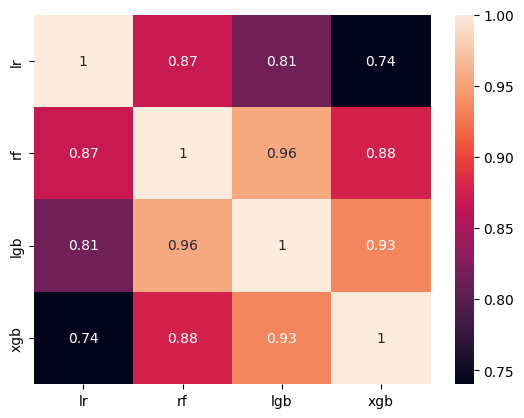

In [55]:
def correlation_between_models_predictions(models):
    base_models_predictions = {}
    
    for model in models:
        print(f'Model: {model[0]}')
        base_models_predictions[model[0]] = cross_val_predict(model[1], df_trans, y_trans, method='predict_proba')[:,1]

    base_models_df = pd.DataFrame(base_models_predictions)

    corrmat = base_models_df.corr()
    sns.heatmap(corrmat, annot=True)

correlation_between_models_predictions (classifiers)

In [60]:
classifiers = [
    ('rf', rf_clf),
    ('lgb', lgb_clf),
    ('xgb', xgb_clf)]

stacking_clf = StackingClassifier(estimators=classifiers, final_estimator=LogisticRegression())
cross_val_score(stacking_clf, df_trans, y_trans, cv=10, scoring='roc_auc').mean()

[LightGBM] [Info] Number of positive: 31429, number of negative: 117101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 148530, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211600 -> initscore=-1.315306
[LightGBM] [Info] Start training from score -1.315306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

0.8885085272050215

### Submission

In [31]:
df_test = pd.read_csv(os.path.join('datasets', 'test.csv'))
df_test_id = df_test['id']
df_test.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)
df_test = preprocessor.set_params(cat__drop='first').fit_transform(df_test)

In [33]:
clf = xgb_clf

y_pred = clf.fit(X=df_trans, y=y_trans).predict_proba(df_test)[:,1]
y_pred

array([0.03146348, 0.827419  , 0.0290903 , ..., 0.02113463, 0.15727645,
       0.17605492], dtype=float32)

In [34]:
submission = pd.DataFrame(data={'id': df_test_id, 'Exited': y_pred})
submission.head()

id    Exited
0  165034  0.031463
1  165035  0.827419
2  165036  0.029090
3  165037  0.229698
4  165038  0.361891

In [46]:
clf.get_params()

{'cv': None,
 'estimators': [('lr',
   LogisticRegression(class_weight='balanced', random_state=123)),
  ('rf',
   RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=123)),
  ('lgb', LGBMClassifier(class_weight='balanced', objective='binary')),
  ('xgb',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, device=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 multi_strategy=None, n_estimators=None, n_jobs=No

In [12]:
sorted(list(zip(clf.feature_importances_, feature_names)), reverse=True)

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

In [92]:
#clf.save_model('xgboost.json')

In [35]:
submission.to_csv(os.path.join('submissions','XGboost another try just in case.csv'), index=False)